In [9]:
from collections import defaultdict
from pathlib import Path
from languages import languages
from tokens import all_tokenizers
from translations import translate
from plots import plot_model_lang_distributions
from tokens import calculate_percentage_differences
from tokens import remove_special_characters
from languages import non_latin_languages
from openai import OpenAI

In [10]:
source_text = Path("saturn.txt").read_text()

num_tokens_original_text = defaultdict(dict)
processing_cost_original_text = defaultdict(dict)

num_tokens_original_text_no_special_characters = defaultdict(dict)
processing_cost_original_text_no_special_characters = defaultdict(dict)

for lang_code in languages.keys():
    translated_text = translate(source_text, lang_code)

    for tokenizer in all_tokenizers:
        num_tokens_original_text[tokenizer.VERBOSE_NAME][lang_code] = tokenizer.get_cached_token_count(translated_text)
        processing_cost_original_text[tokenizer.VERBOSE_NAME][lang_code] = tokenizer.processing_cost_usd(translated_text)

        if lang_code not in non_latin_languages:
            translated_text_without_special_characters = remove_special_characters(translated_text)

            num_tokens_original_text_no_special_characters[tokenizer.VERBOSE_NAME][lang_code] = tokenizer.get_cached_token_count(translated_text_without_special_characters)
            processing_cost_original_text_no_special_characters[tokenizer.VERBOSE_NAME][lang_code] = tokenizer.processing_cost_usd(translated_text_without_special_characters)

processing_cost_original_text_without_gpt4 = {k:v for k,v in processing_cost_original_text.items() if not k.startswith("GPT-4")}
processing_cost_original_text_without_gpt4_no_special_characters = {
    k:v for k,v in processing_cost_original_text_no_special_characters.items() if not k.startswith("GPT-4")
}

# Number of tokens

* All GPT models share same tokenizer


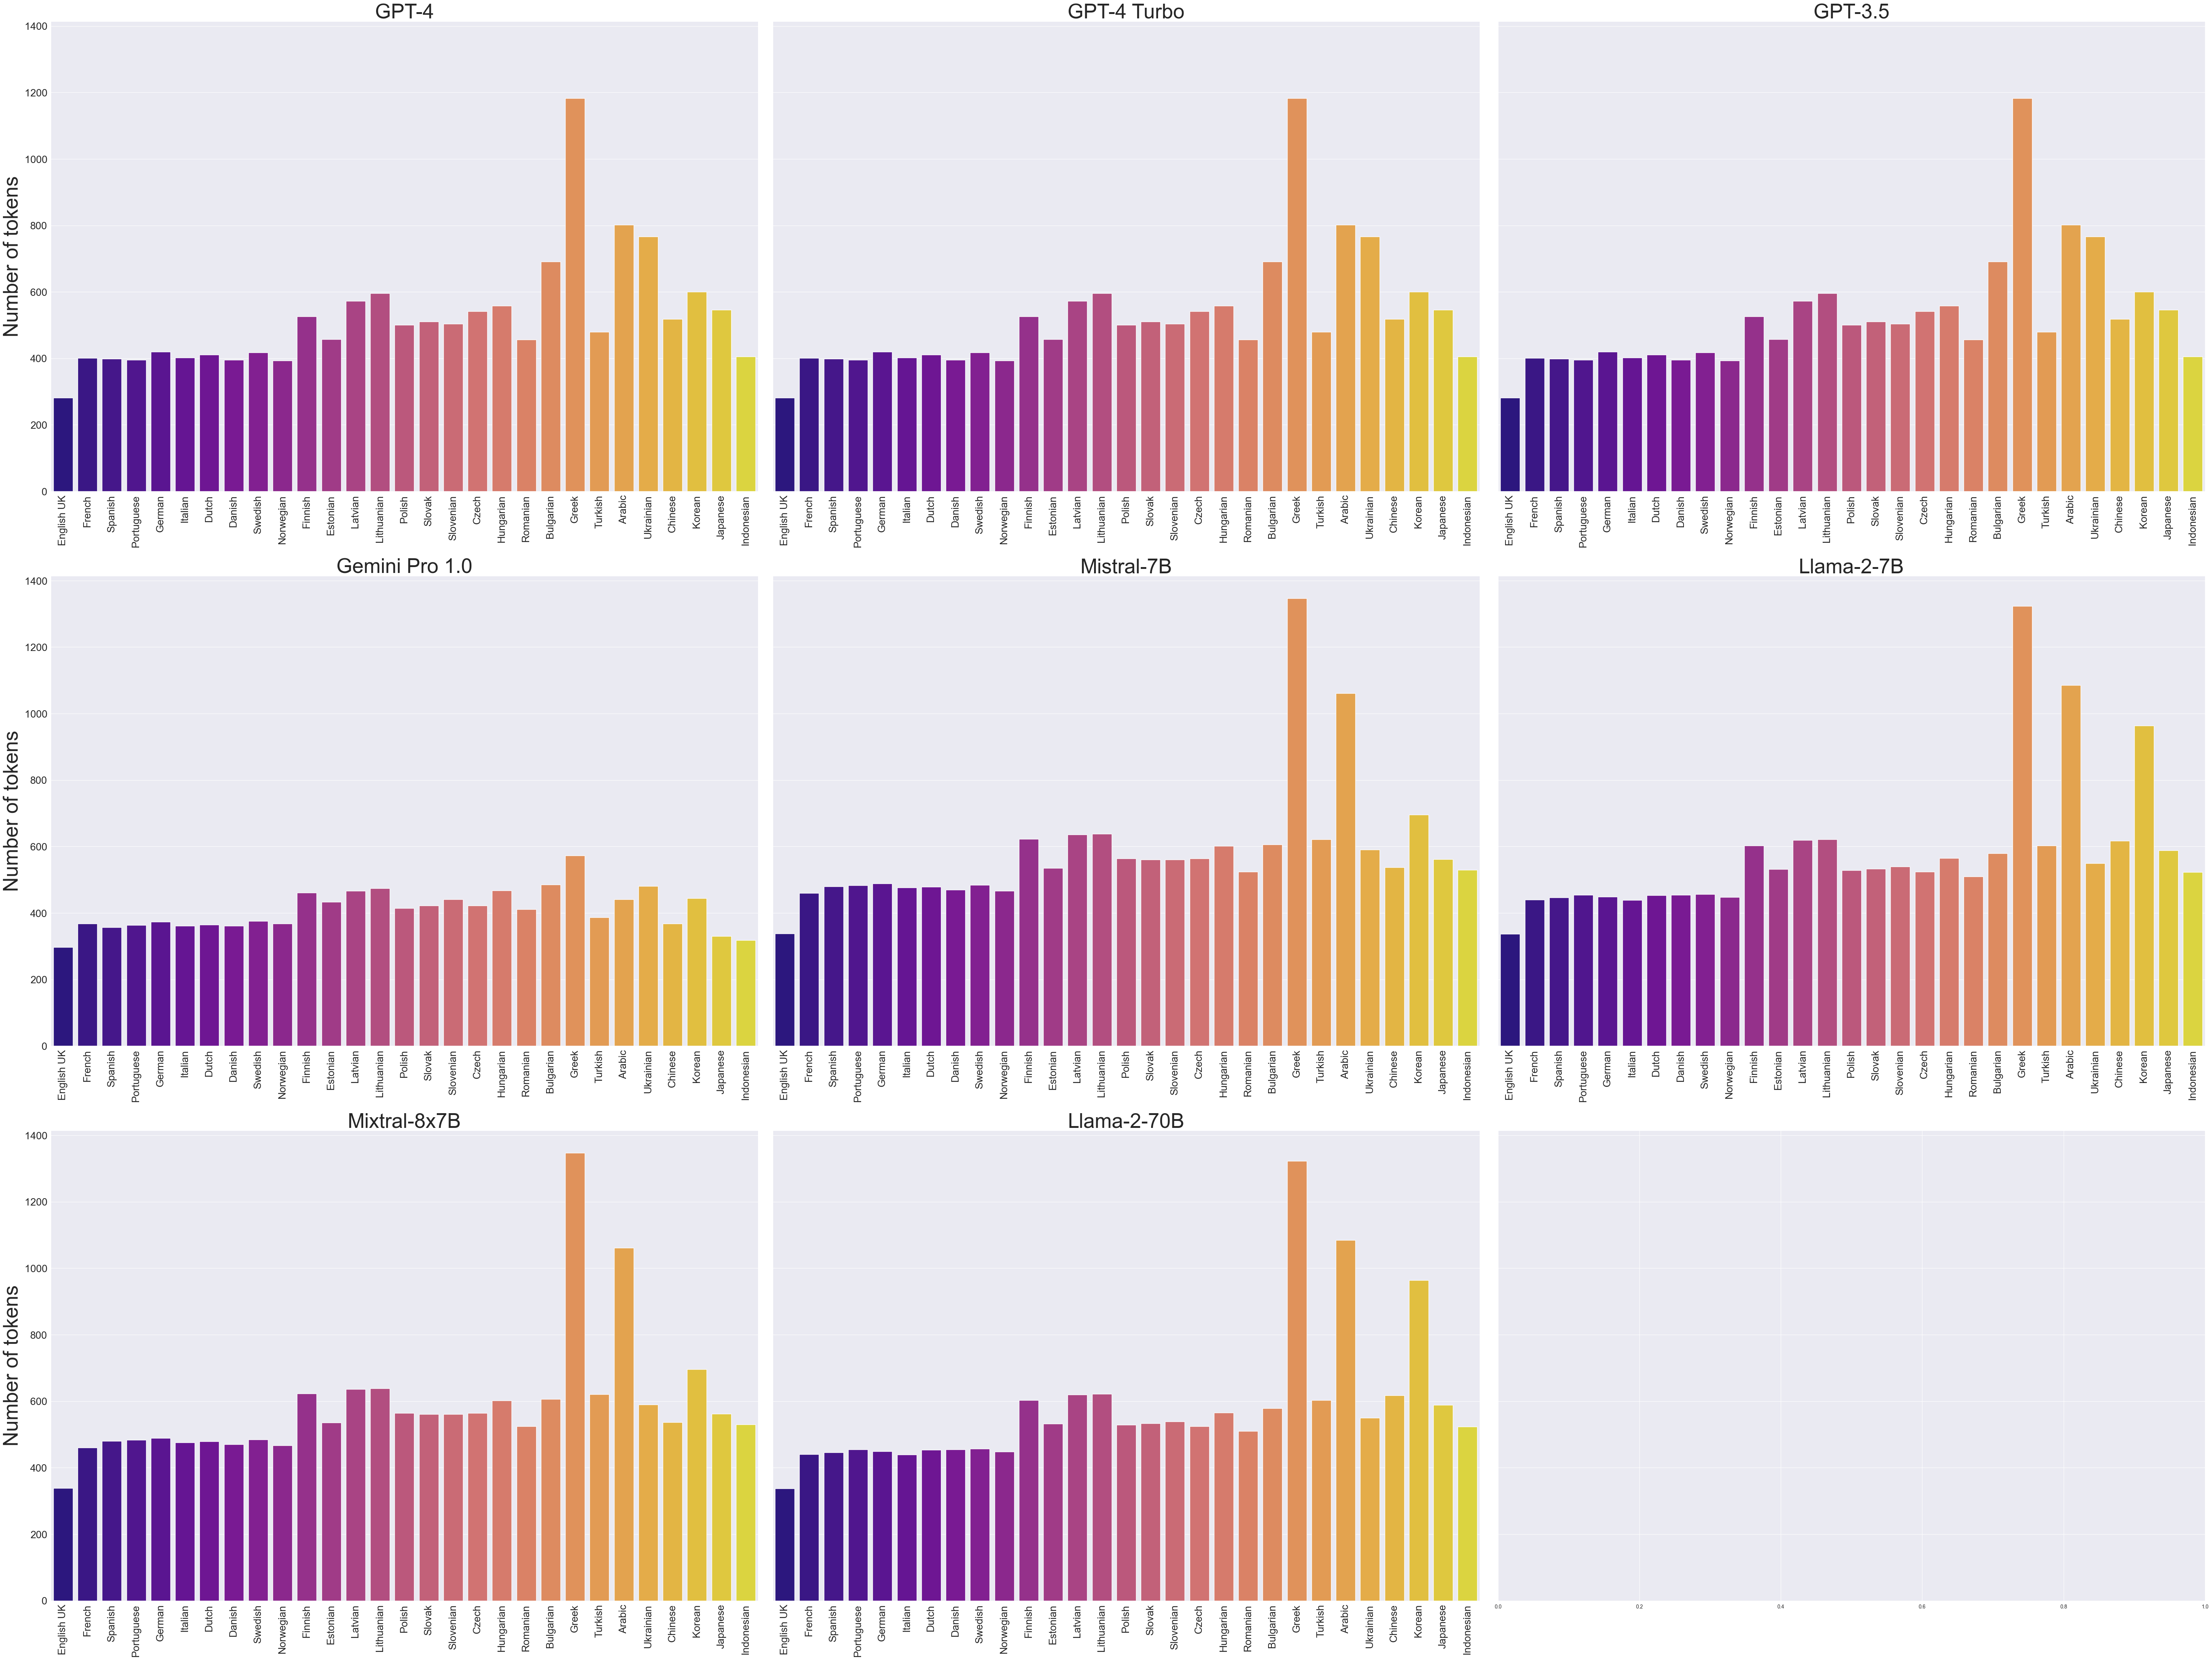

In [11]:
plot_model_lang_distributions(
    num_tokens_original_text,
    "plots_token/model_lang_distributions.png",
    "Number of tokens"
)

# Pricing

* GPT-4 is much more expensive then other models

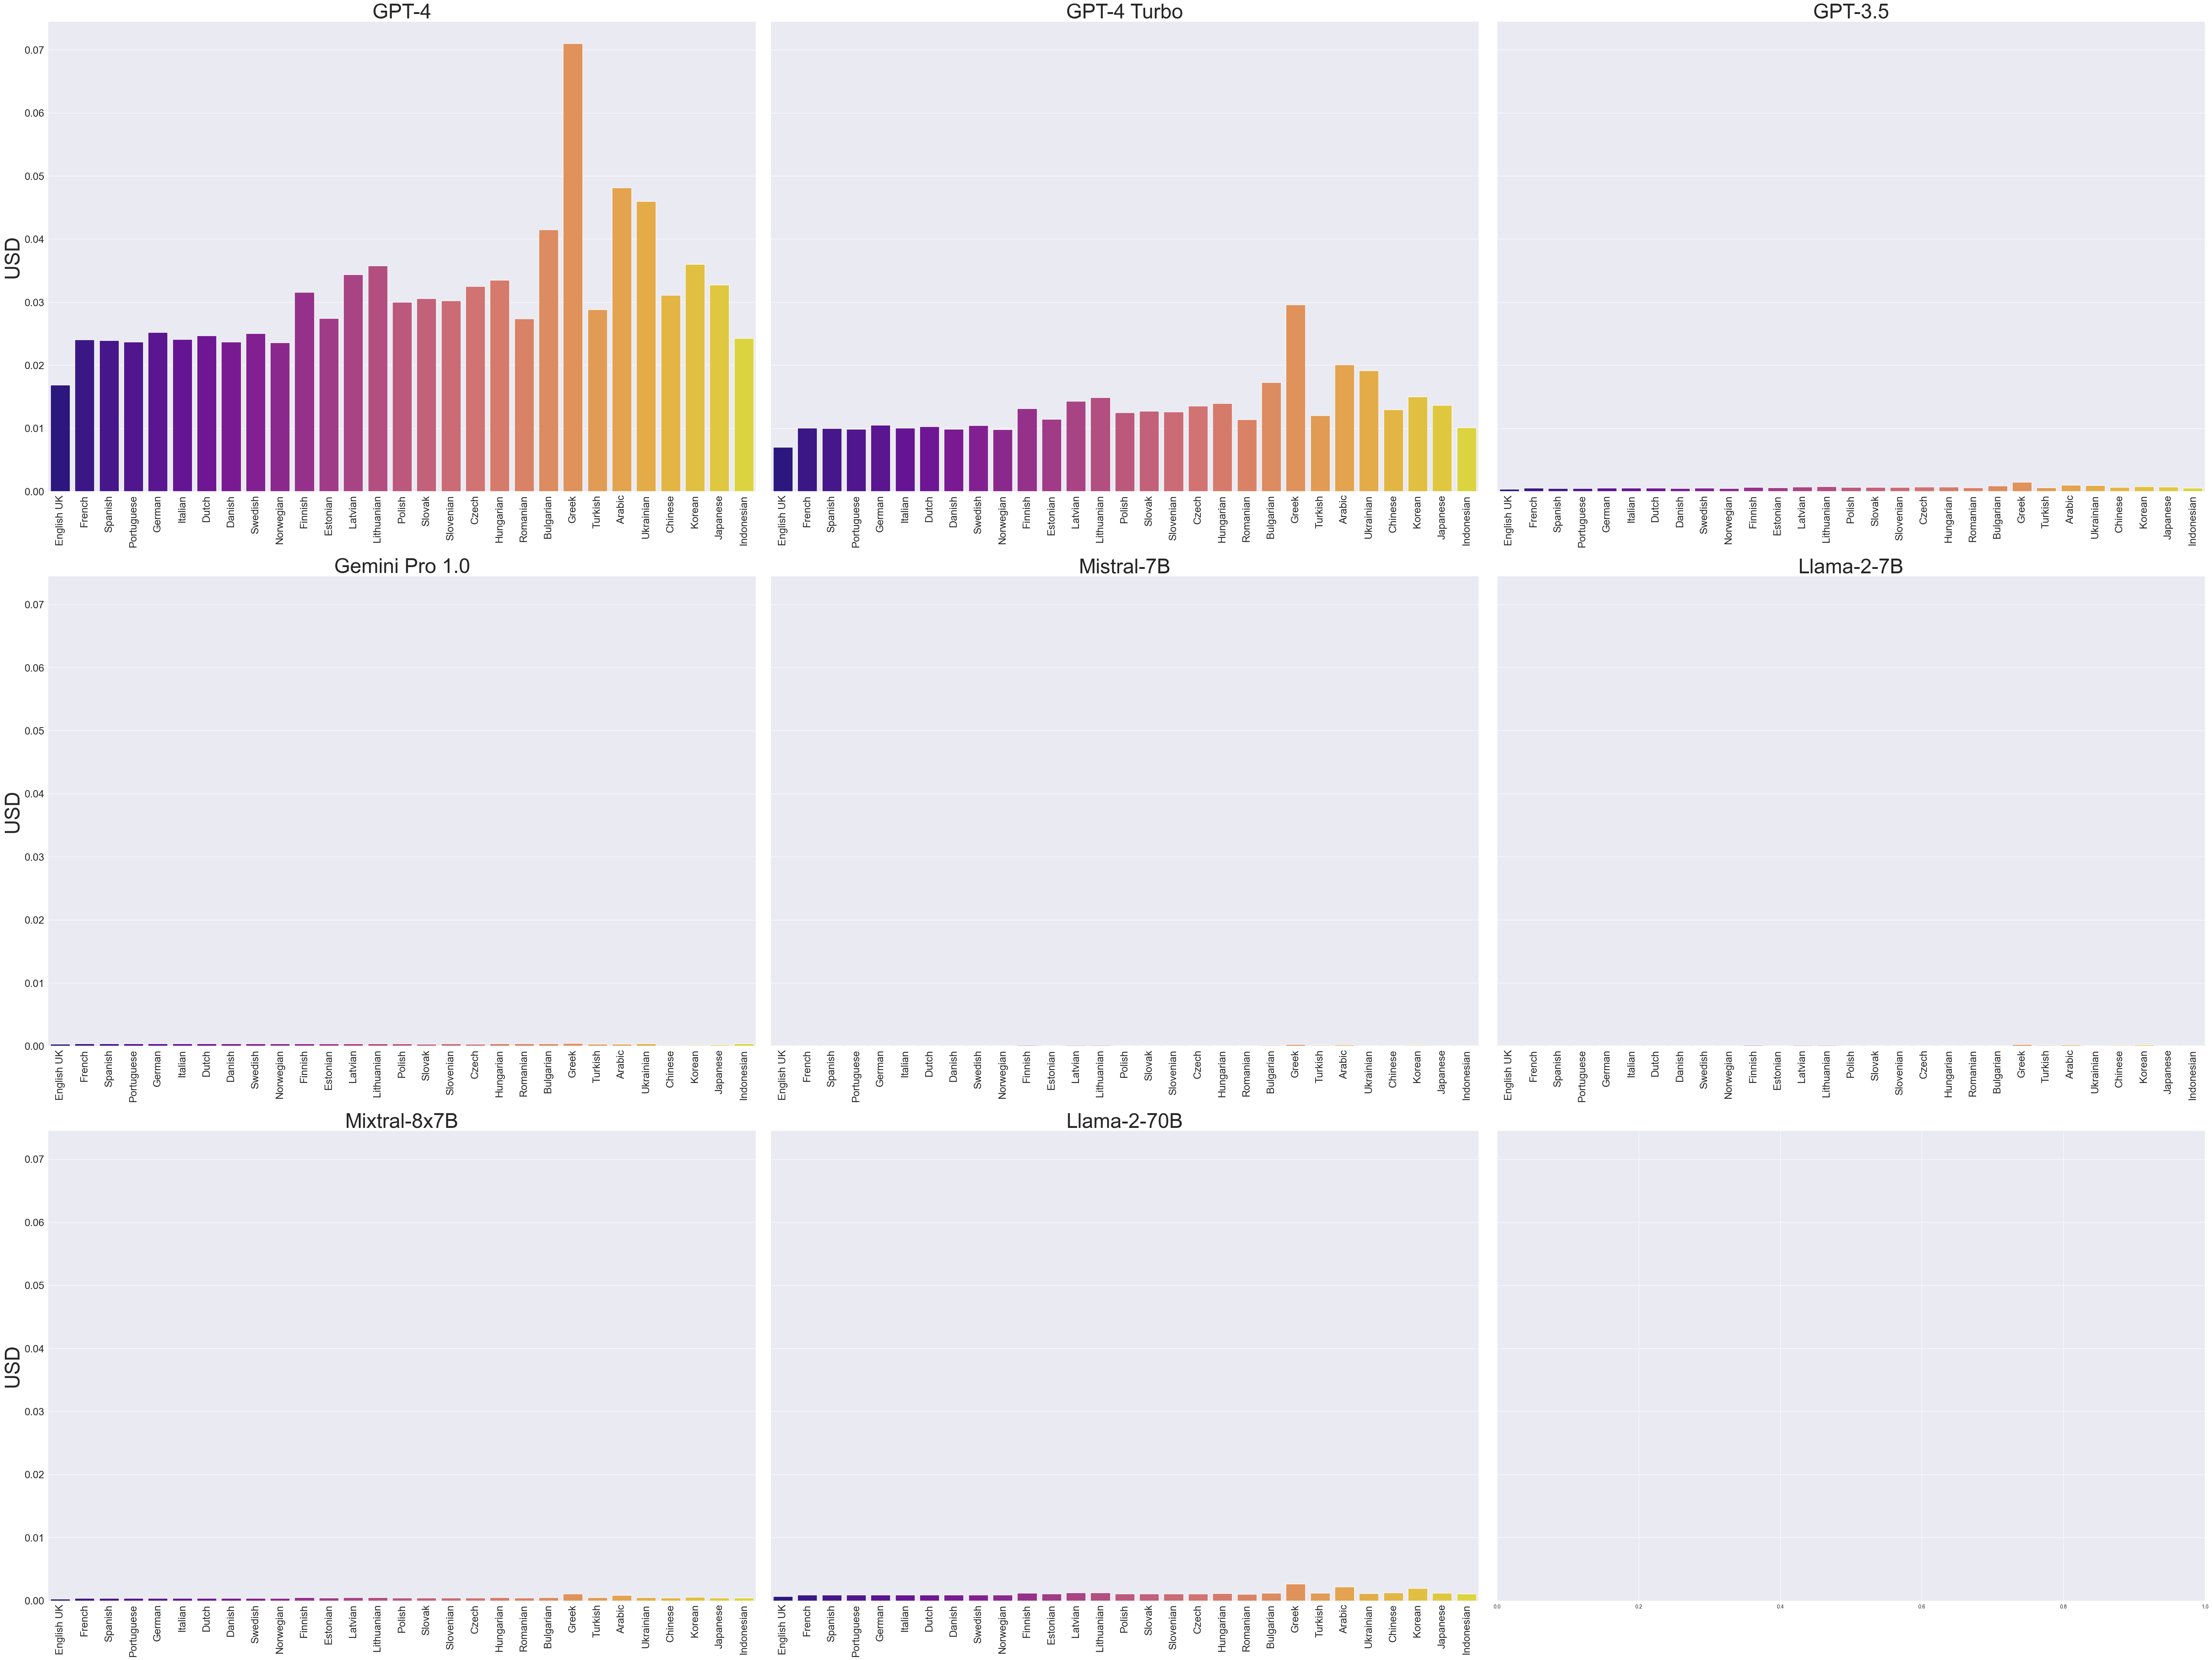

In [12]:
plot_model_lang_distributions(processing_cost_original_text, "plots_token/processing_cost.png", "USD")

# Pricing without GPT4

* We have to exclude GPT-4 to get some insights

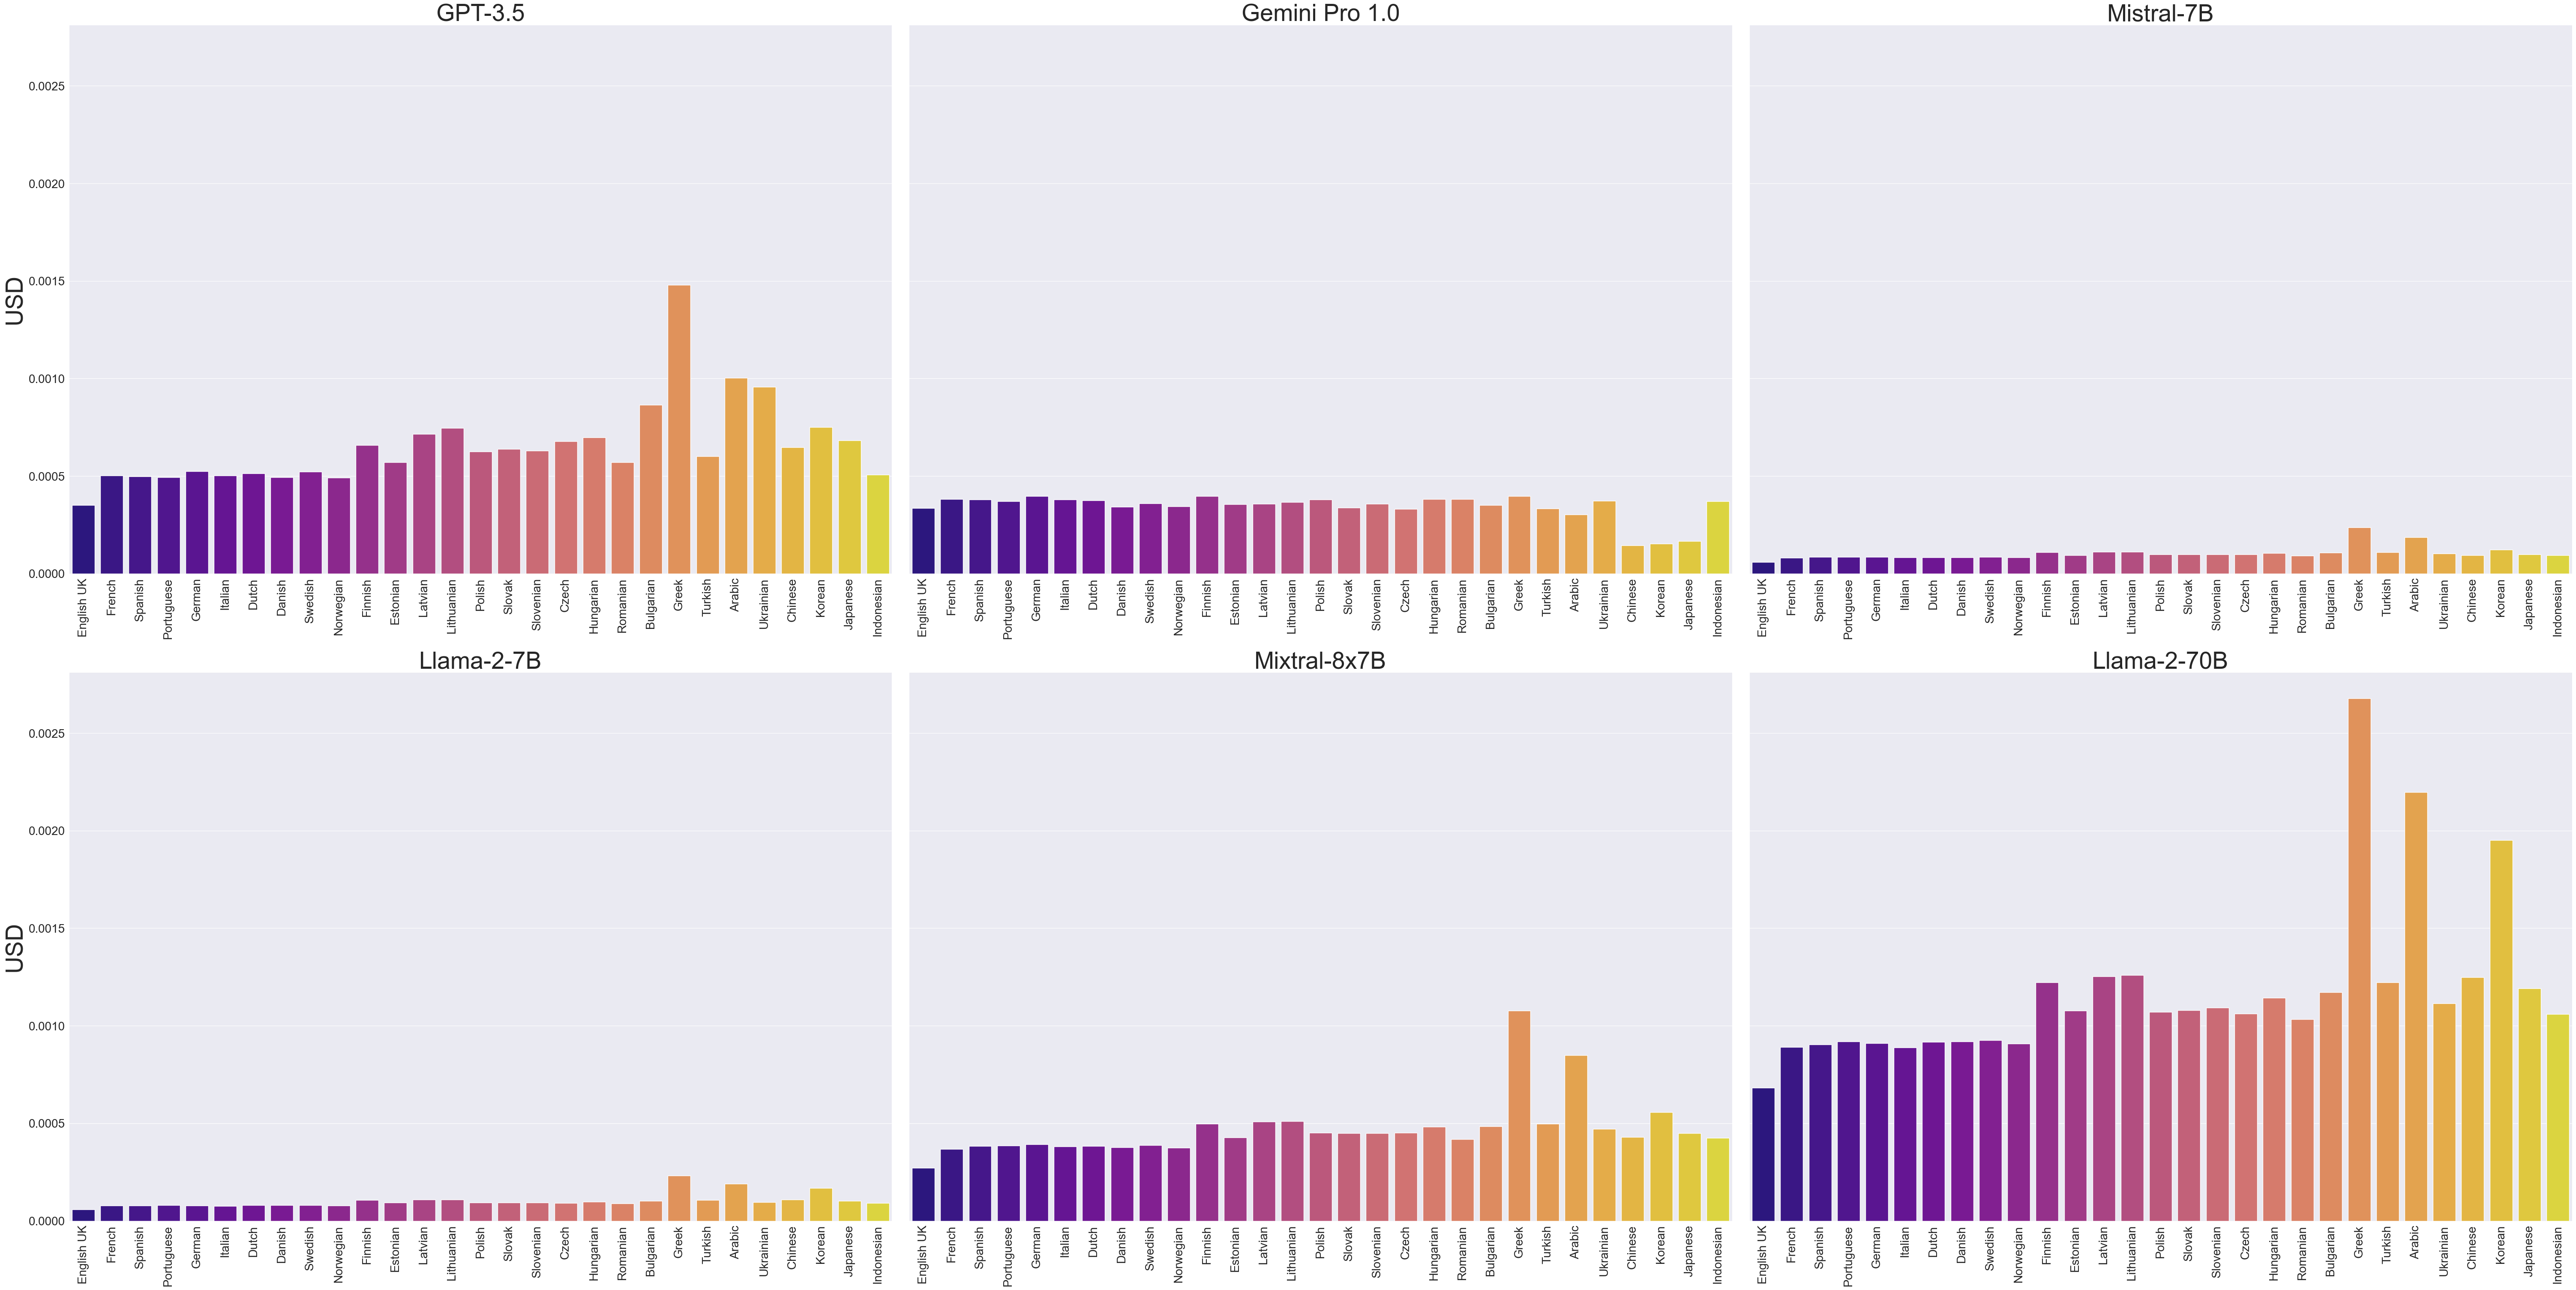

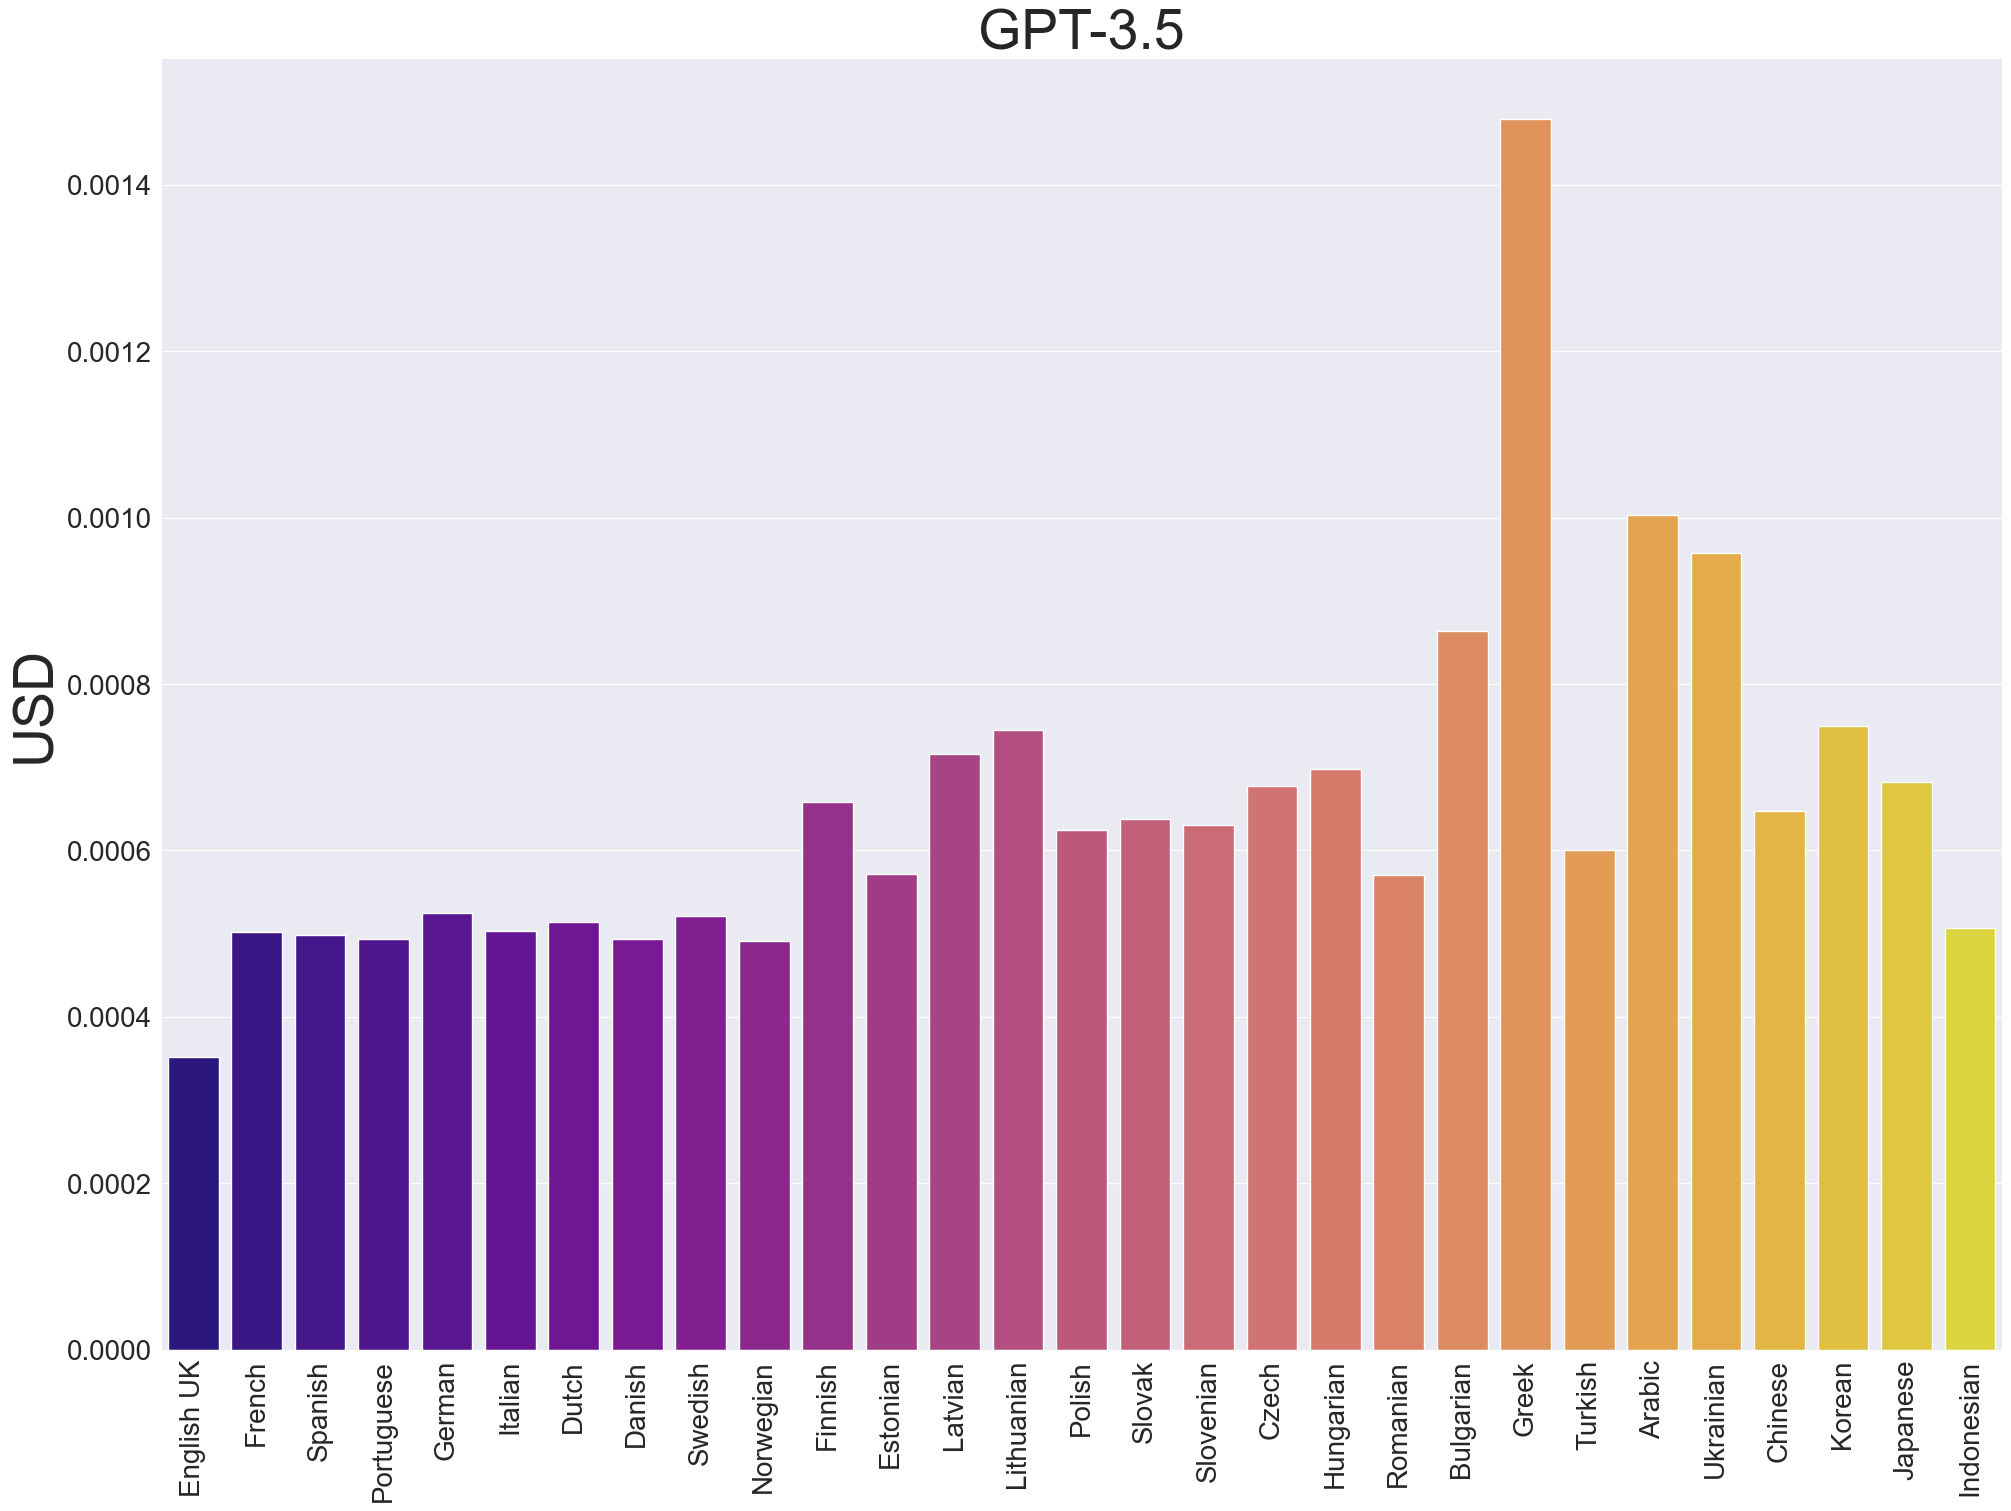

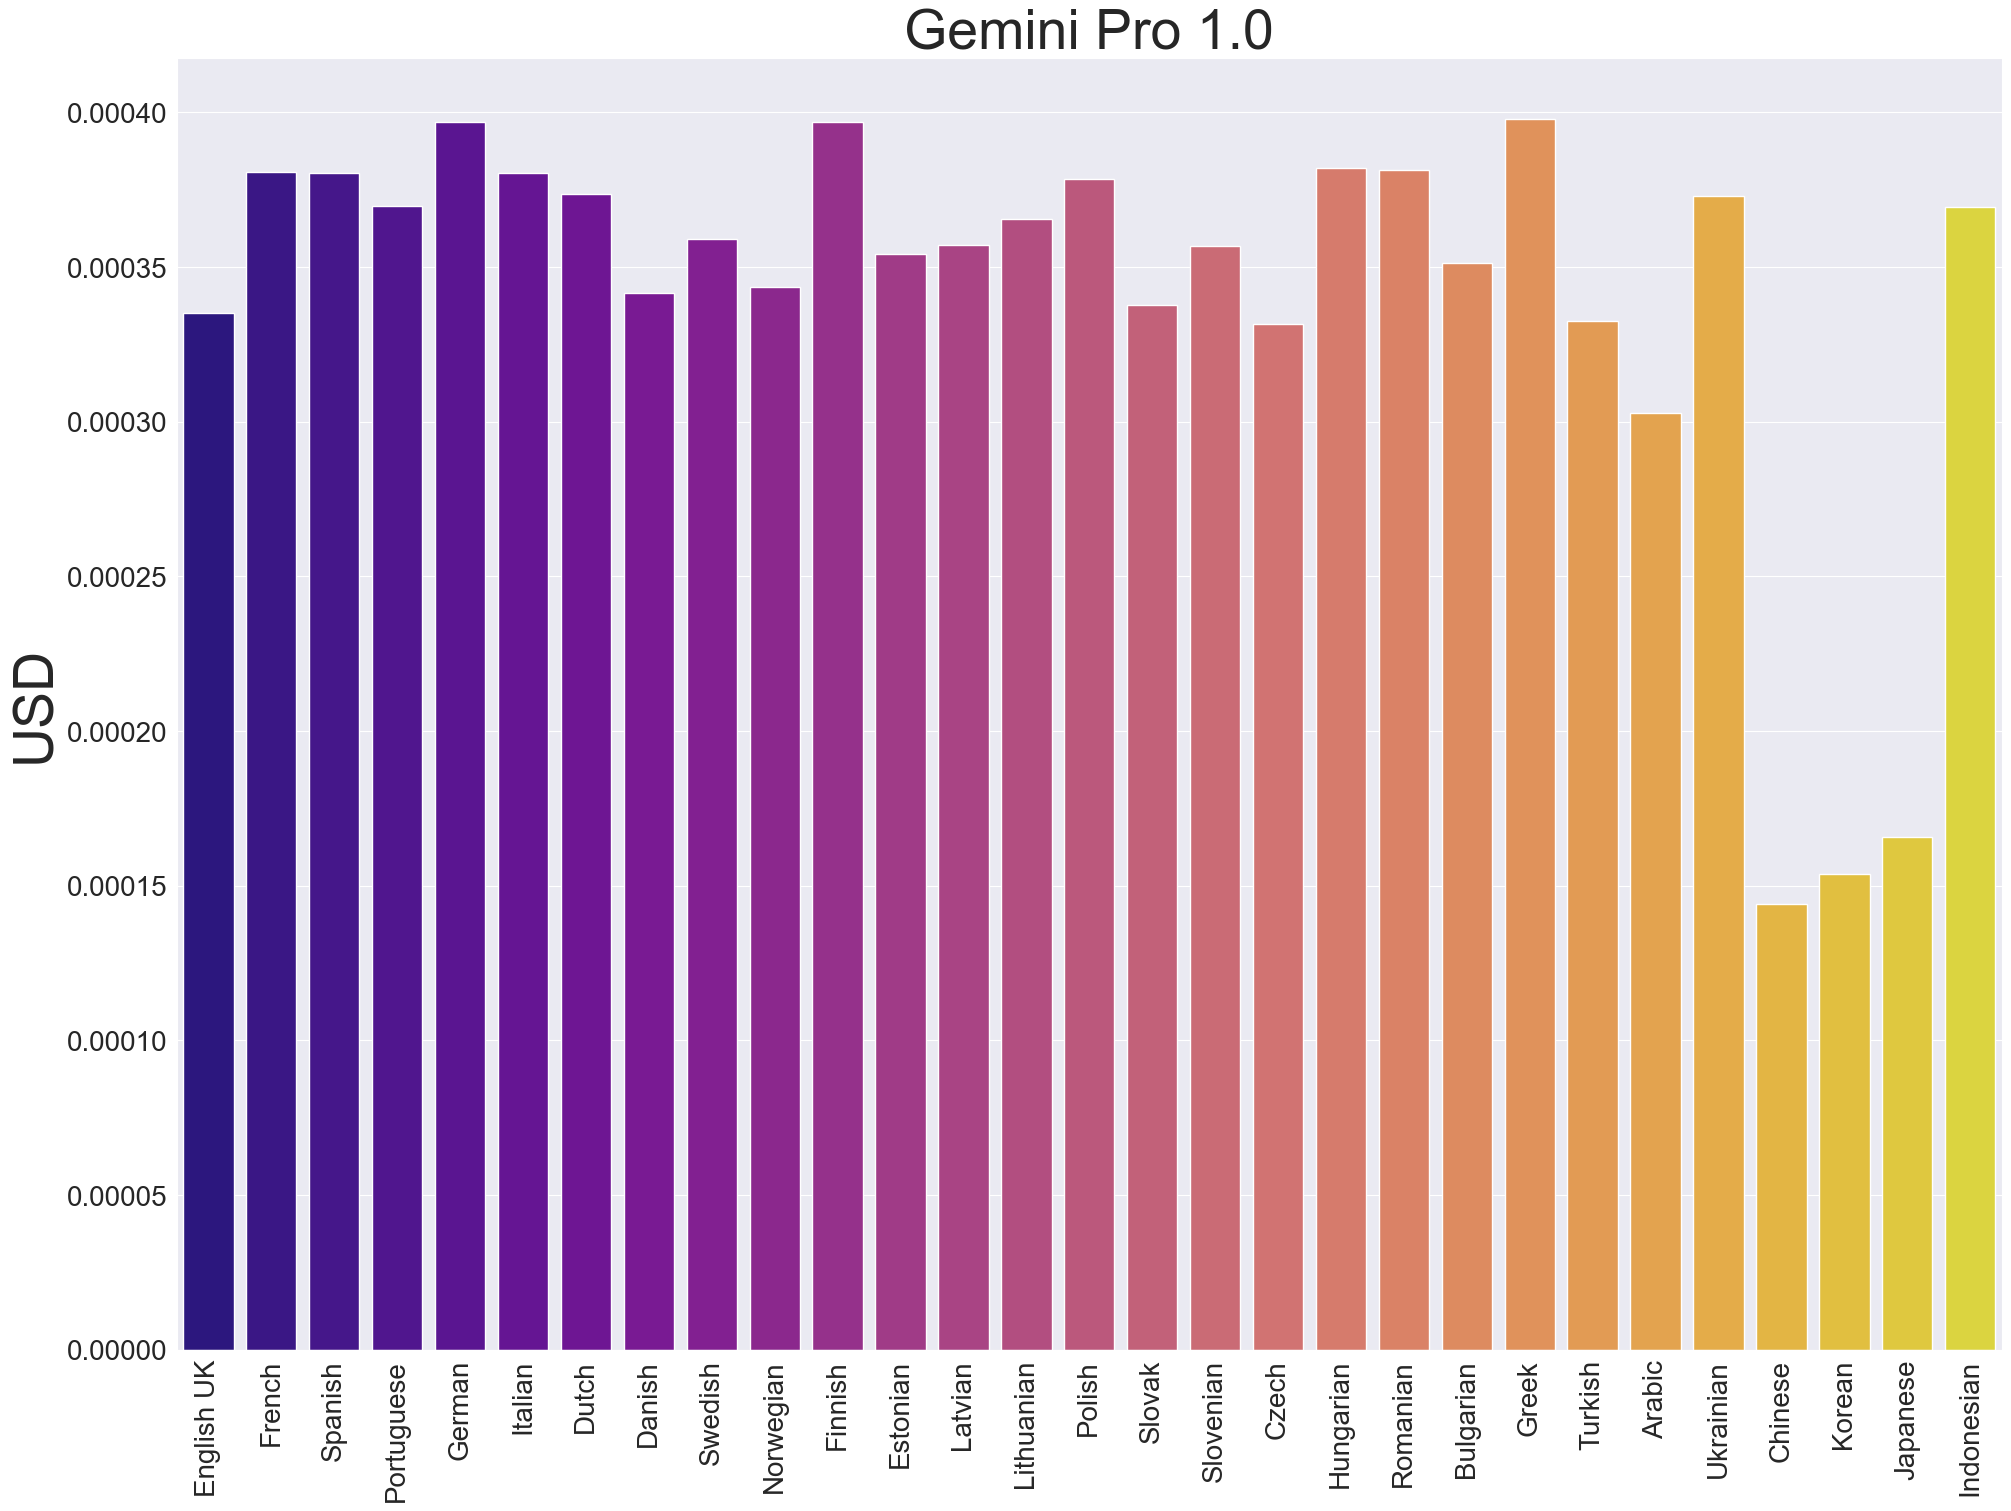

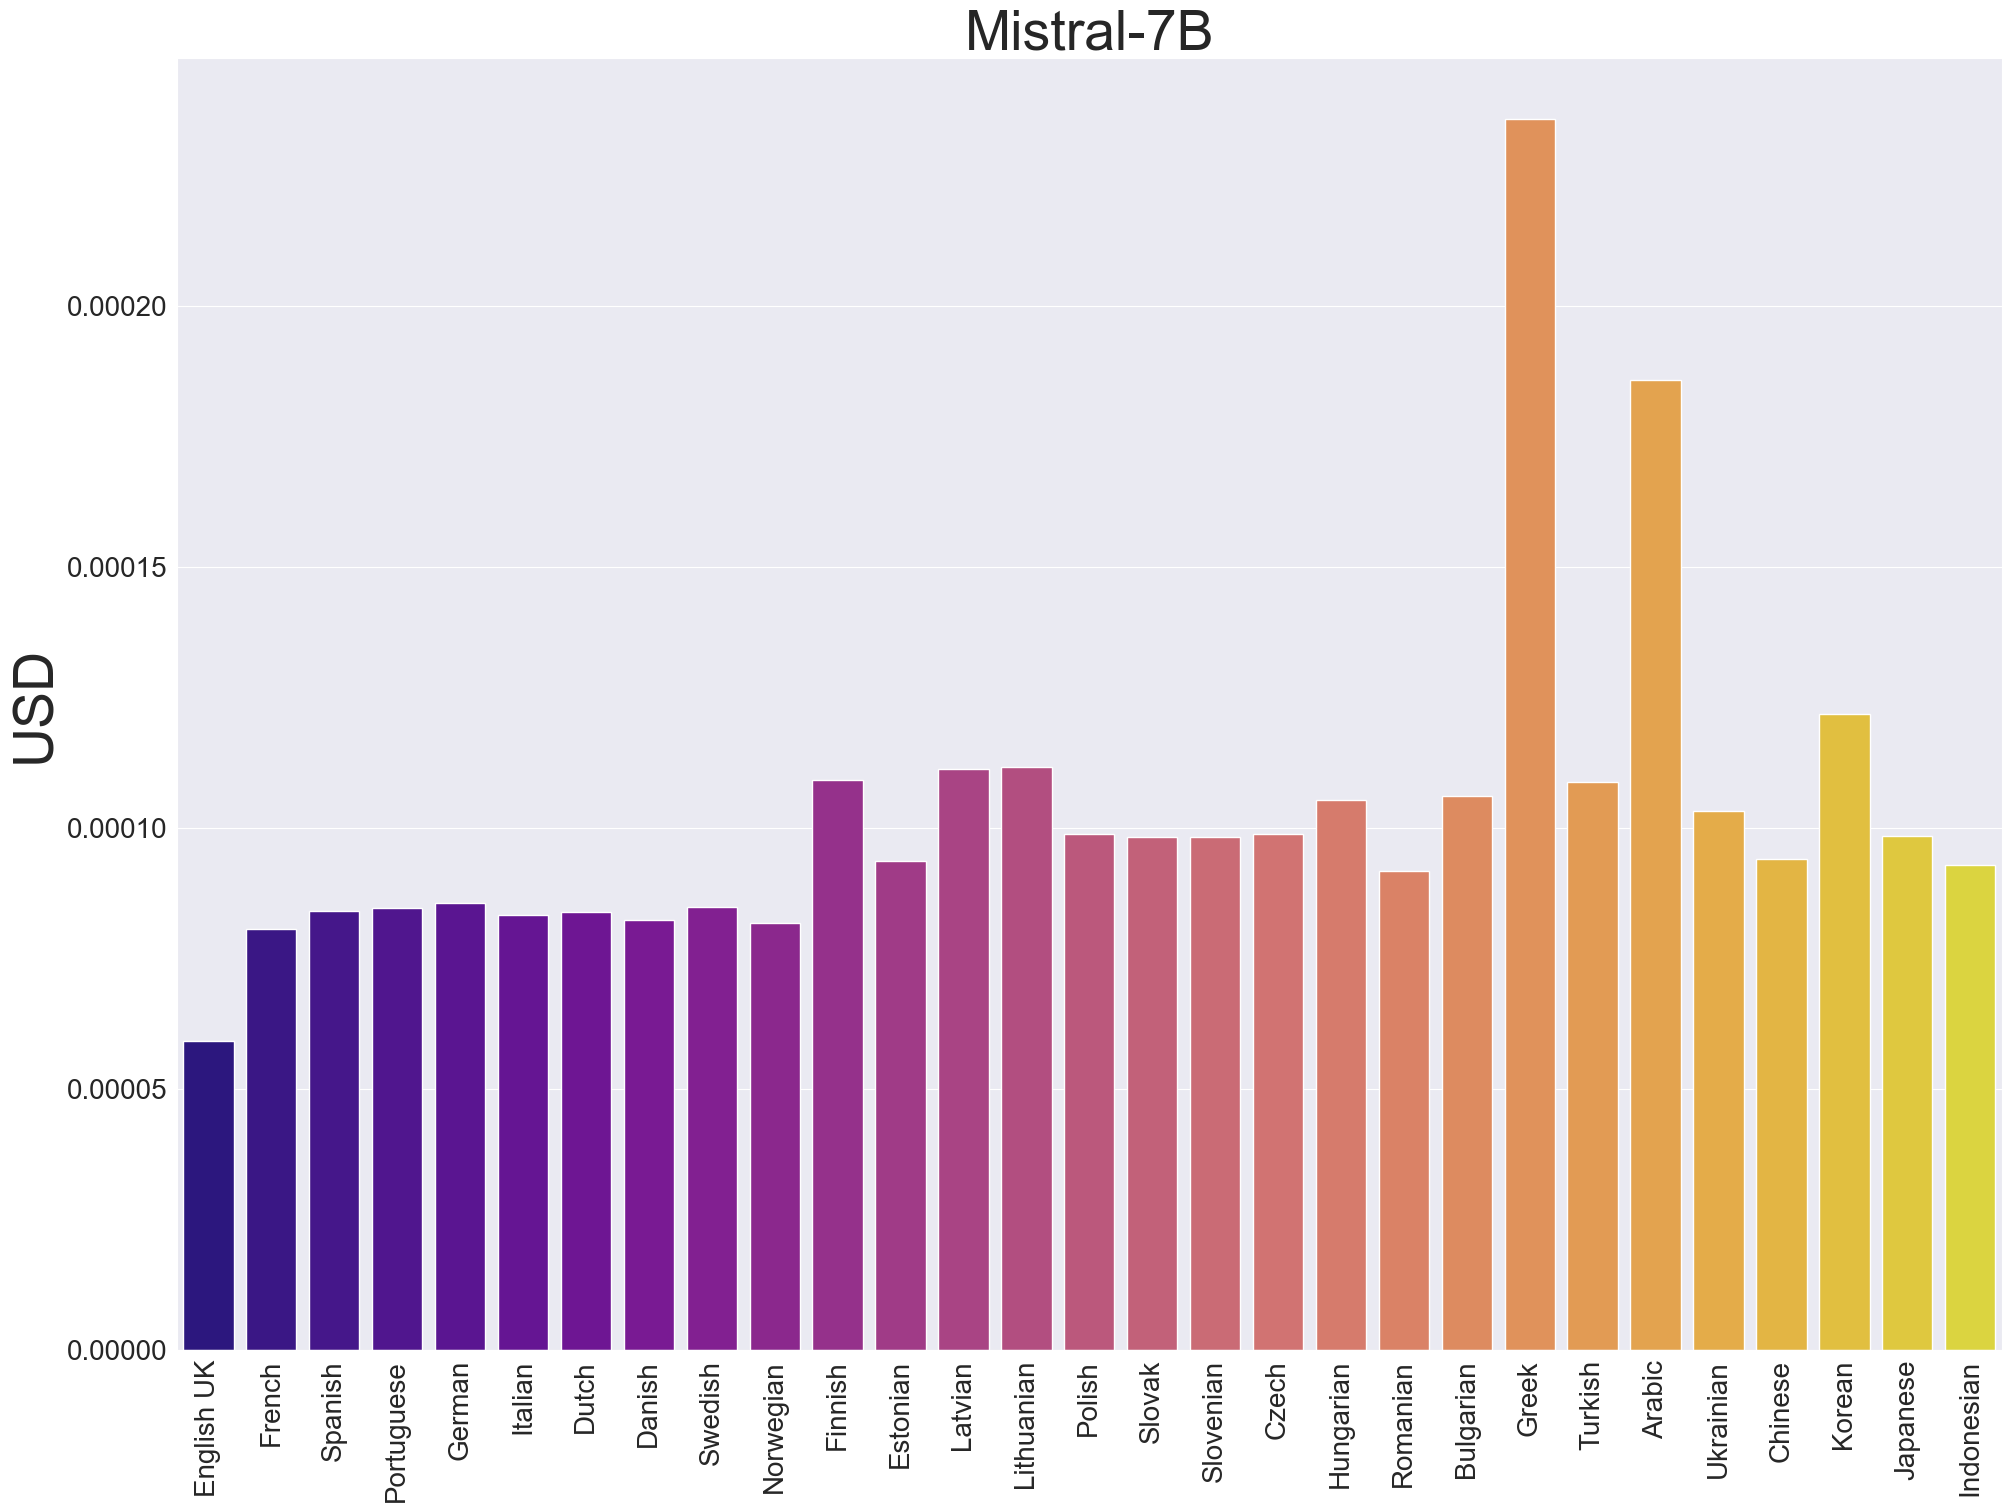

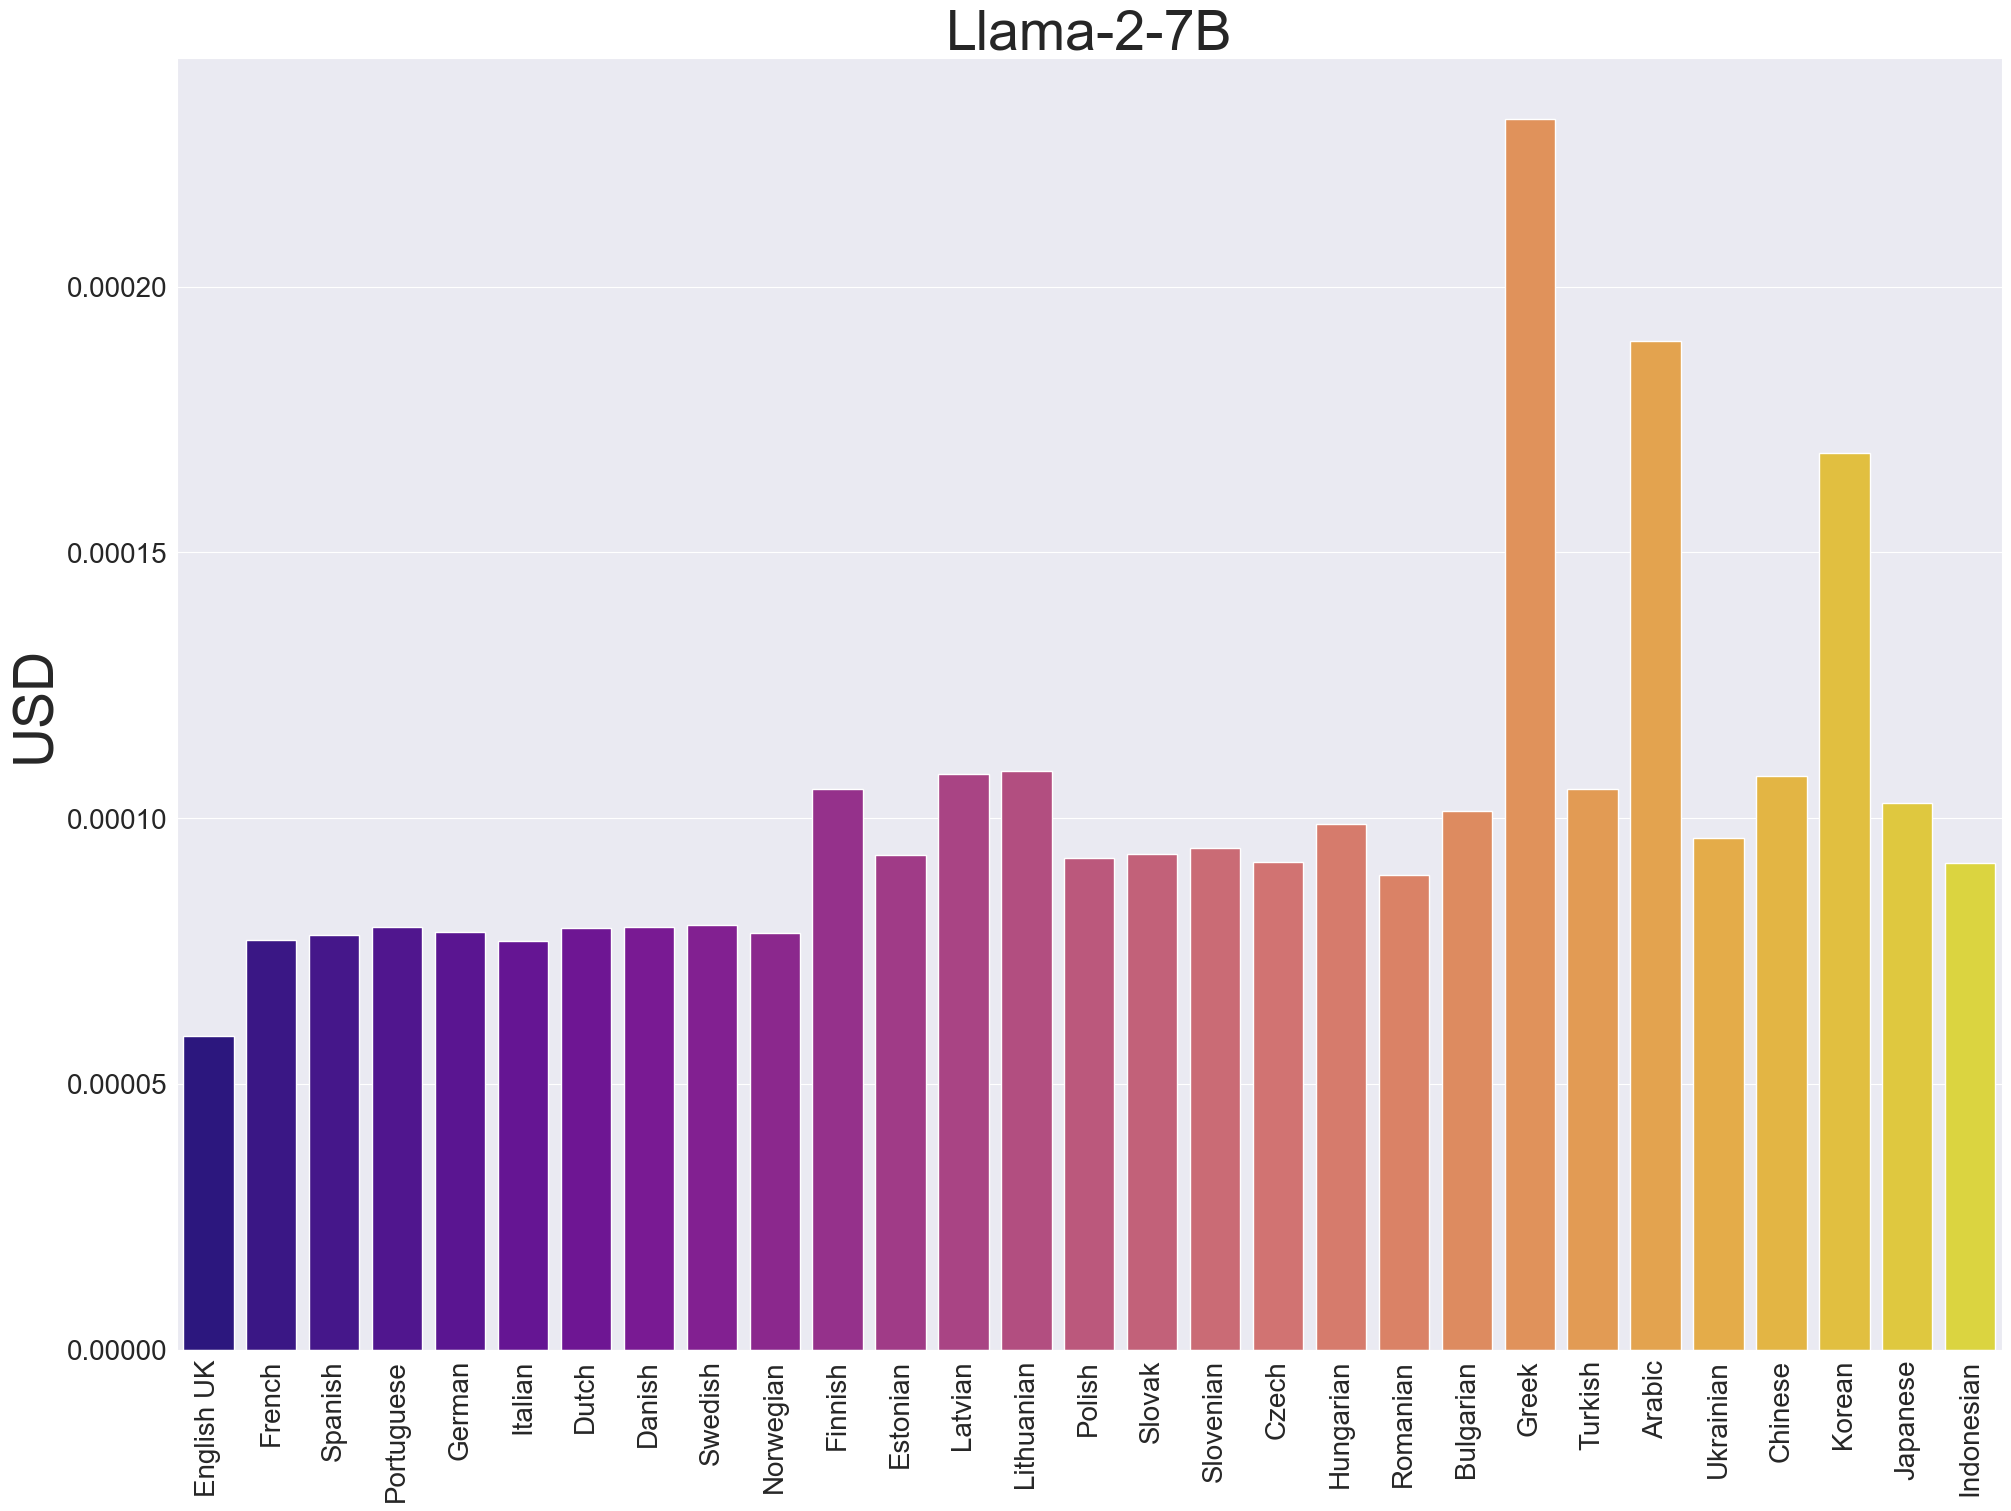

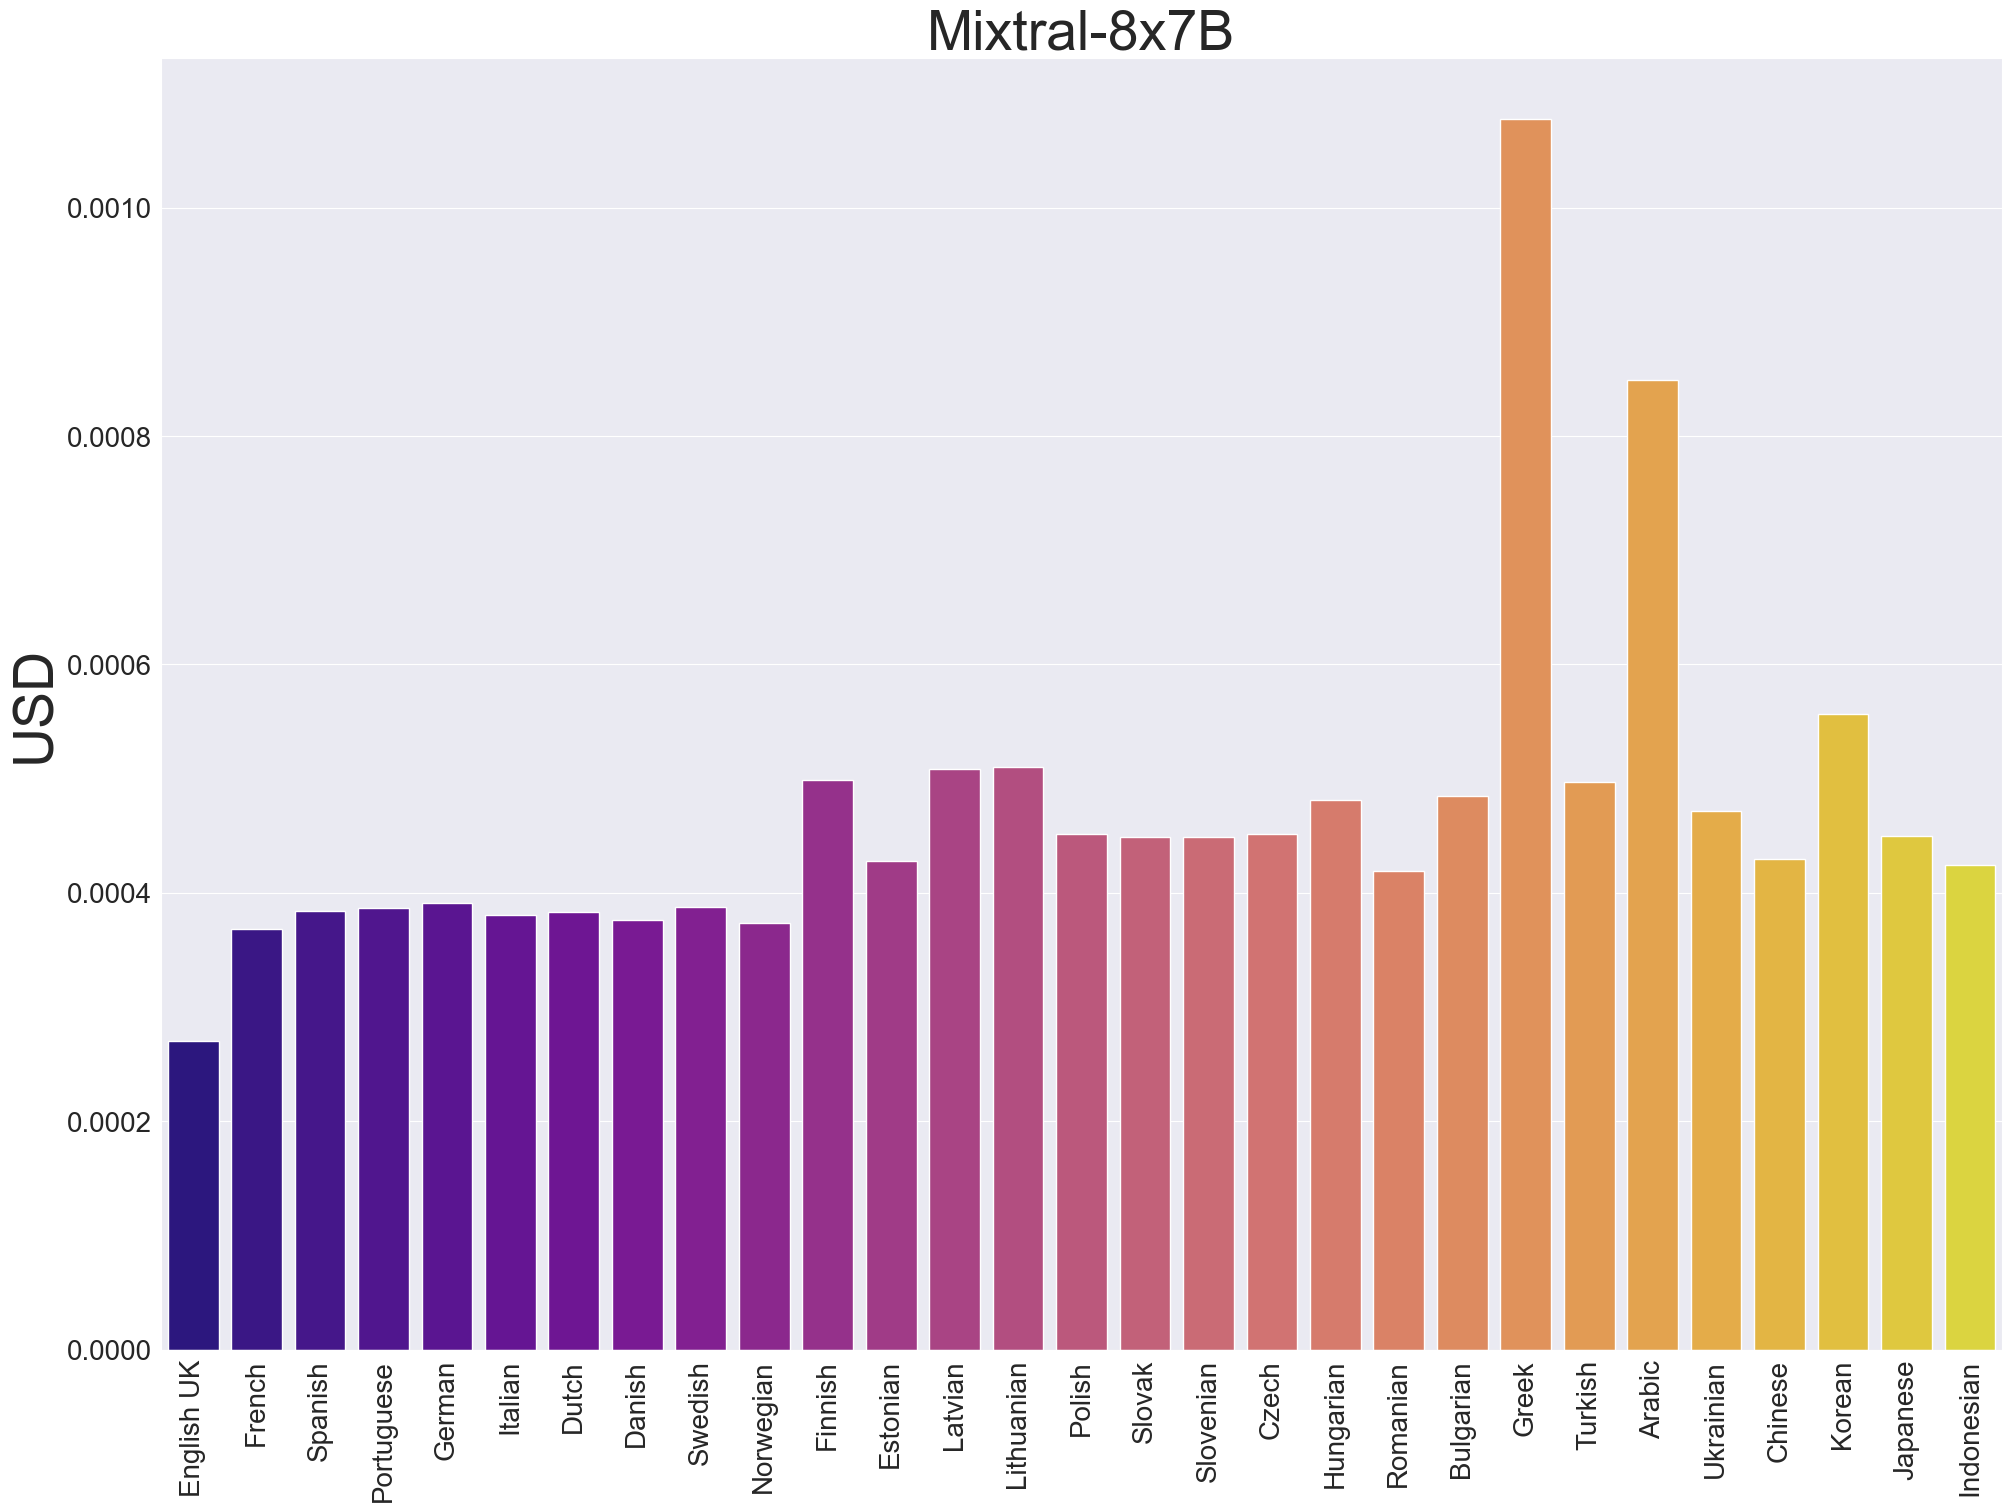

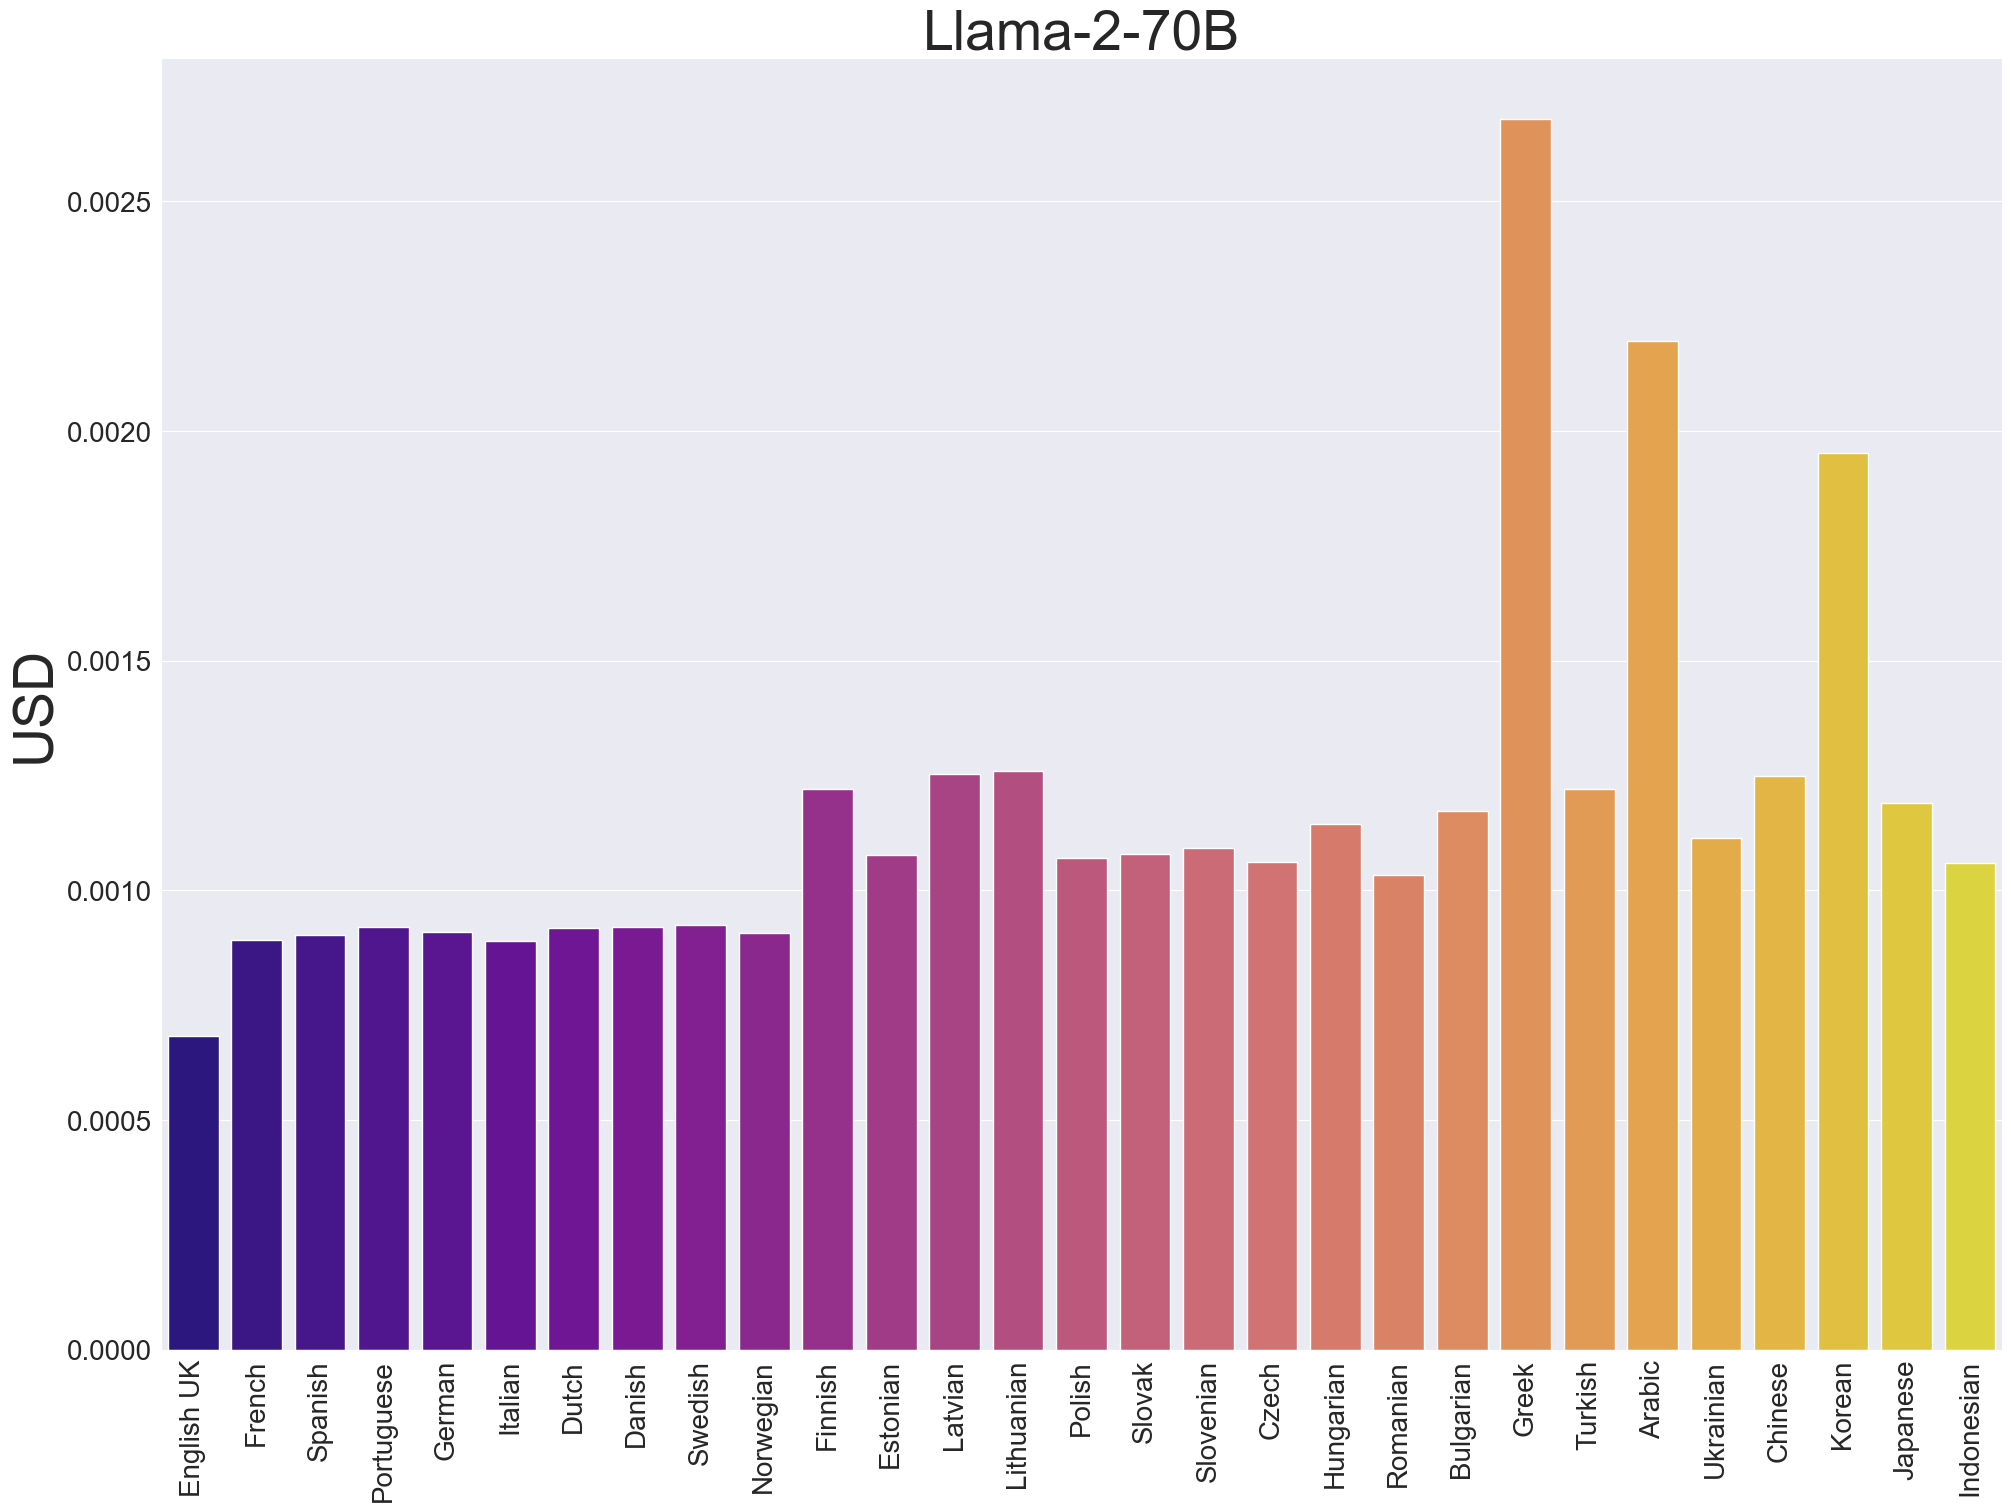

In [13]:
from plots import plot_as_separate_charts

plot_model_lang_distributions(
    processing_cost_original_text_without_gpt4,
    "plots_token/processing_cost_without_gpt4.png",
    "USD",
    num_rows=2
)

plot_as_separate_charts(
    processing_cost_original_text_without_gpt4,
    "plots_token/processing_cost_without_gpt4.png",
    "USD",
)

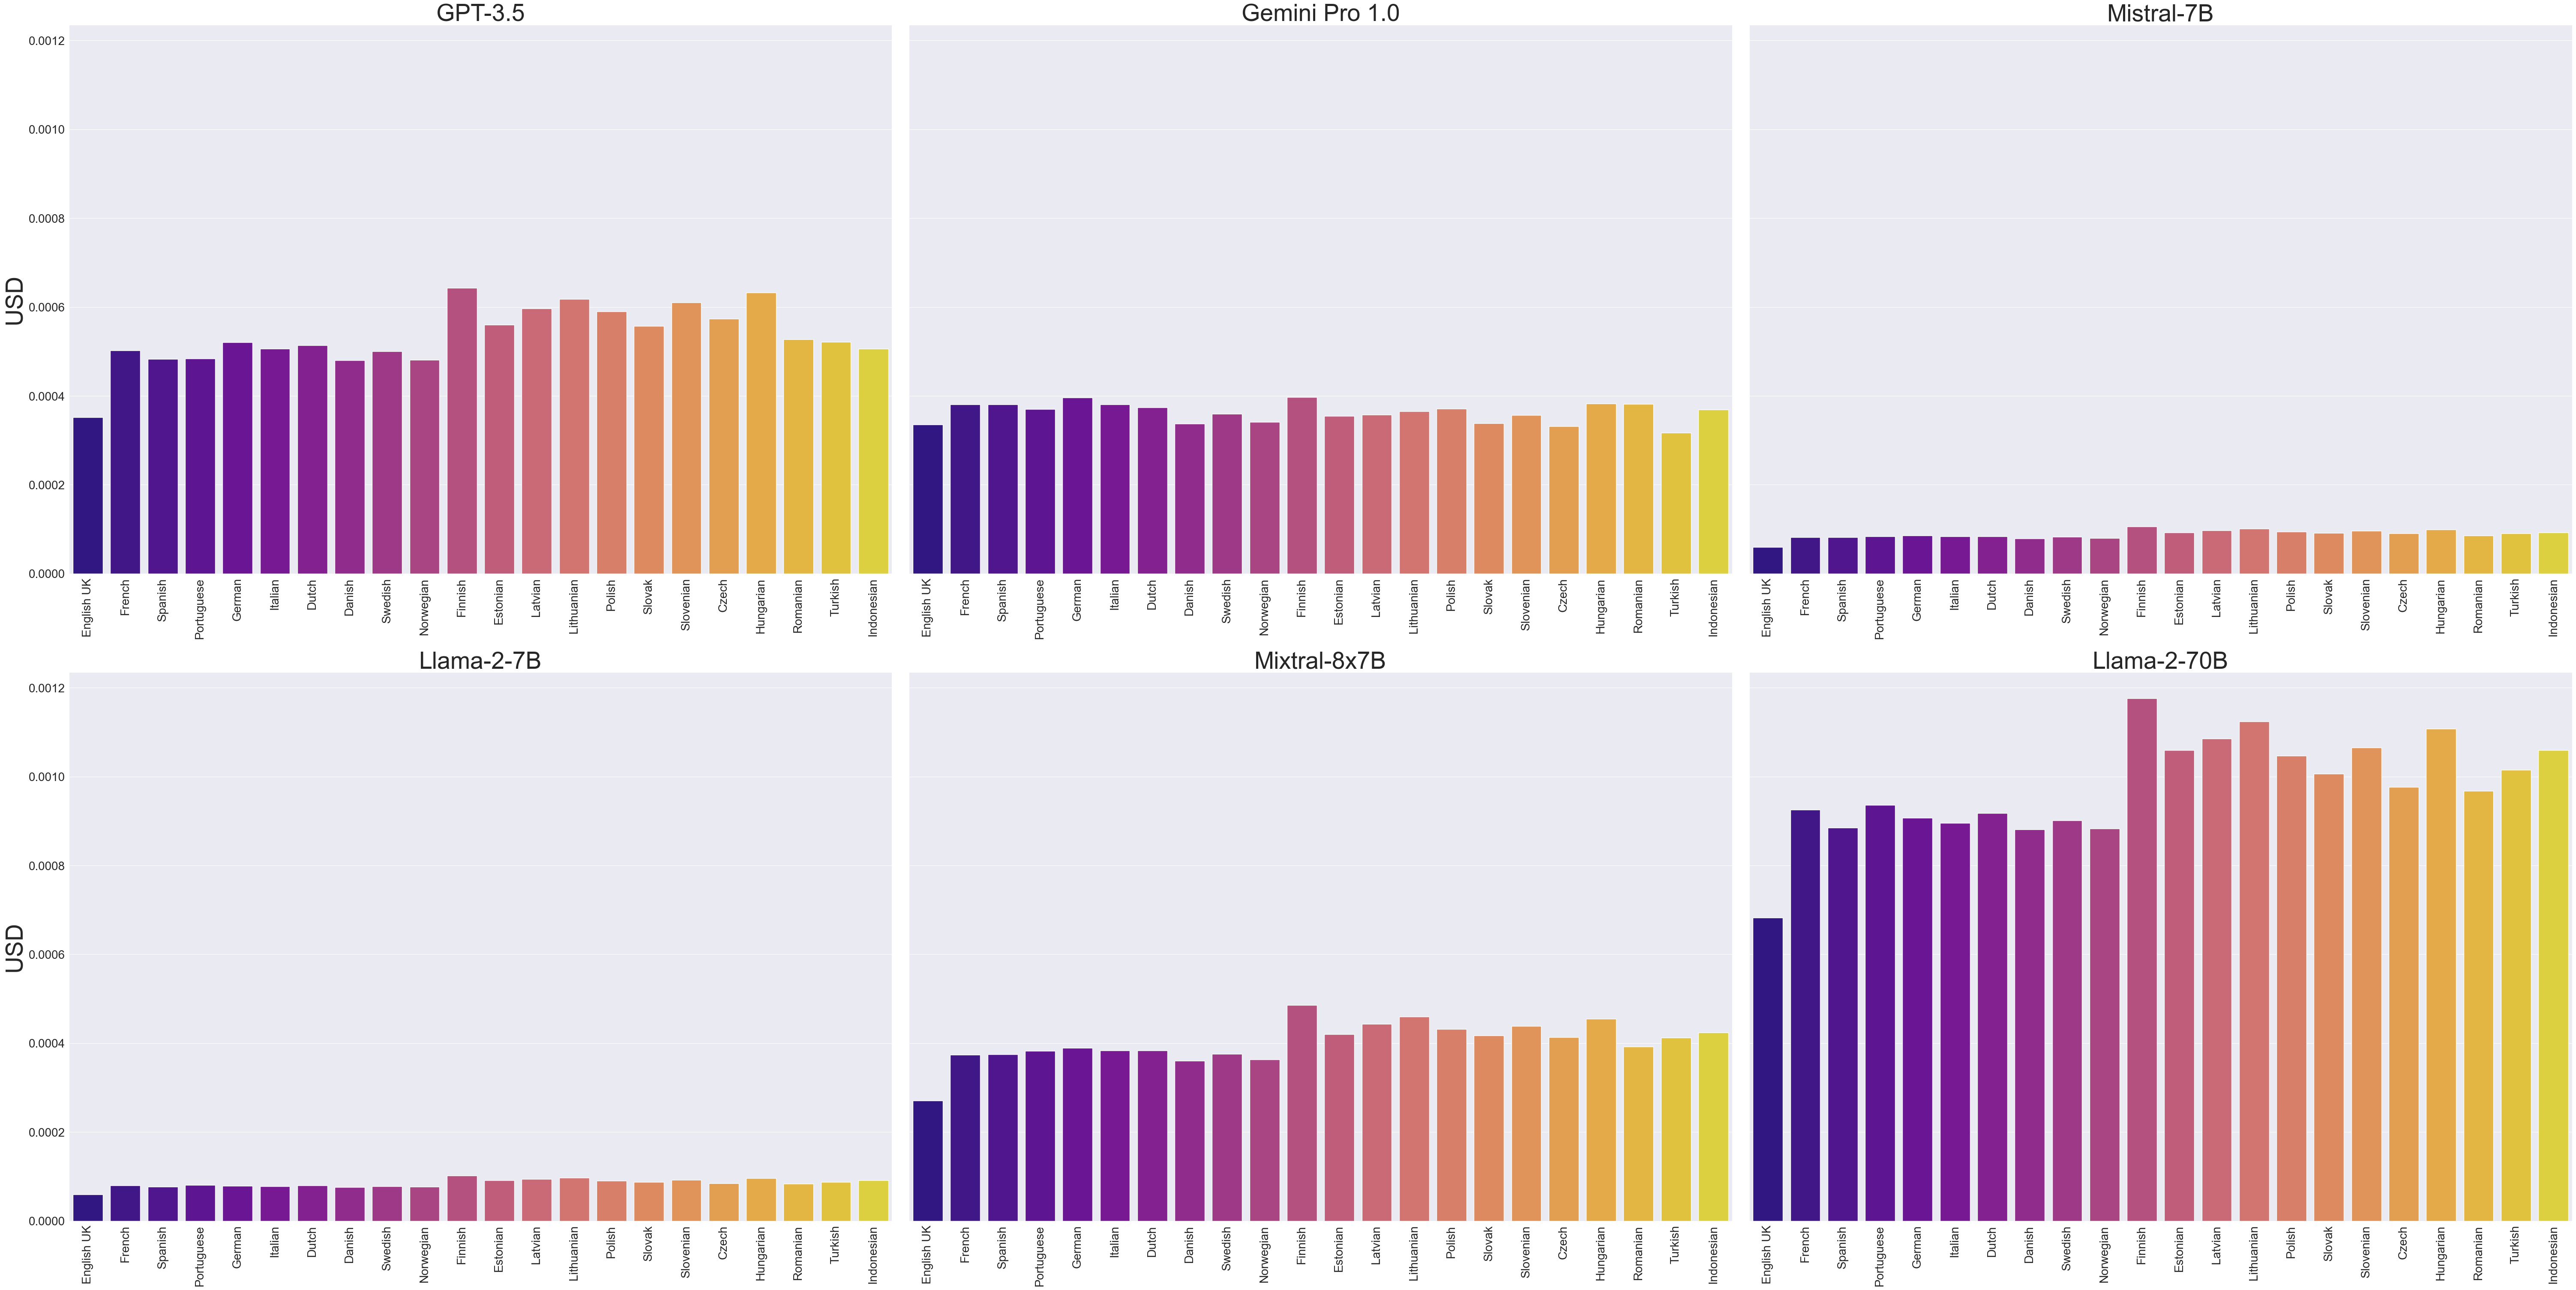

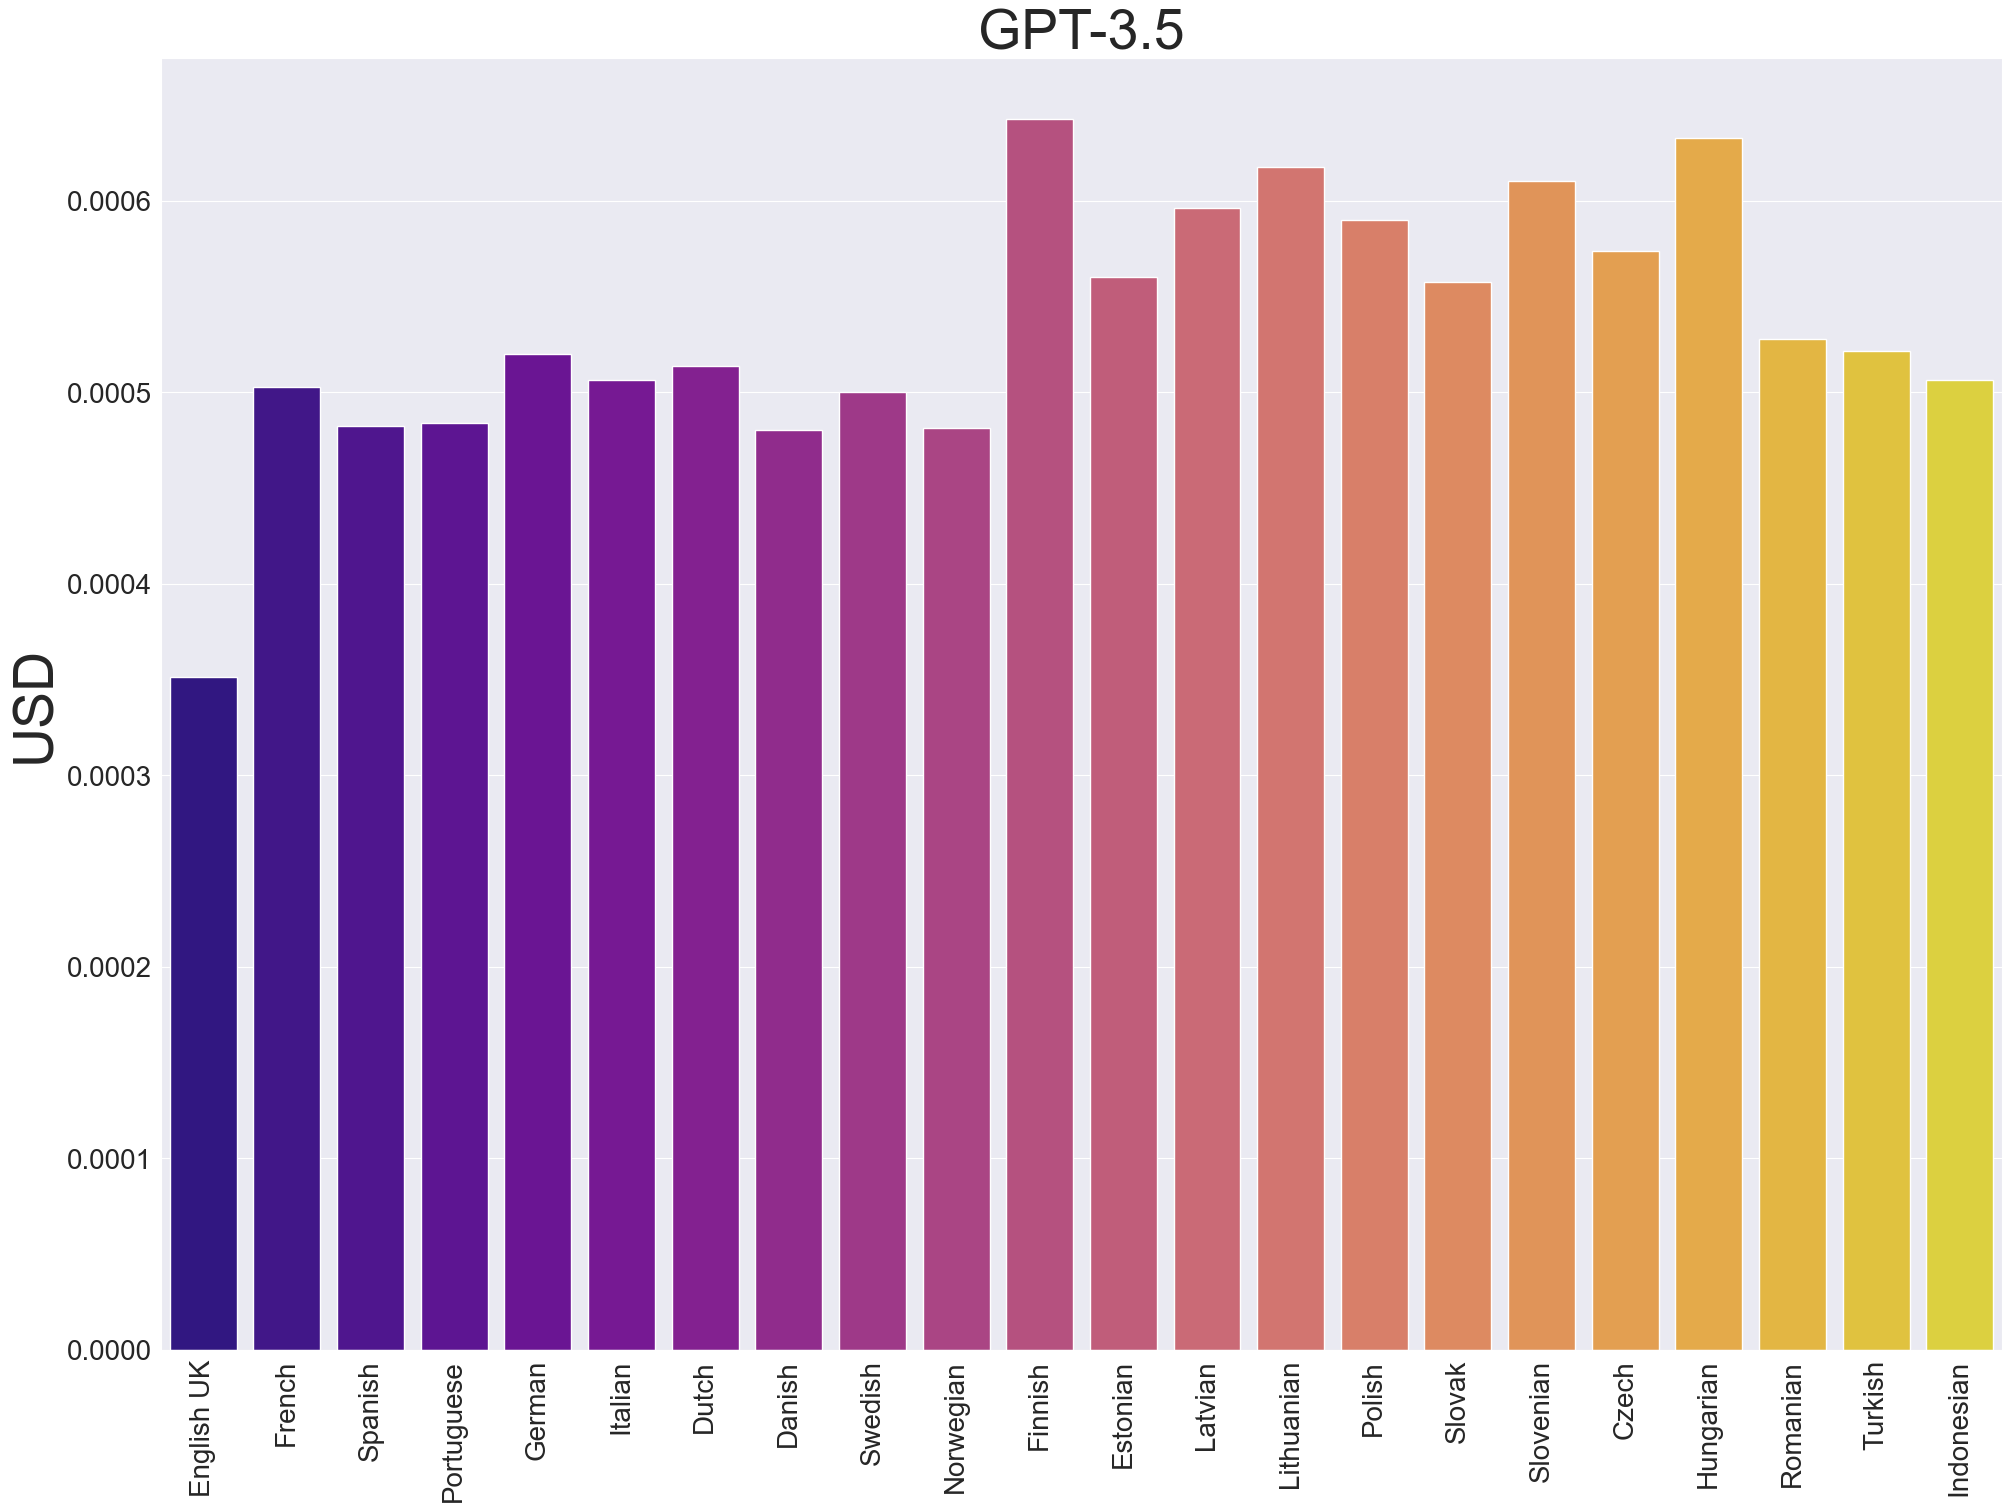

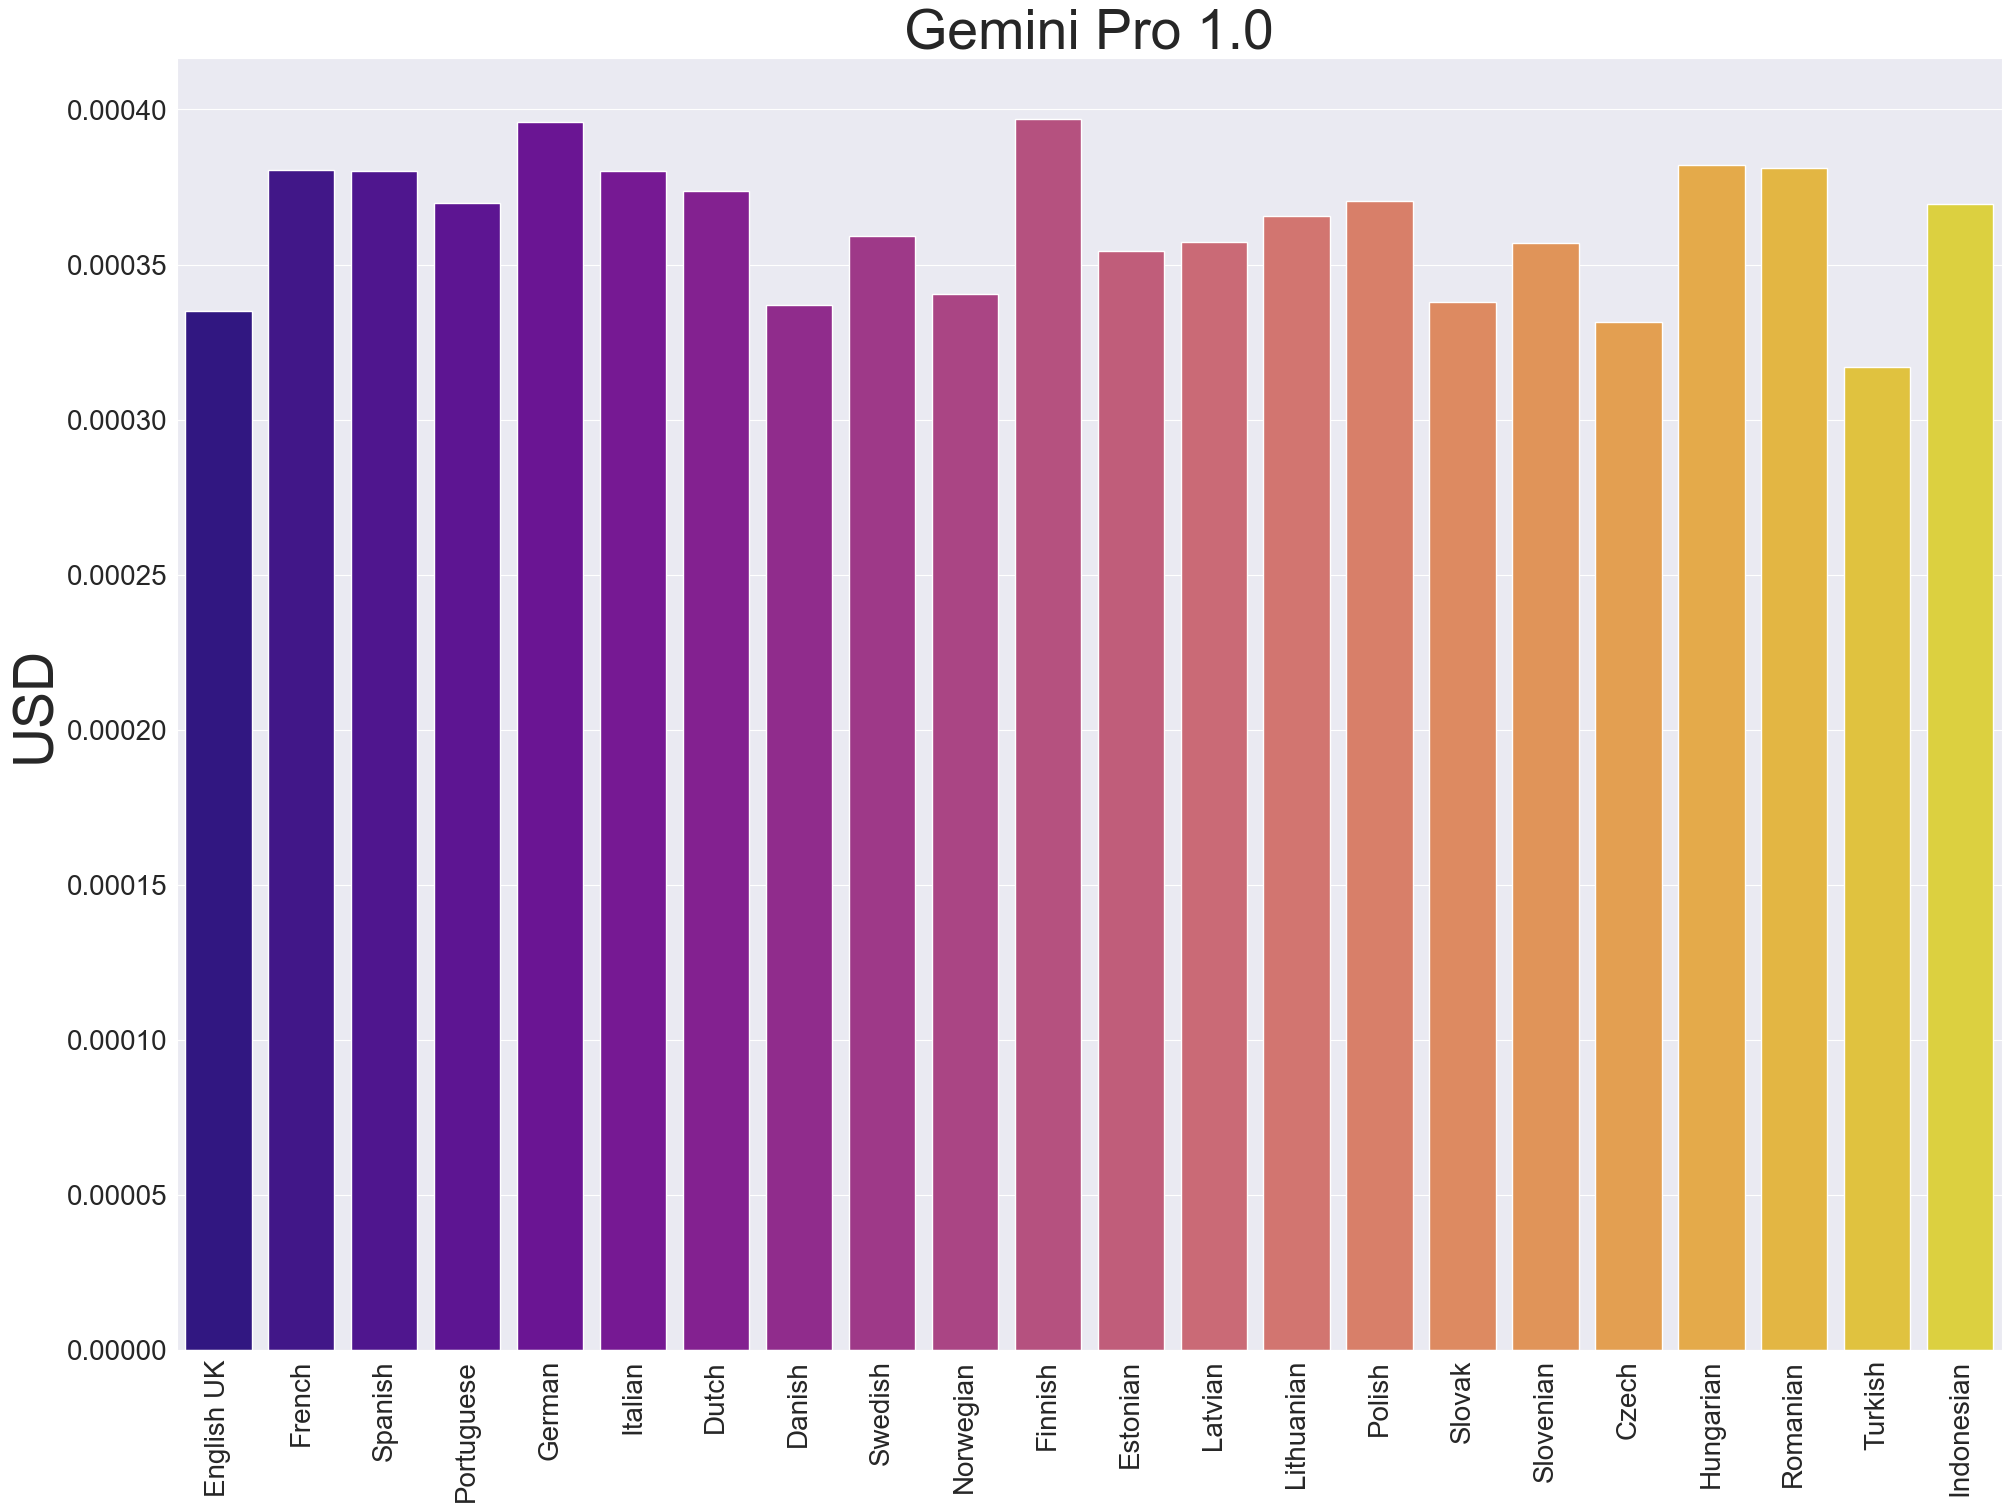

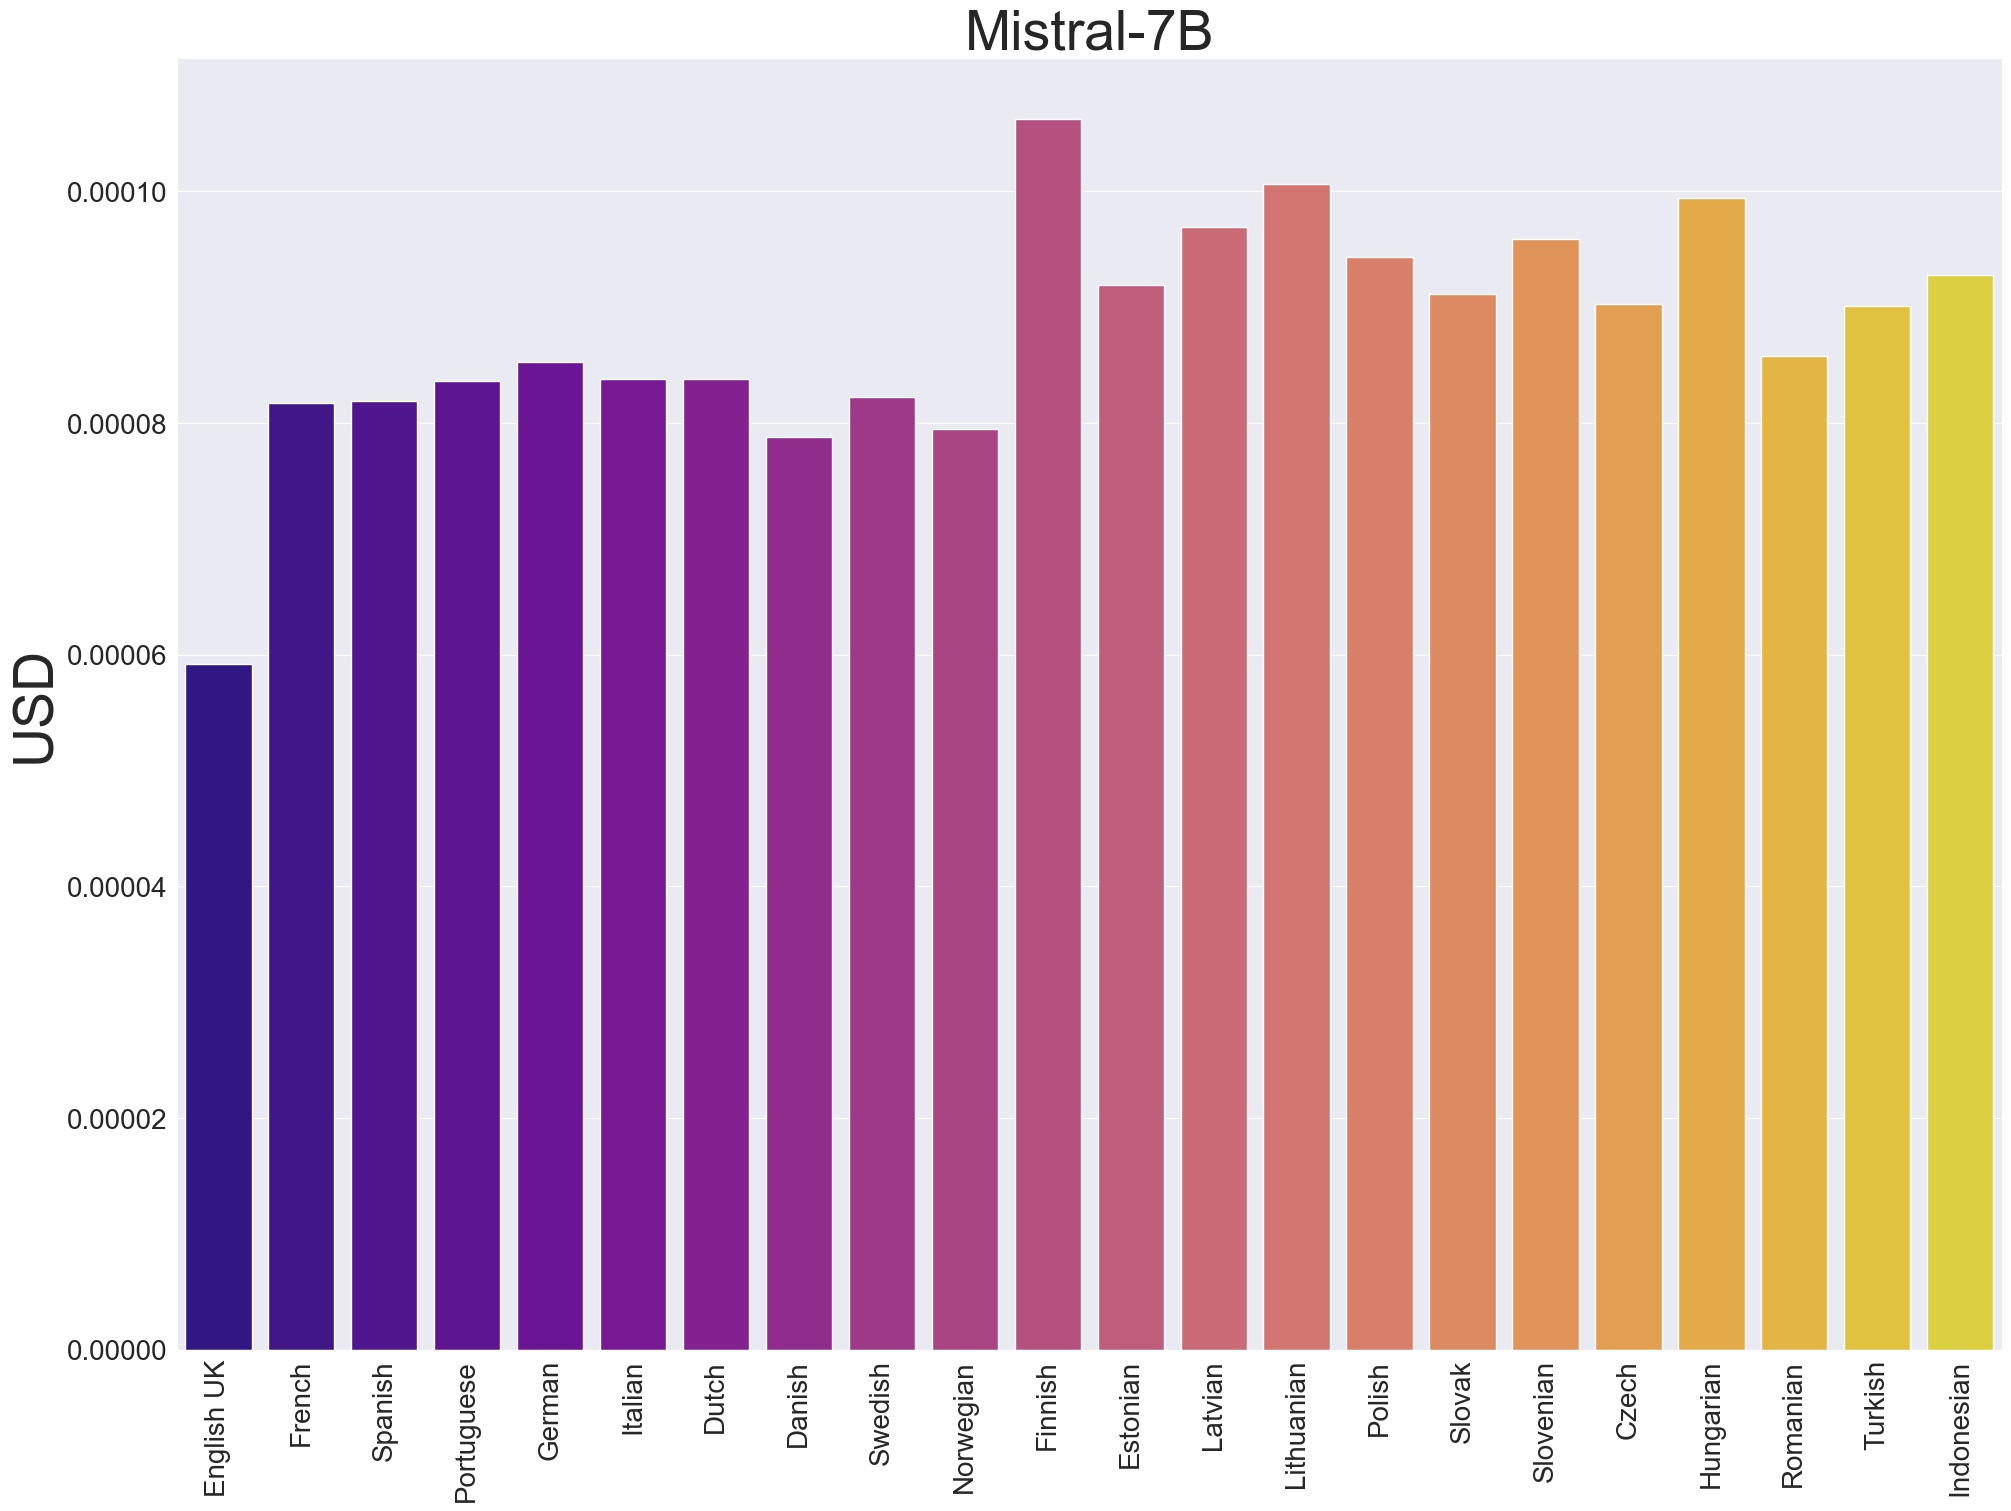

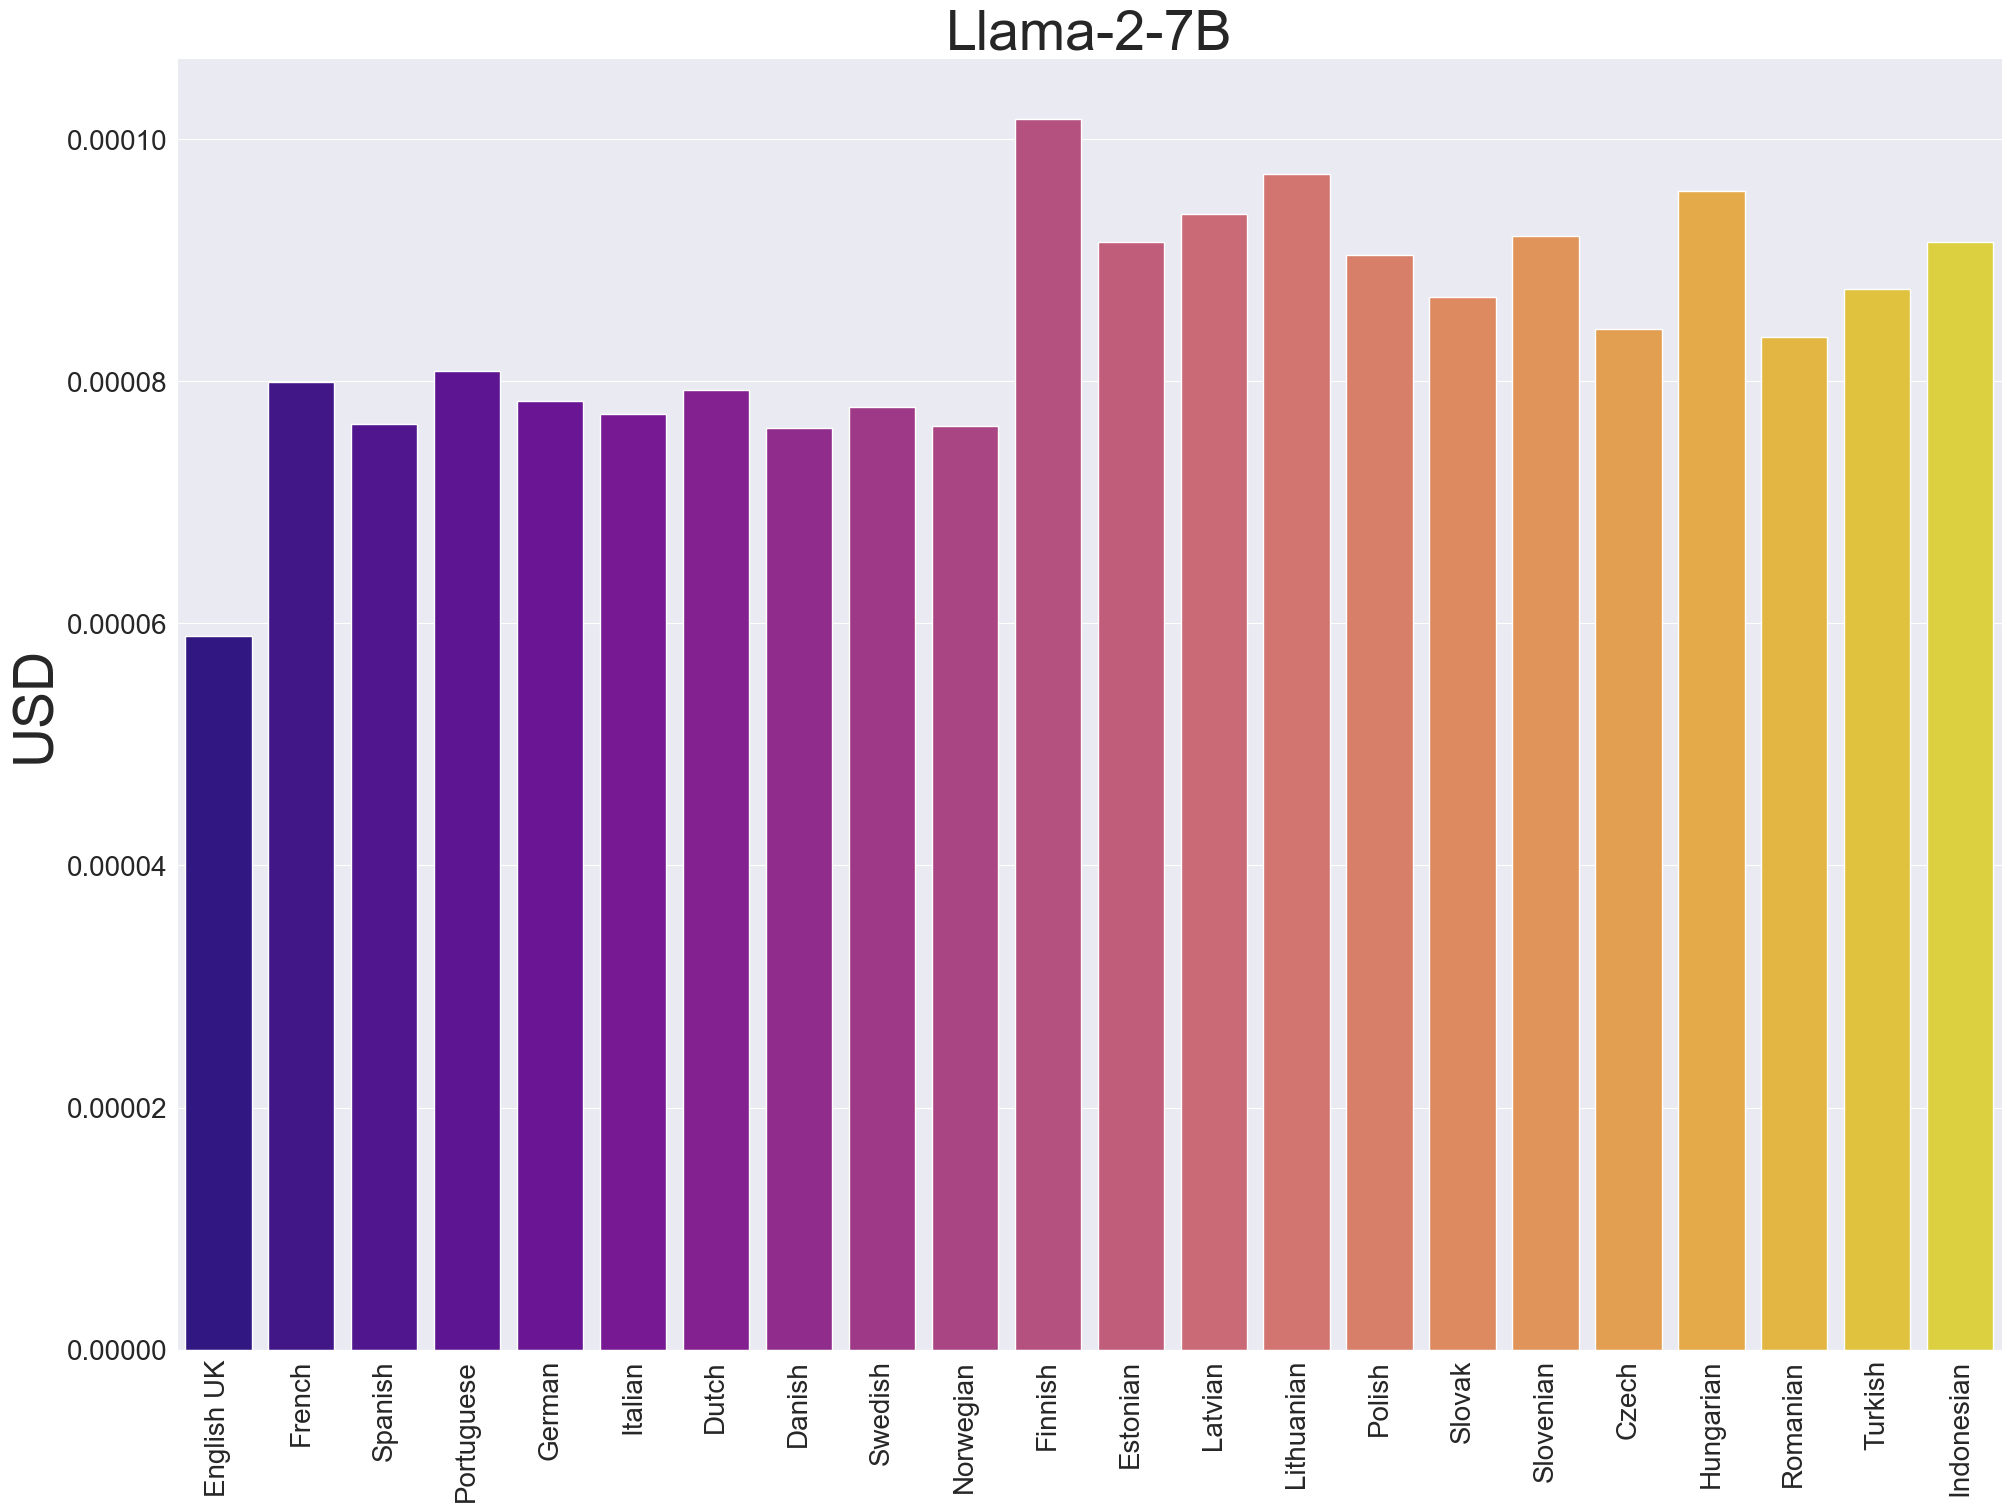

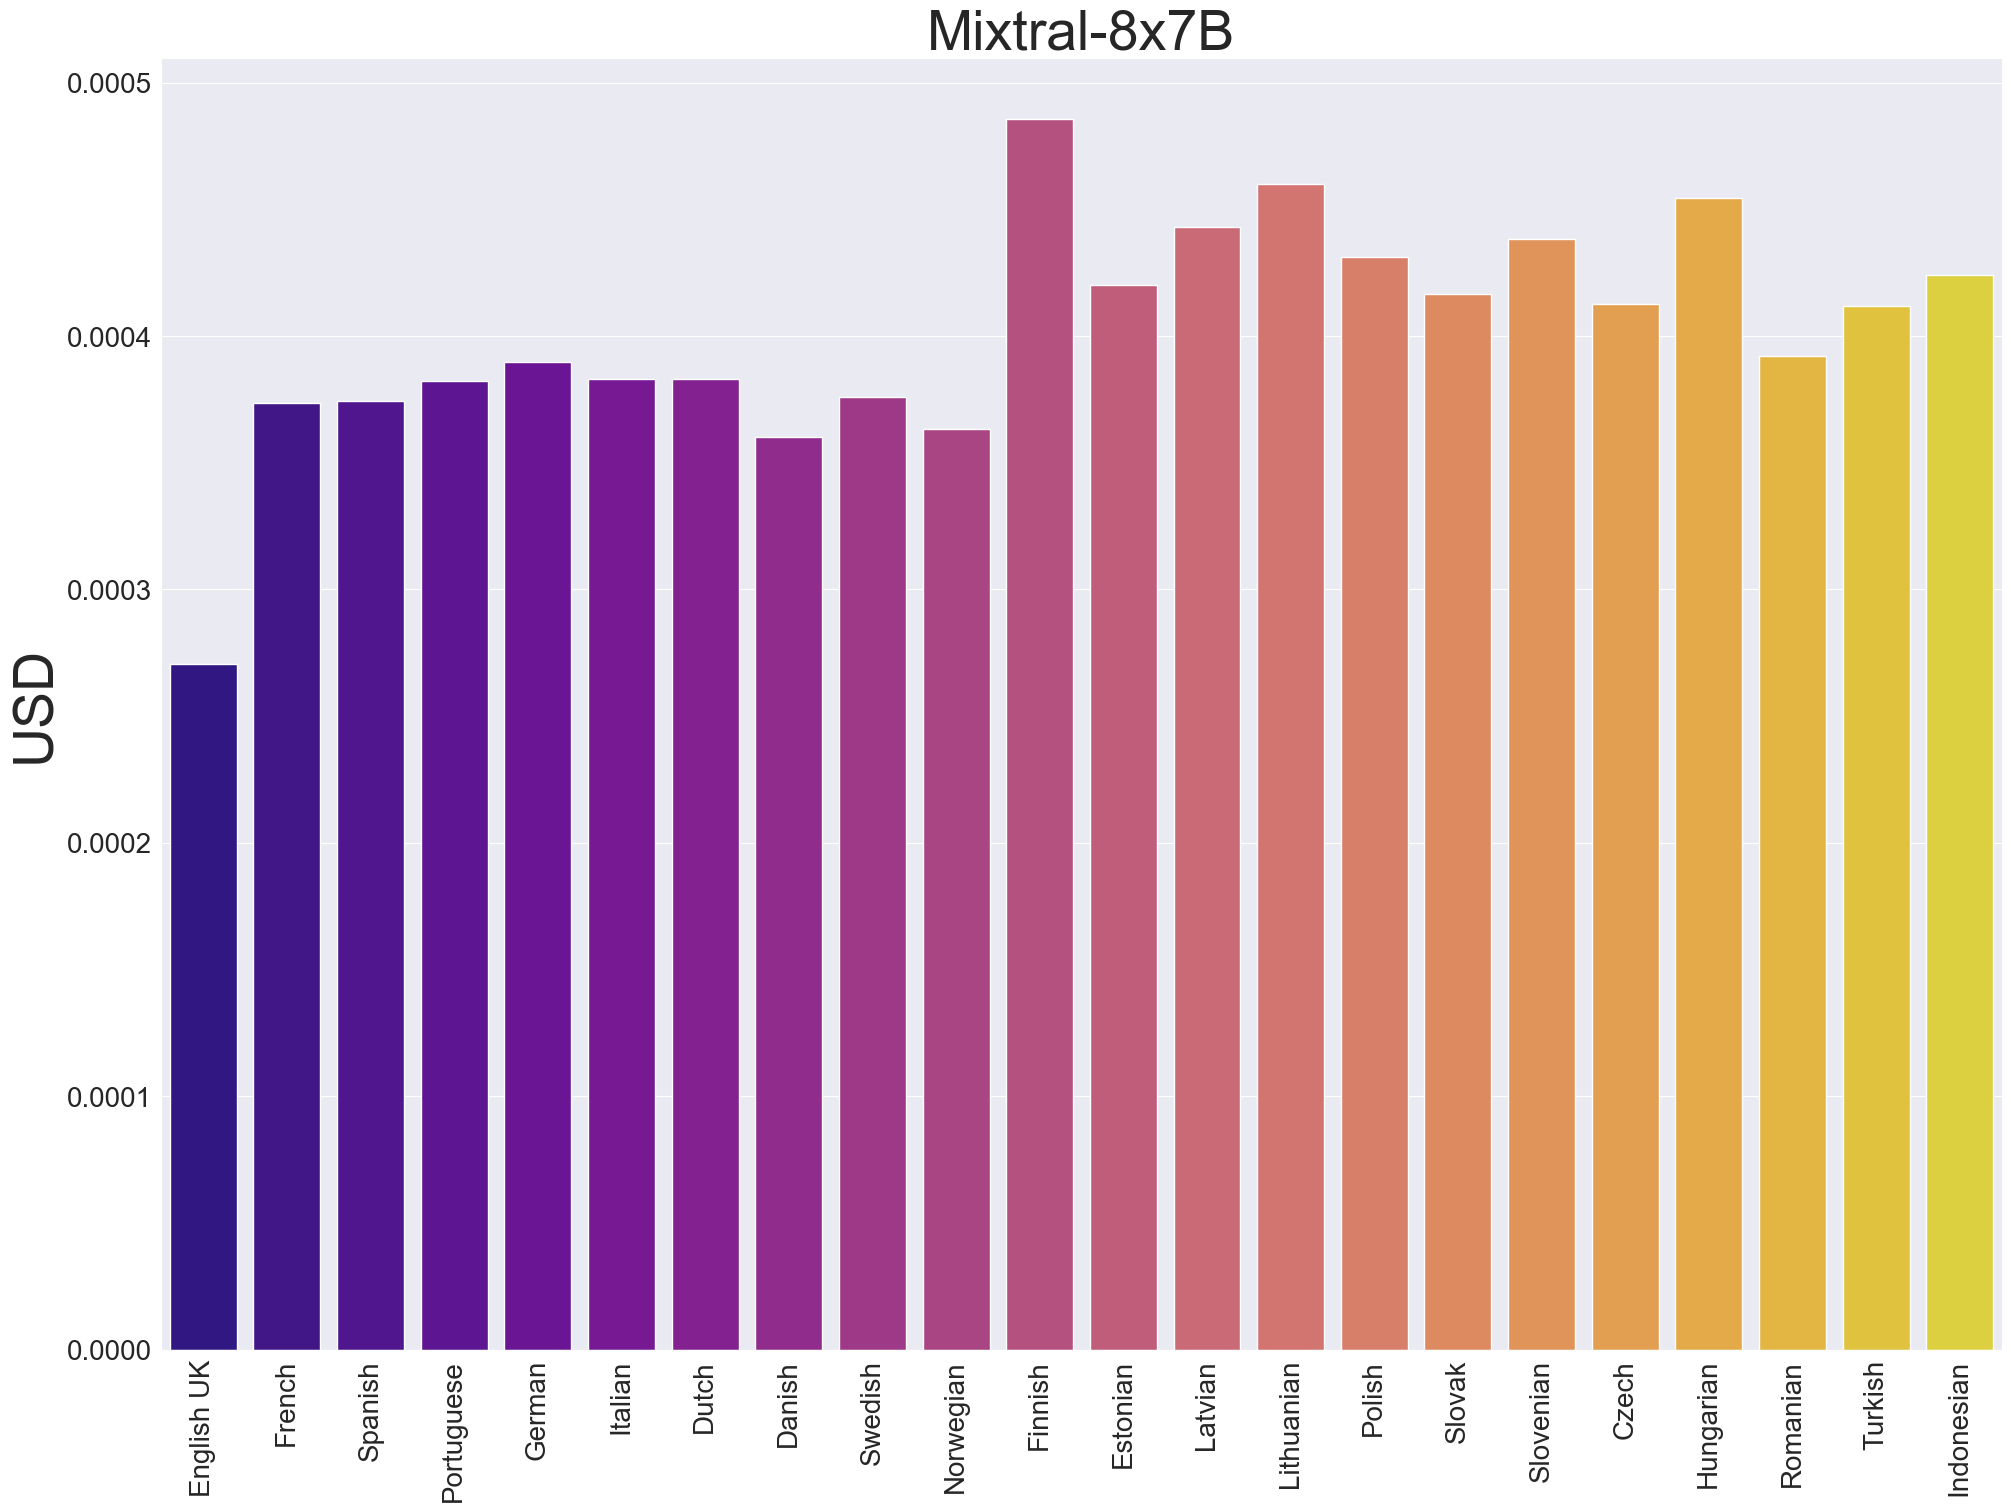

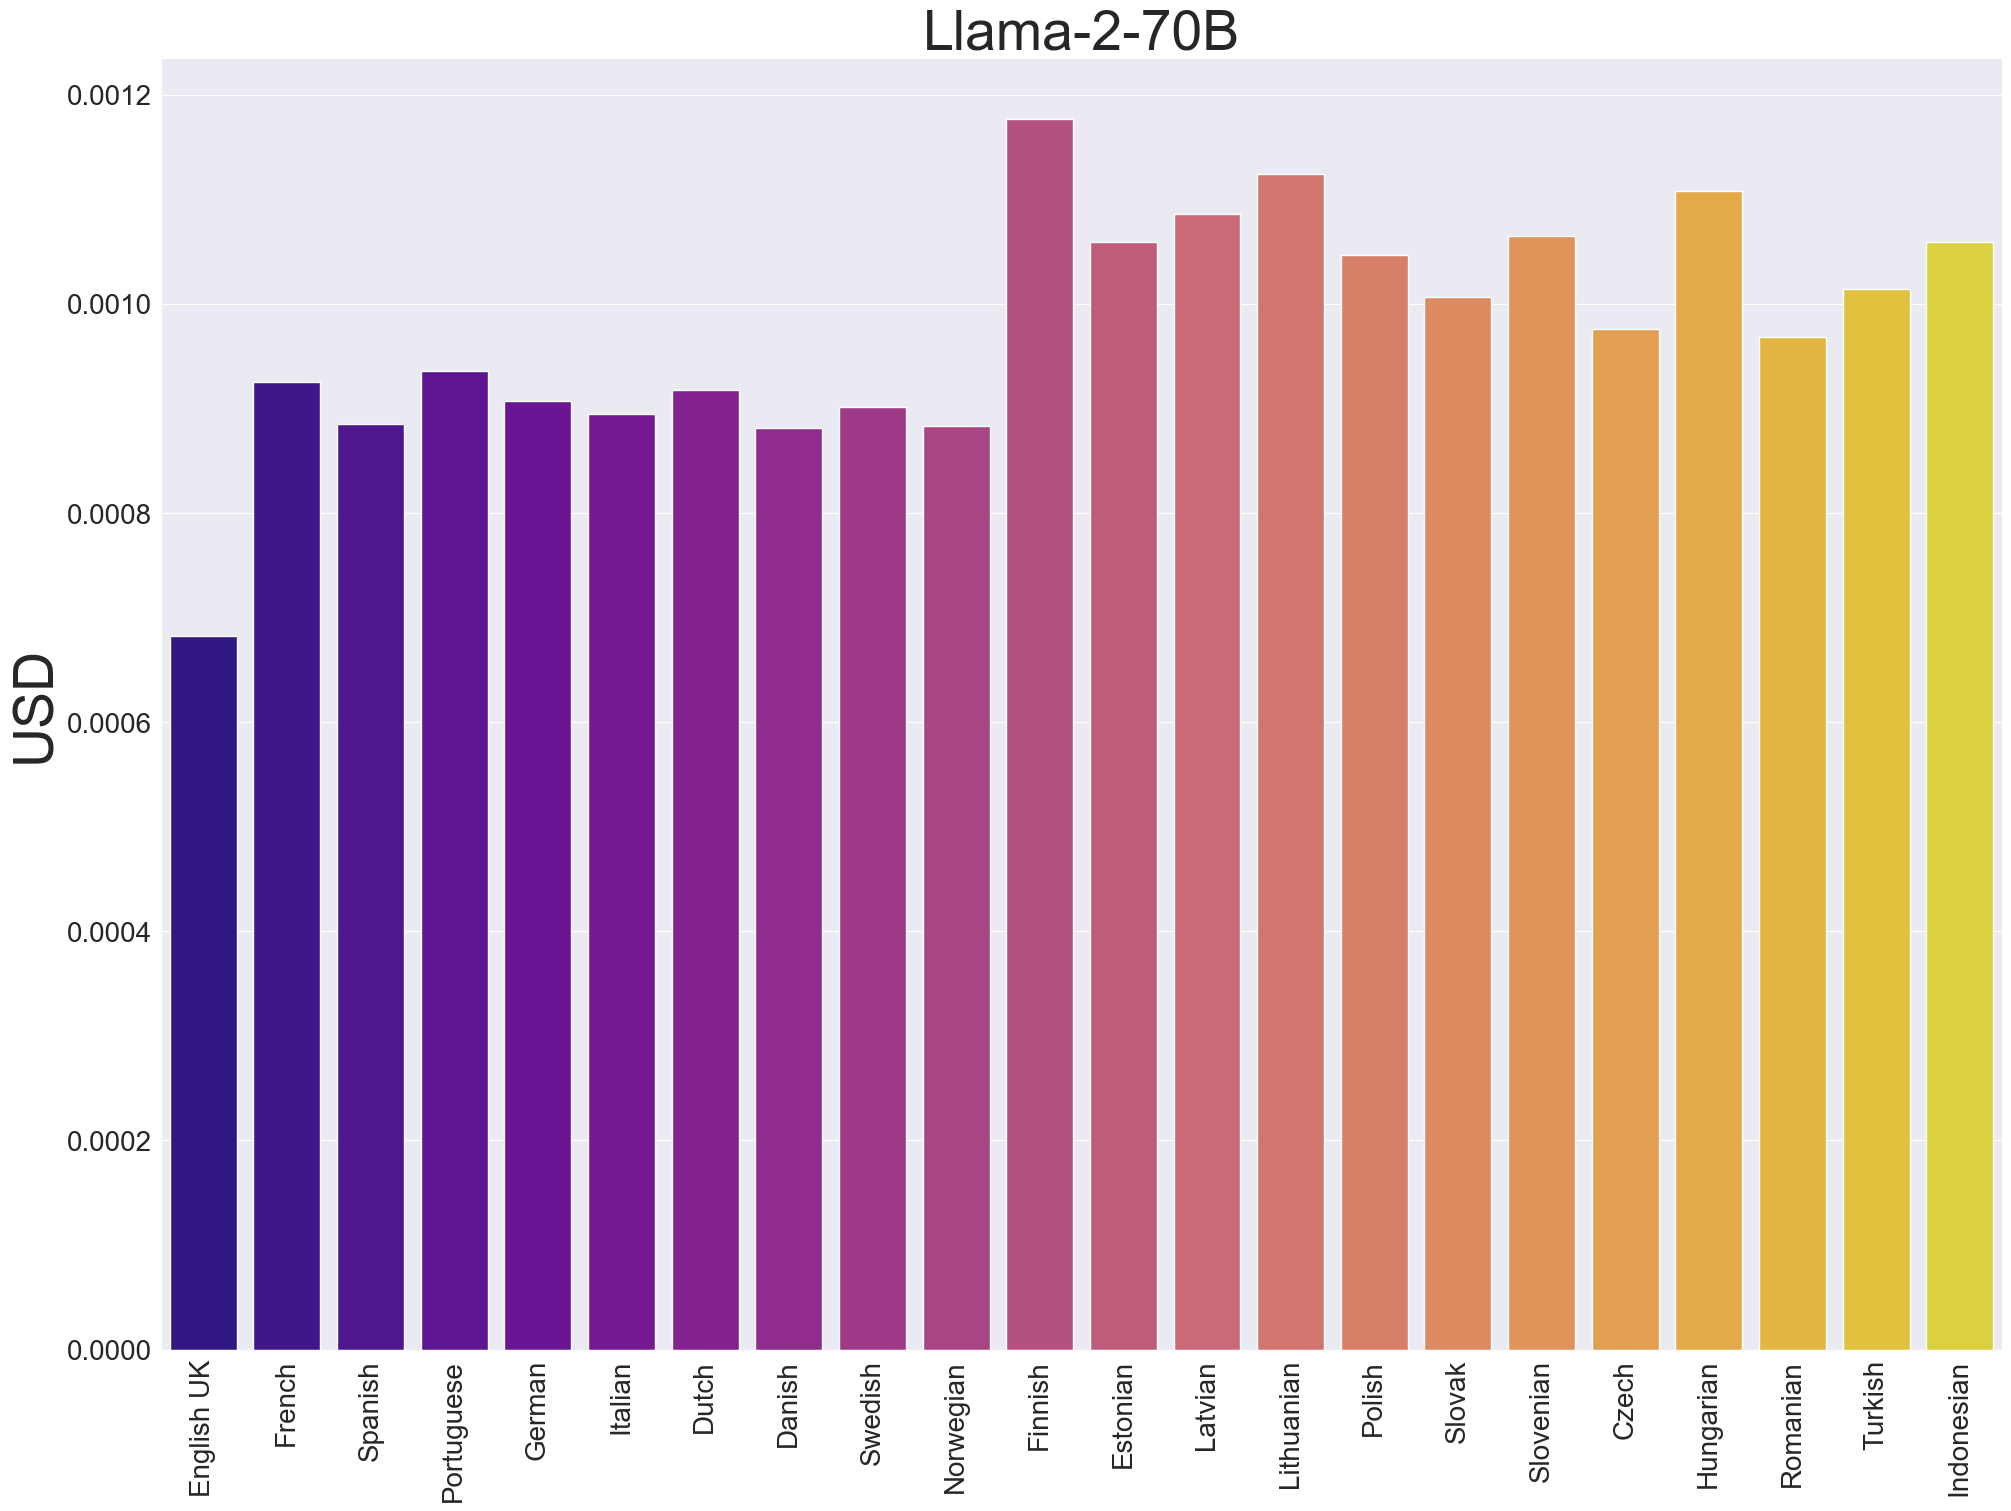

In [14]:
plot_model_lang_distributions(
    processing_cost_original_text_without_gpt4_no_special_characters,
    "plots_token/processing_cost_without_gpt4_no_special_chars.png",
    "USD",
    num_rows=2
)

plot_as_separate_charts(
    processing_cost_original_text_without_gpt4_no_special_characters,
    "plots_token/processing_cost_without_gpt4_no_special_chars.png",
    "USD",
)

# Removal of diacritics

* Impact is much bigger on GPT models

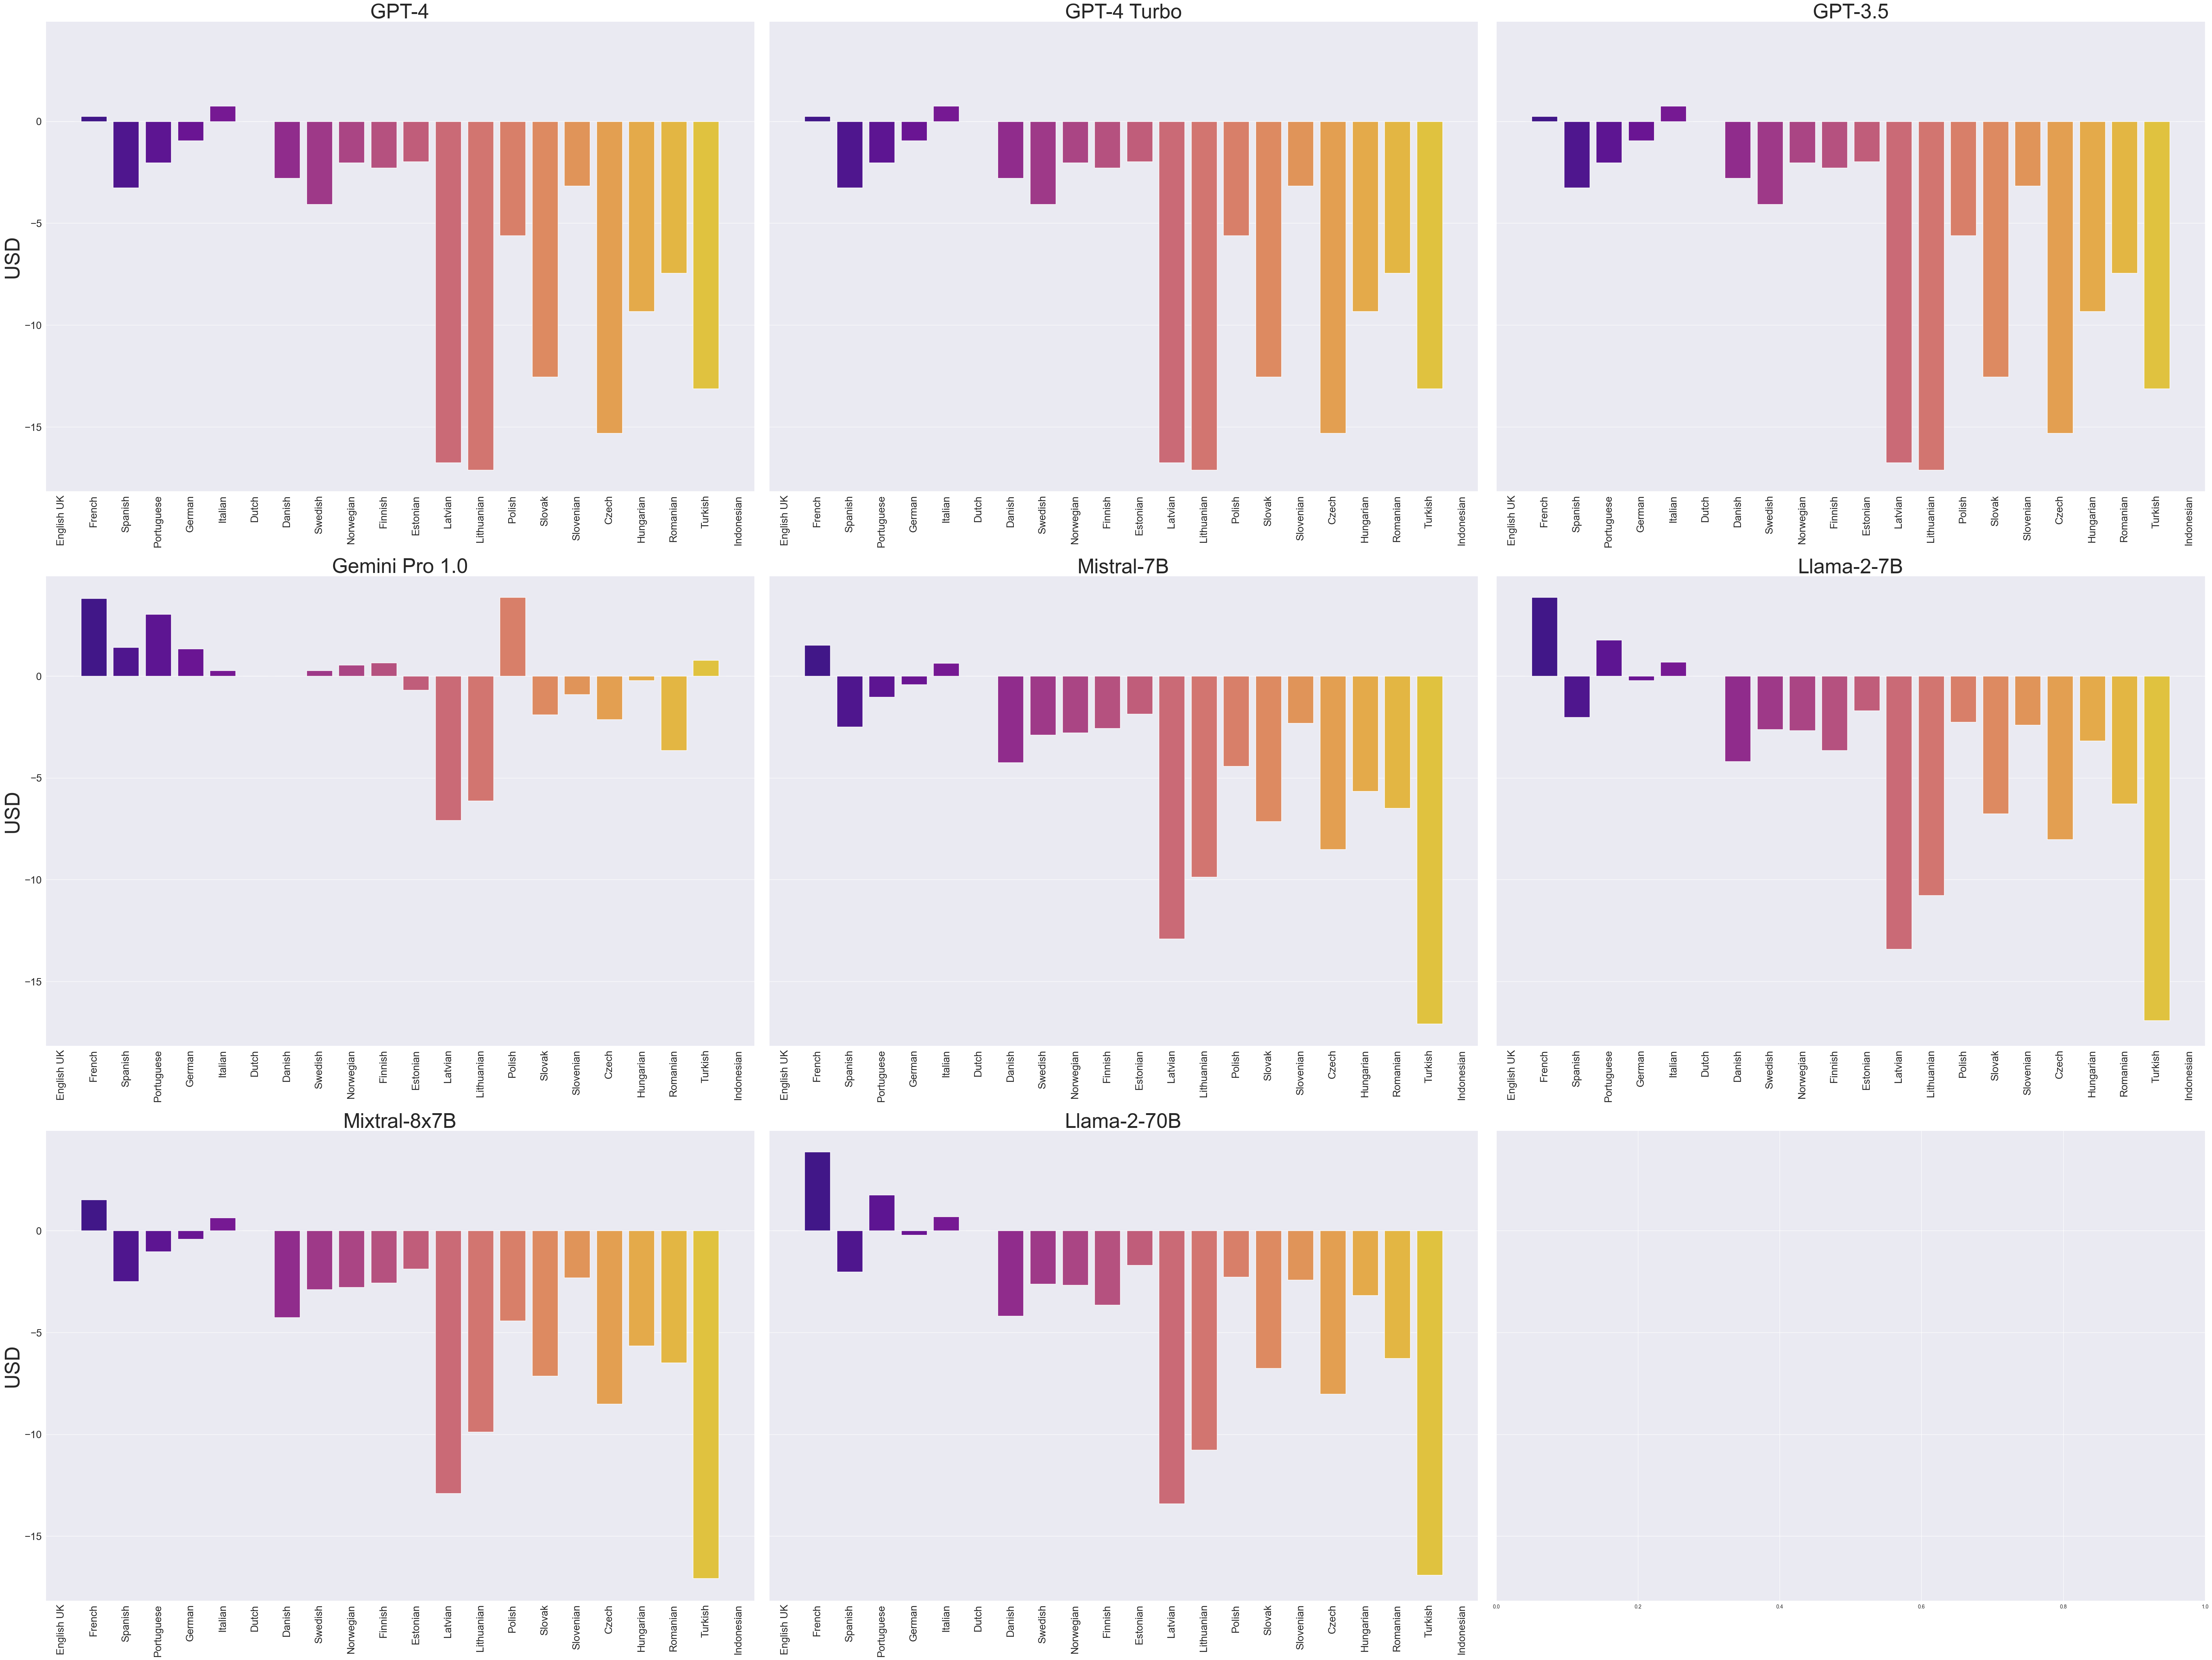

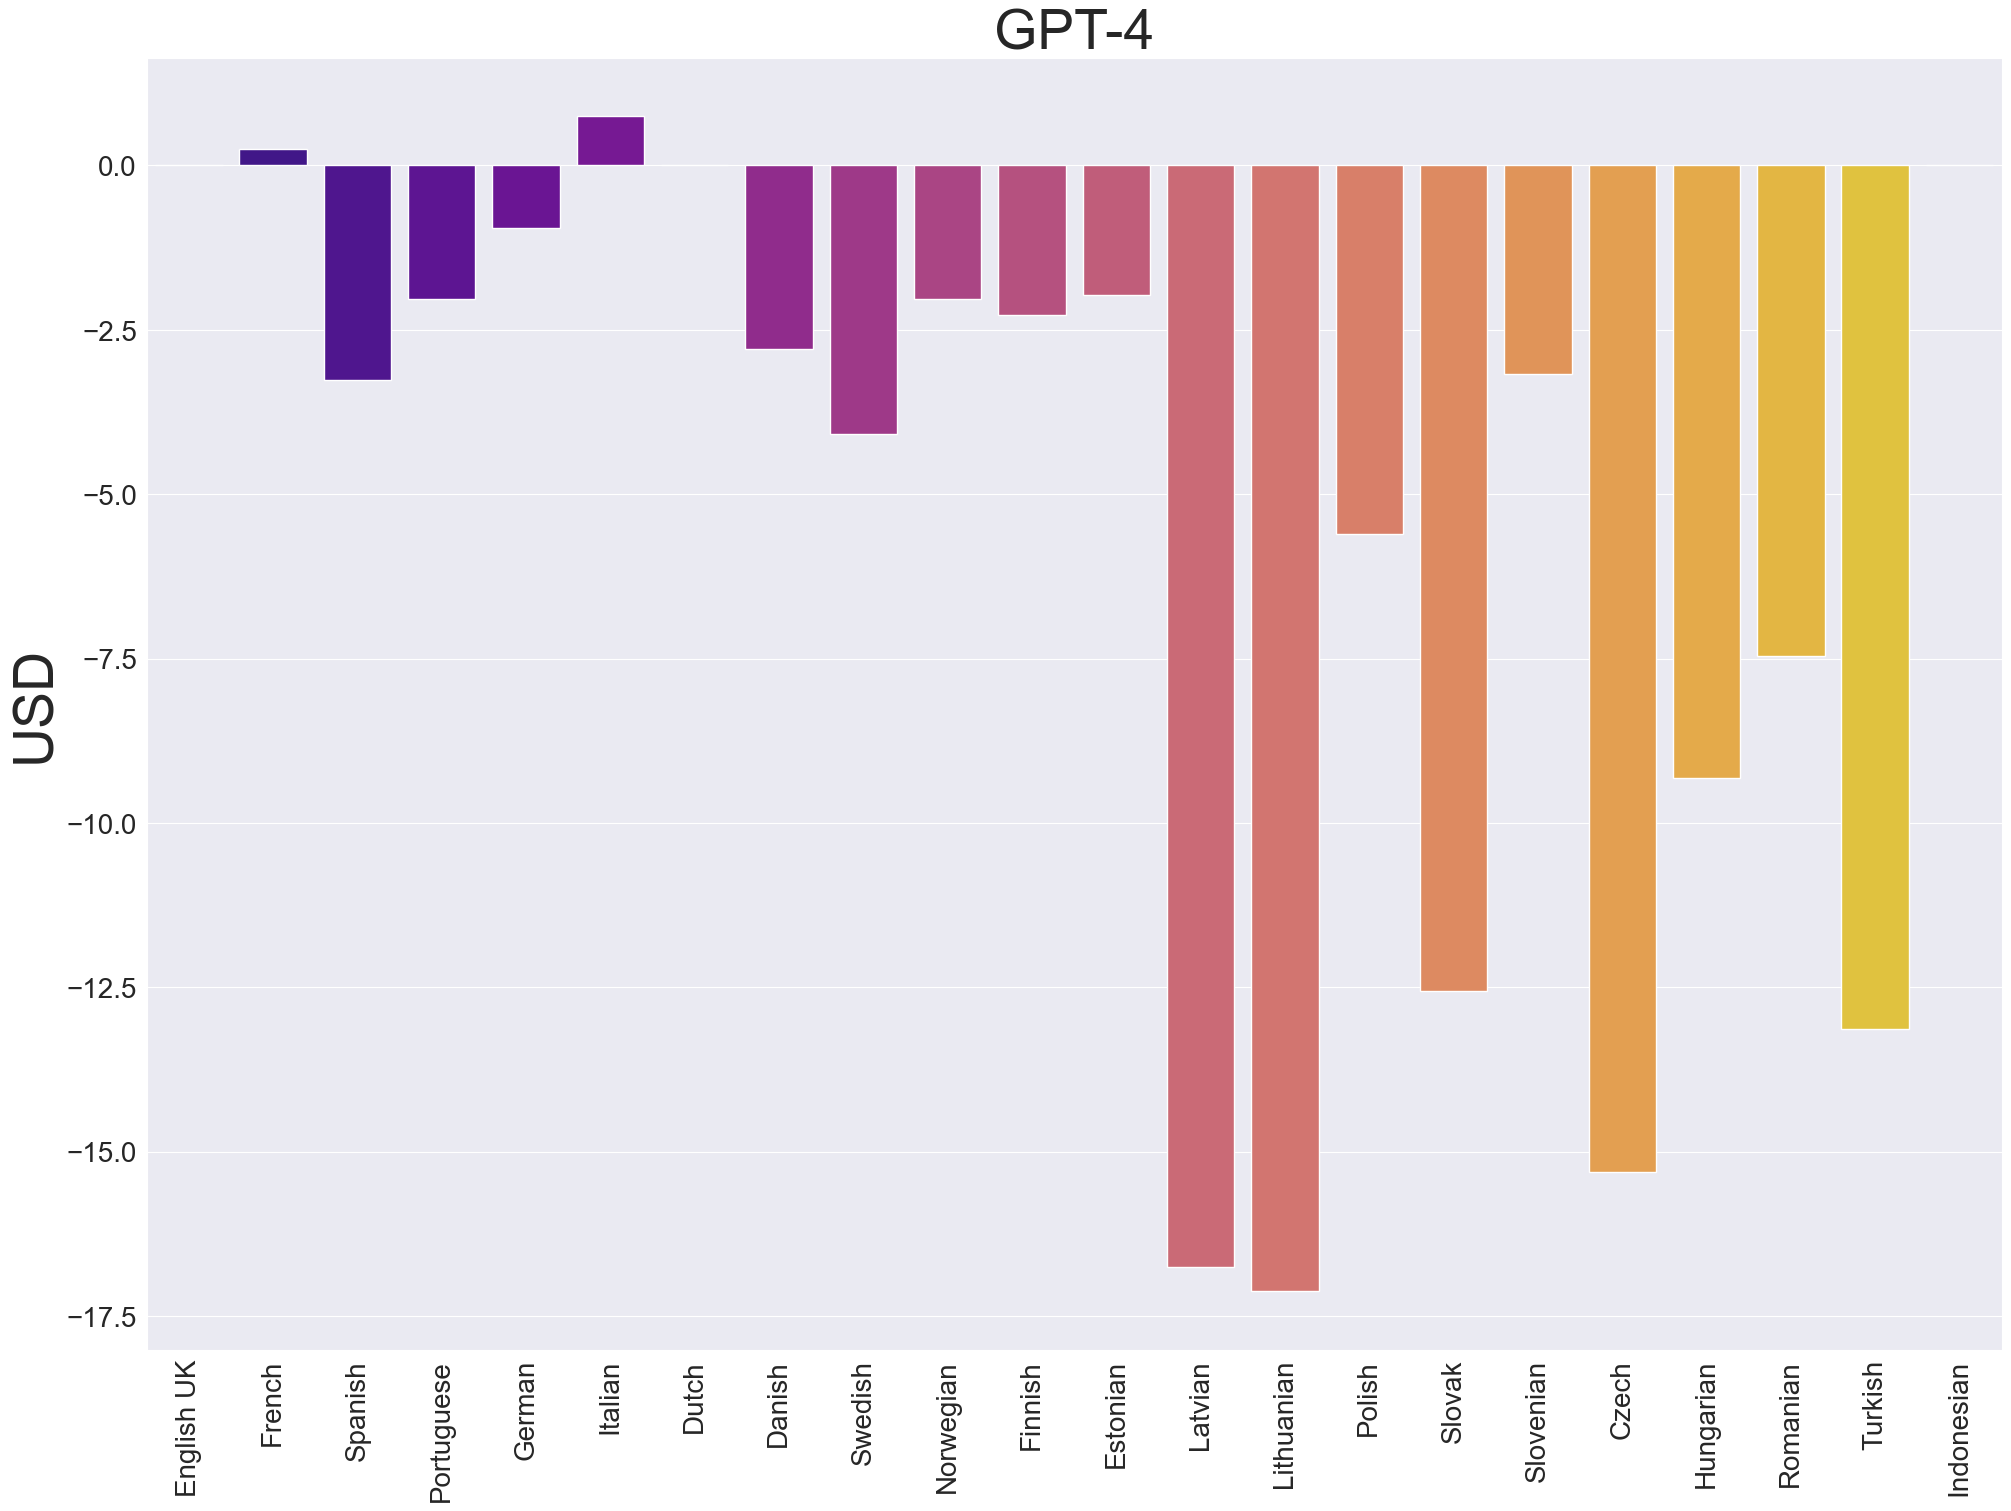

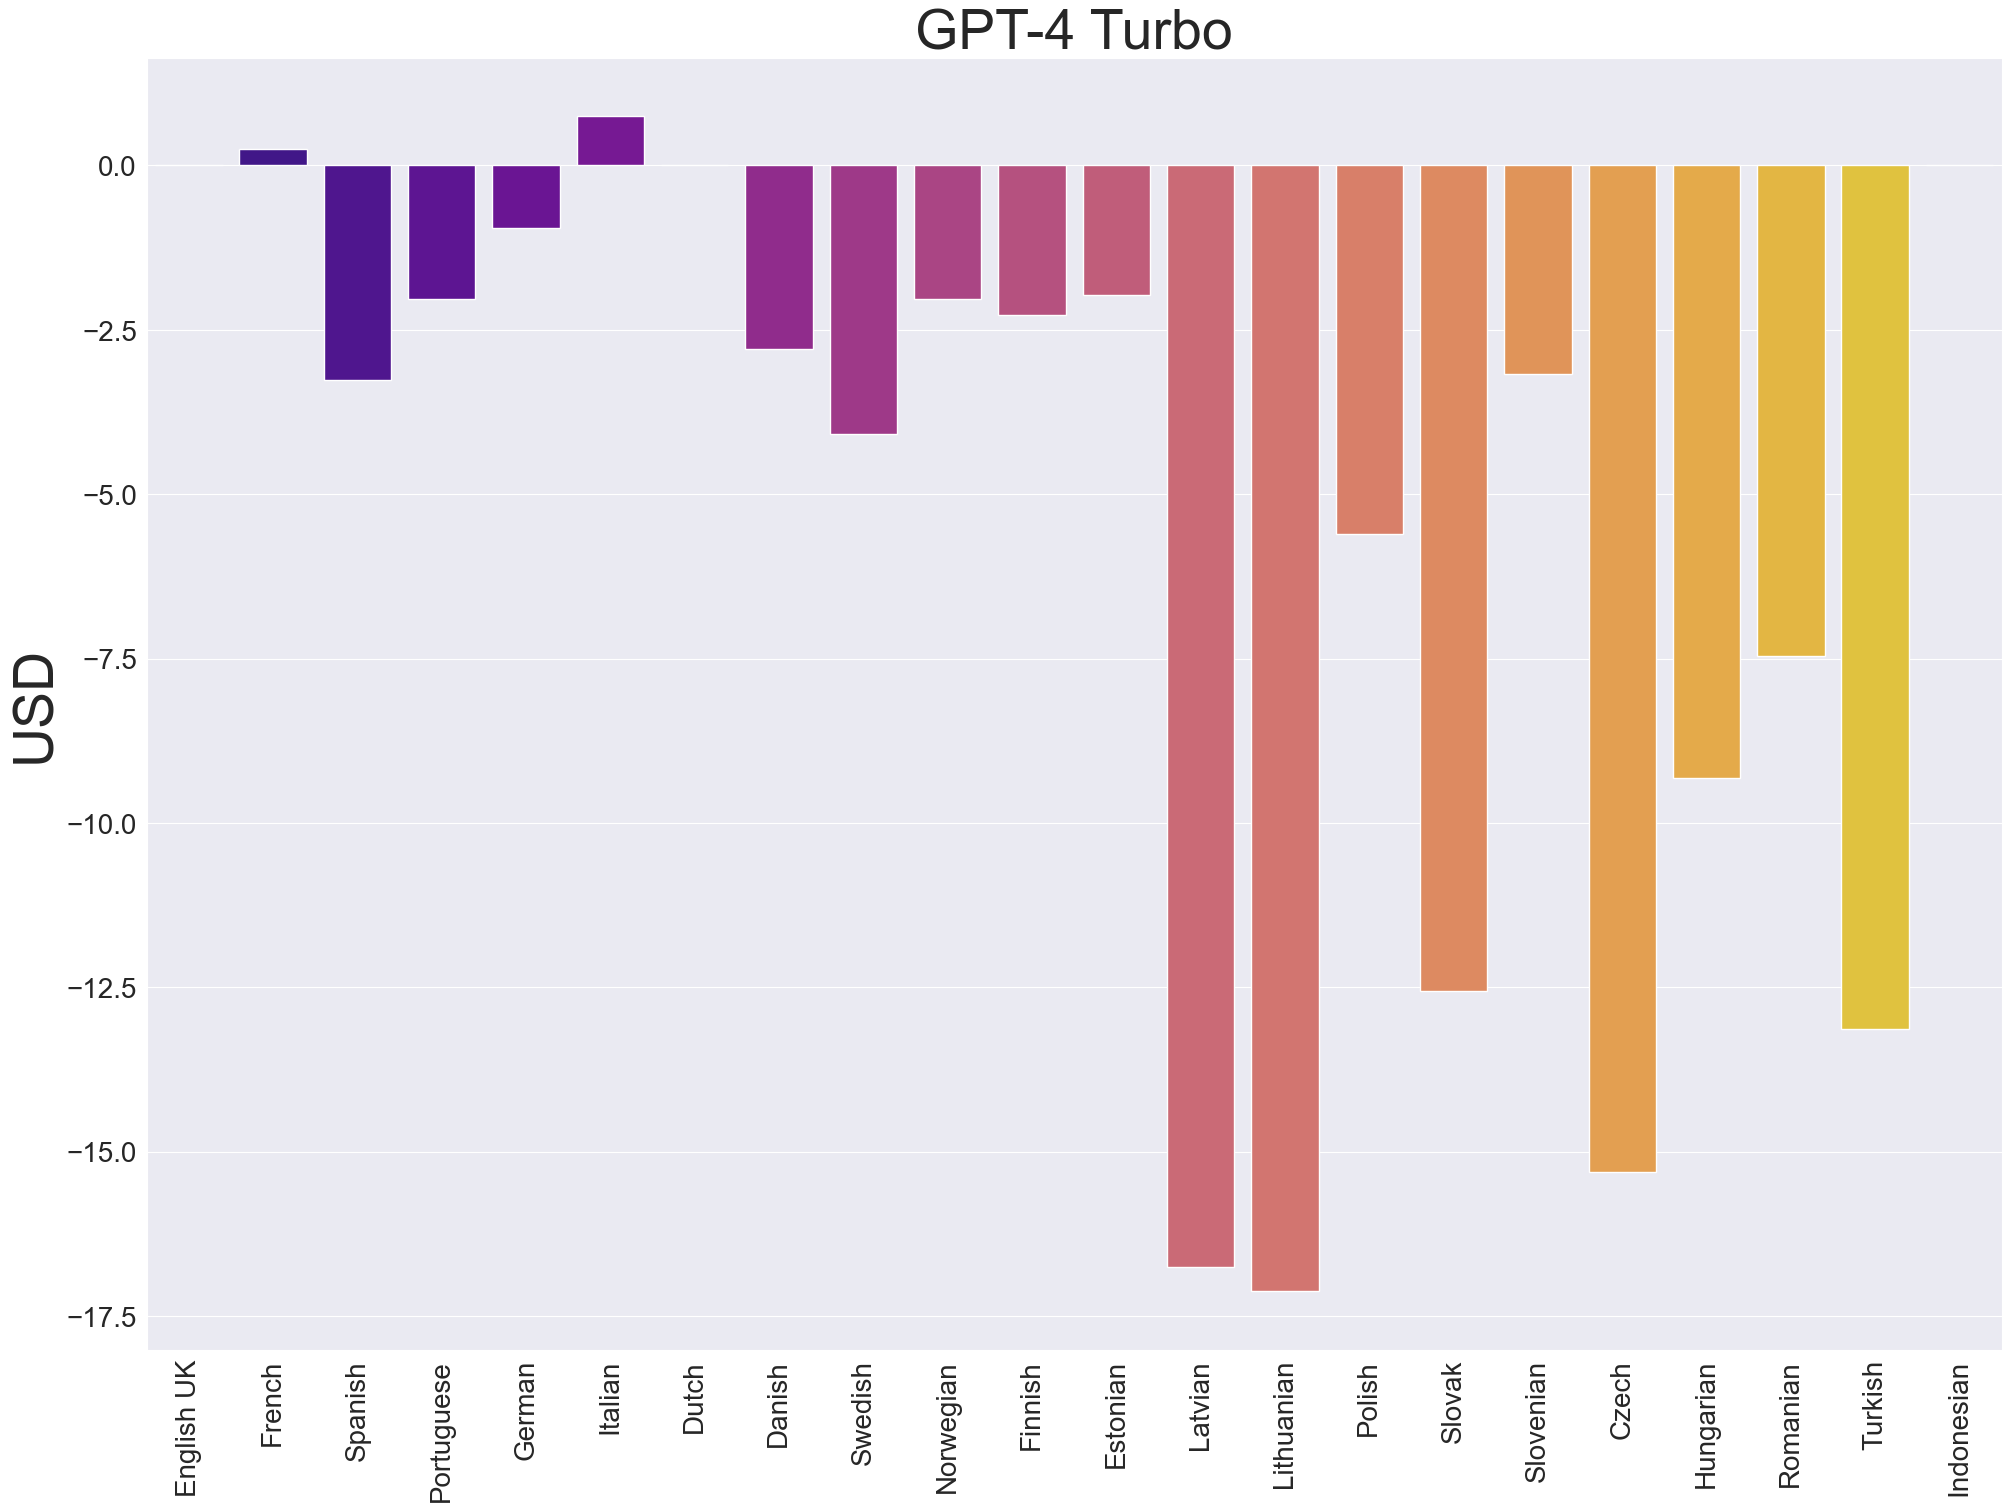

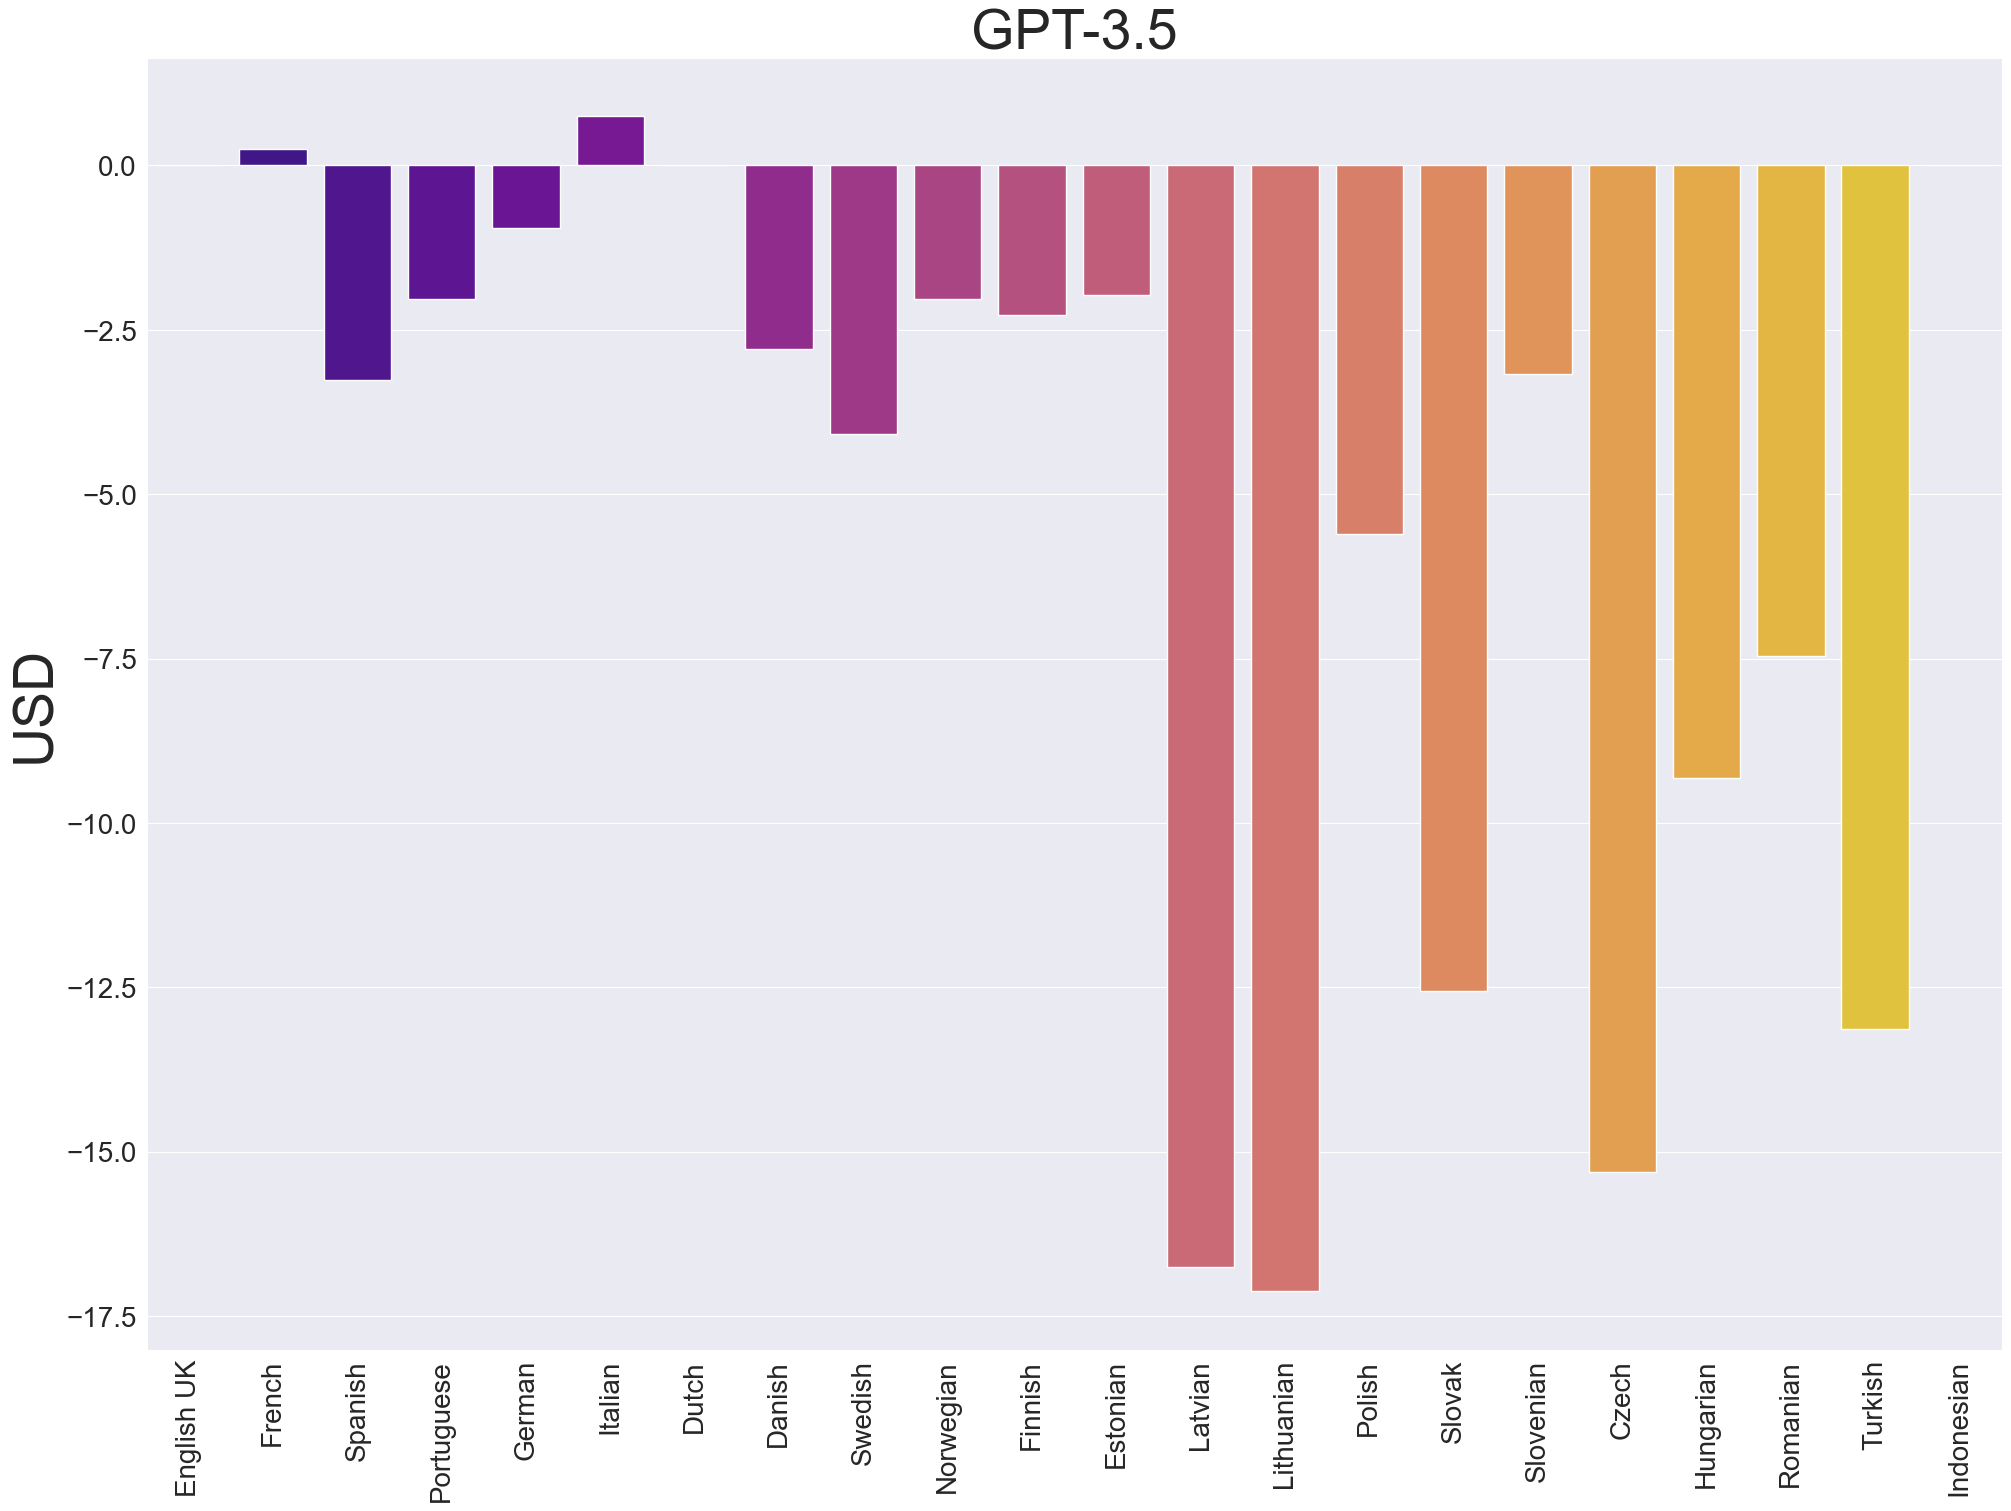

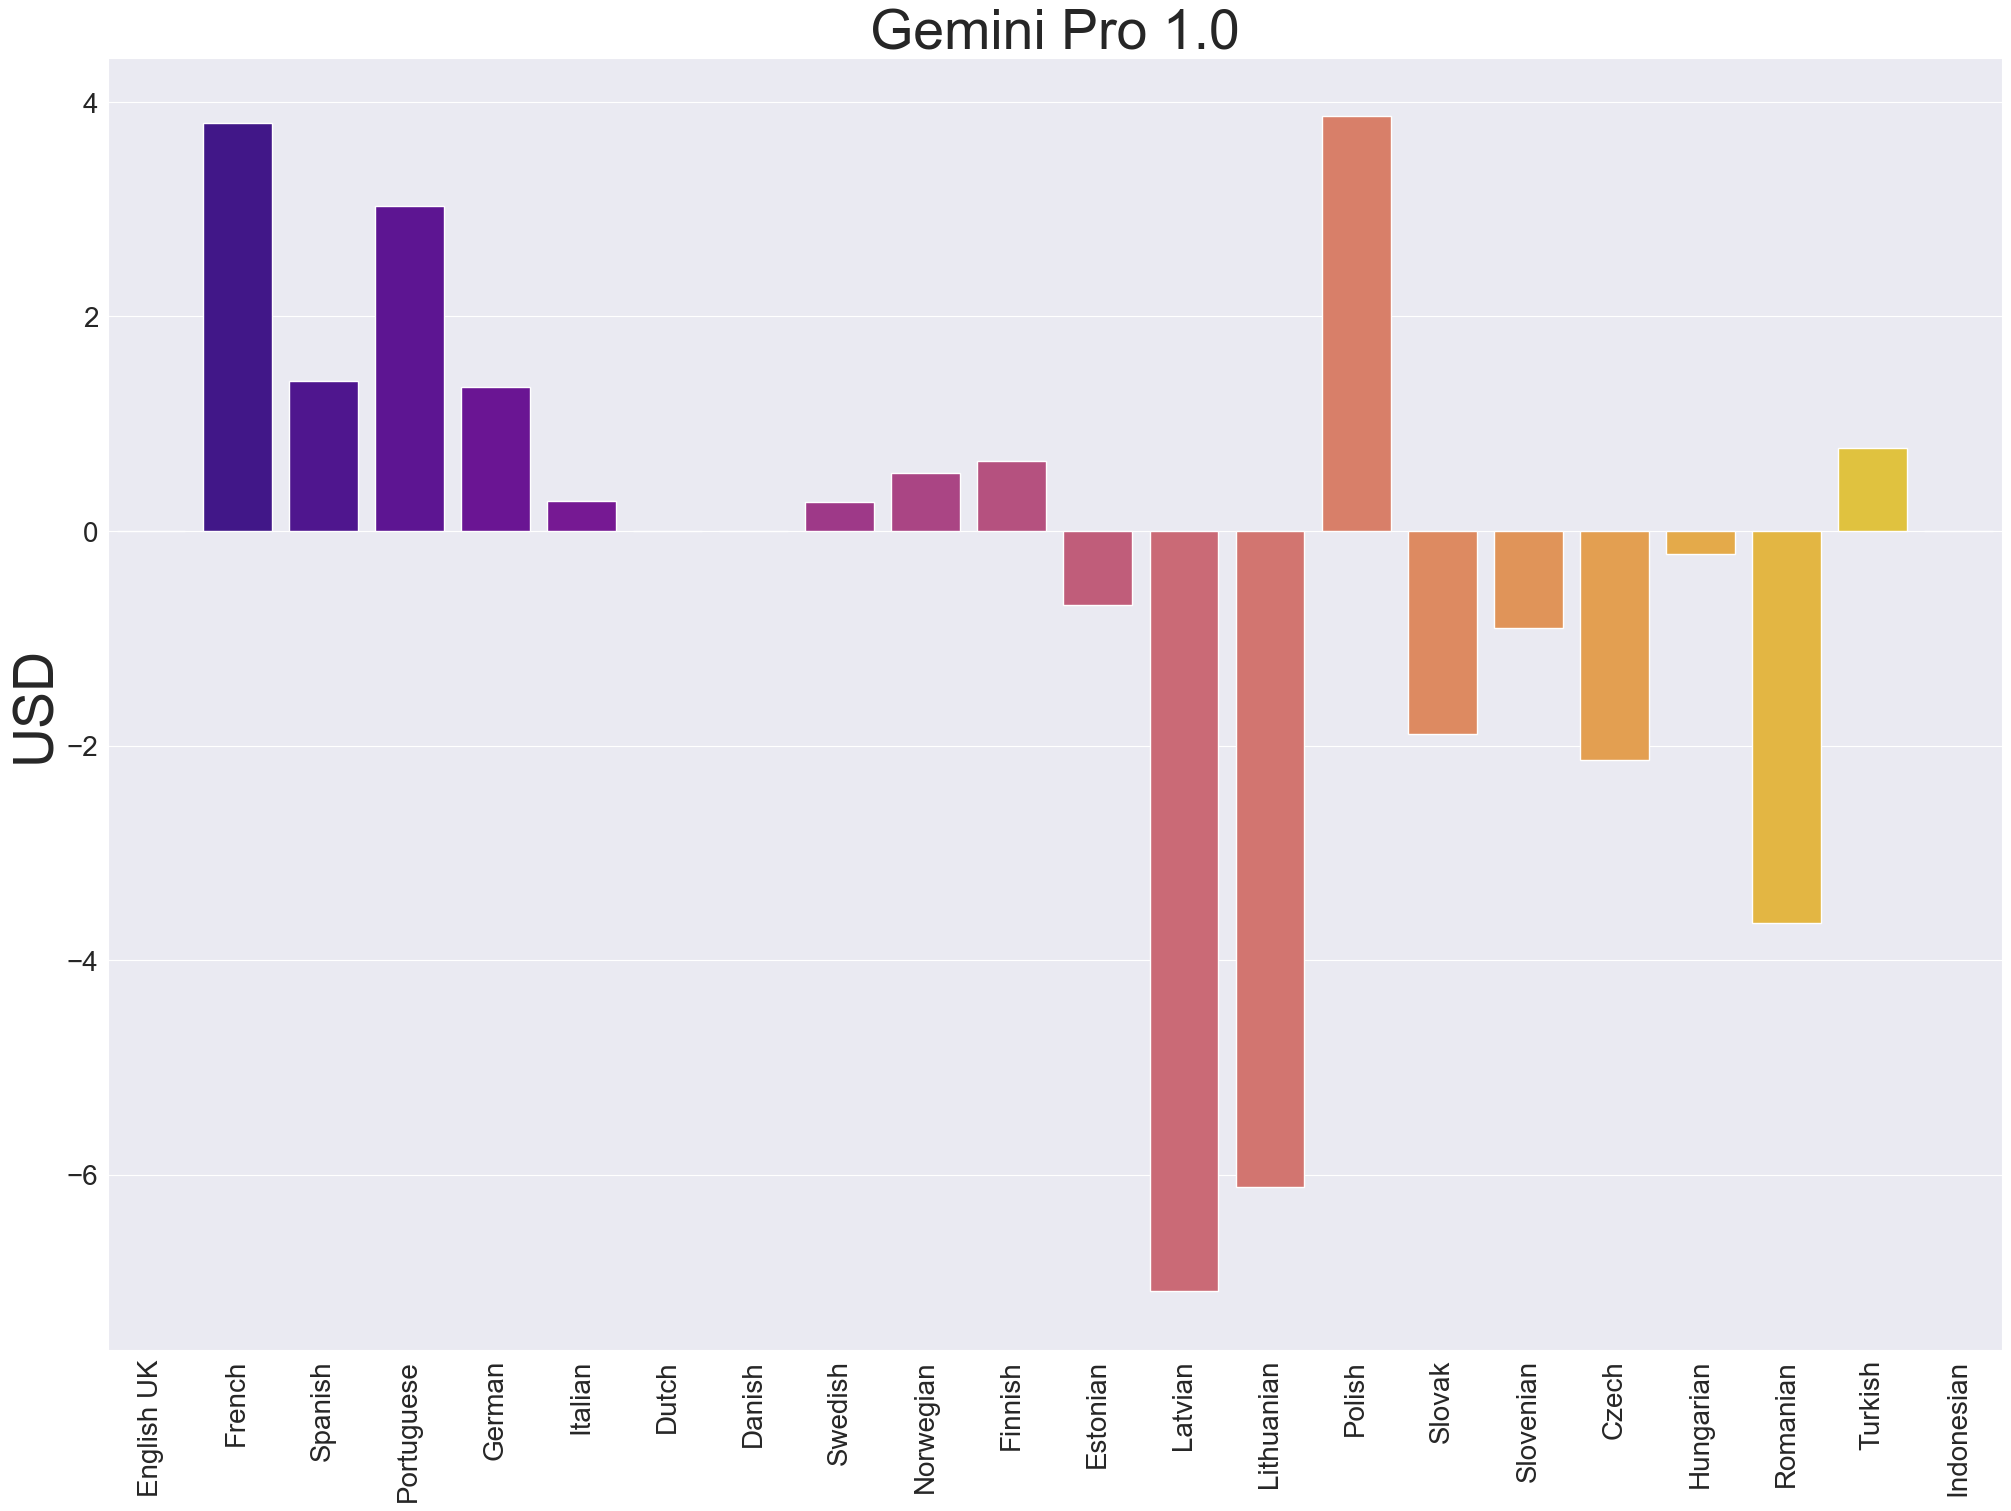

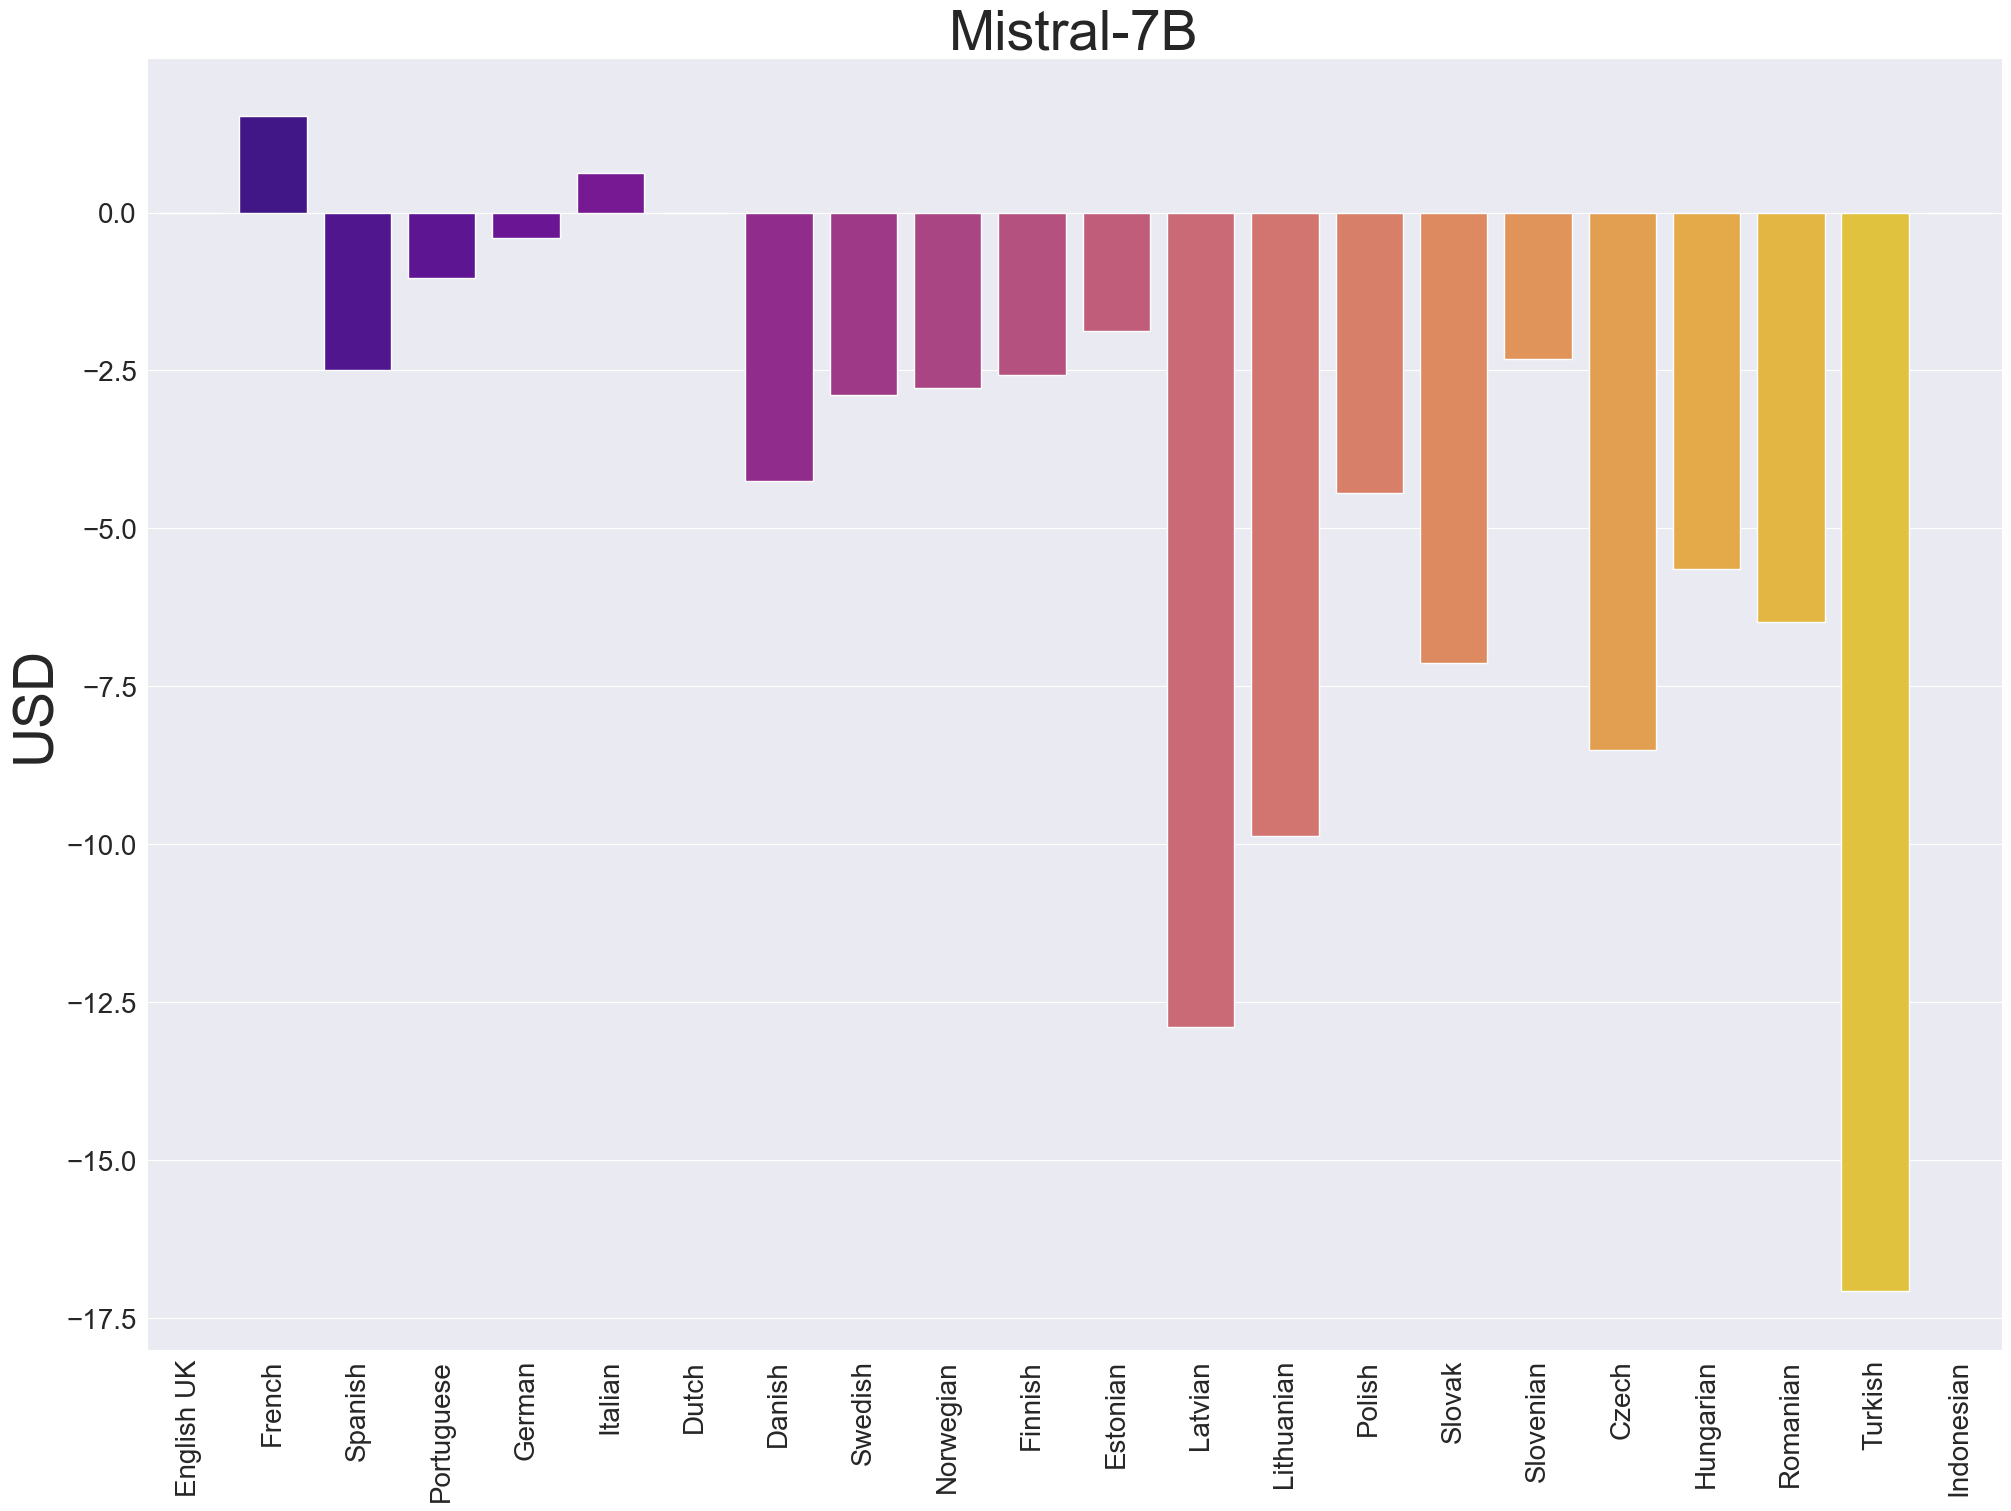

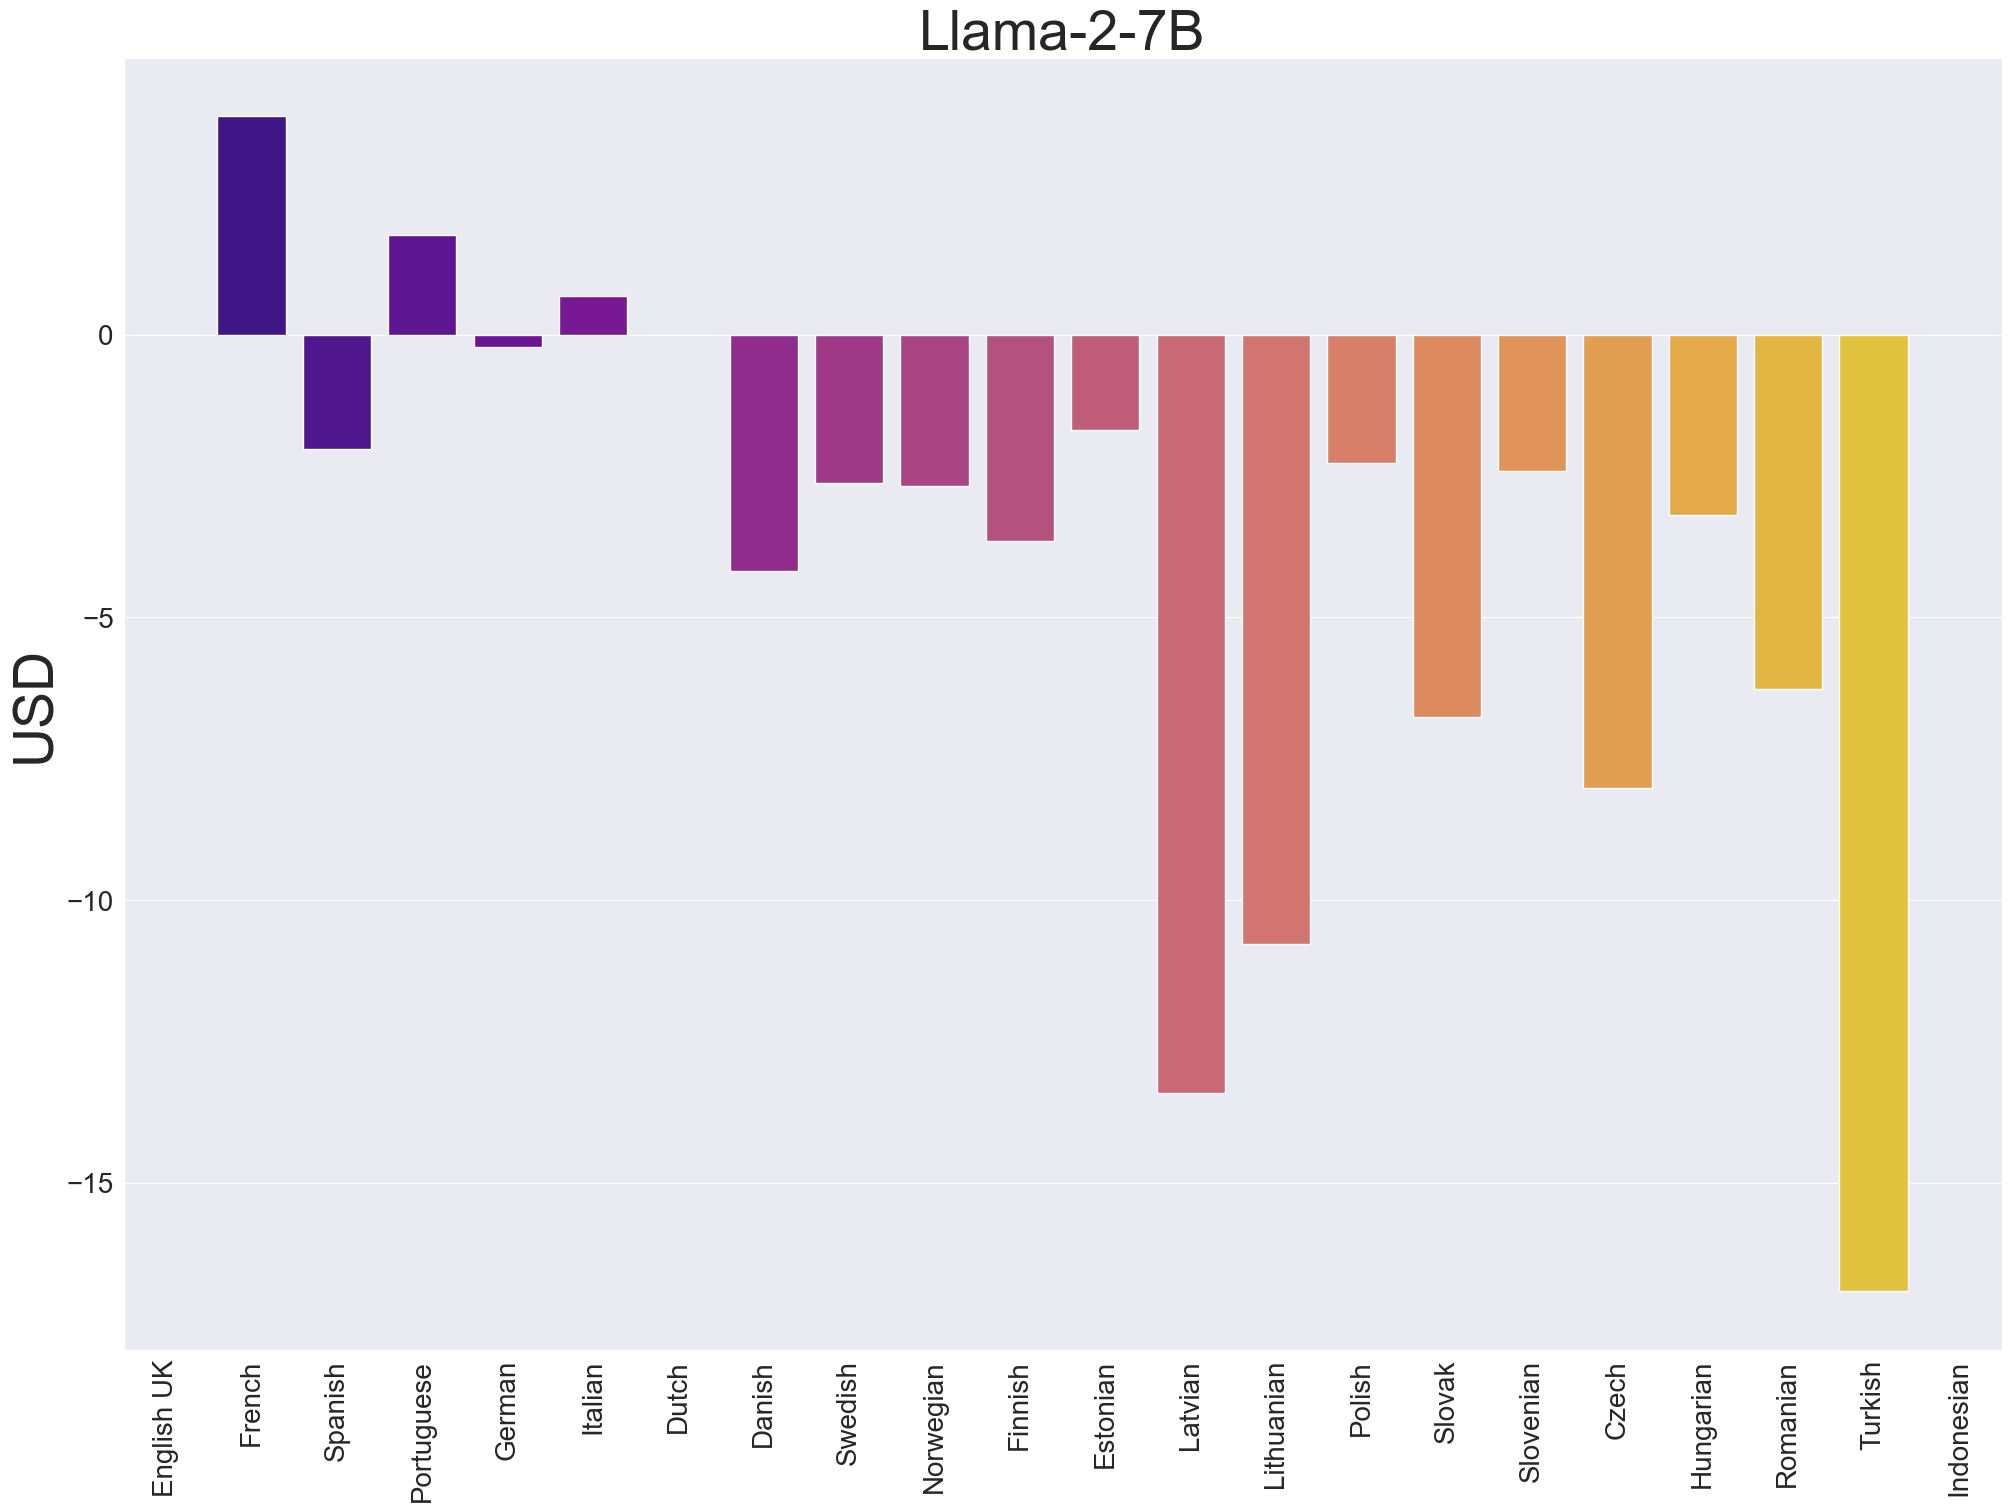

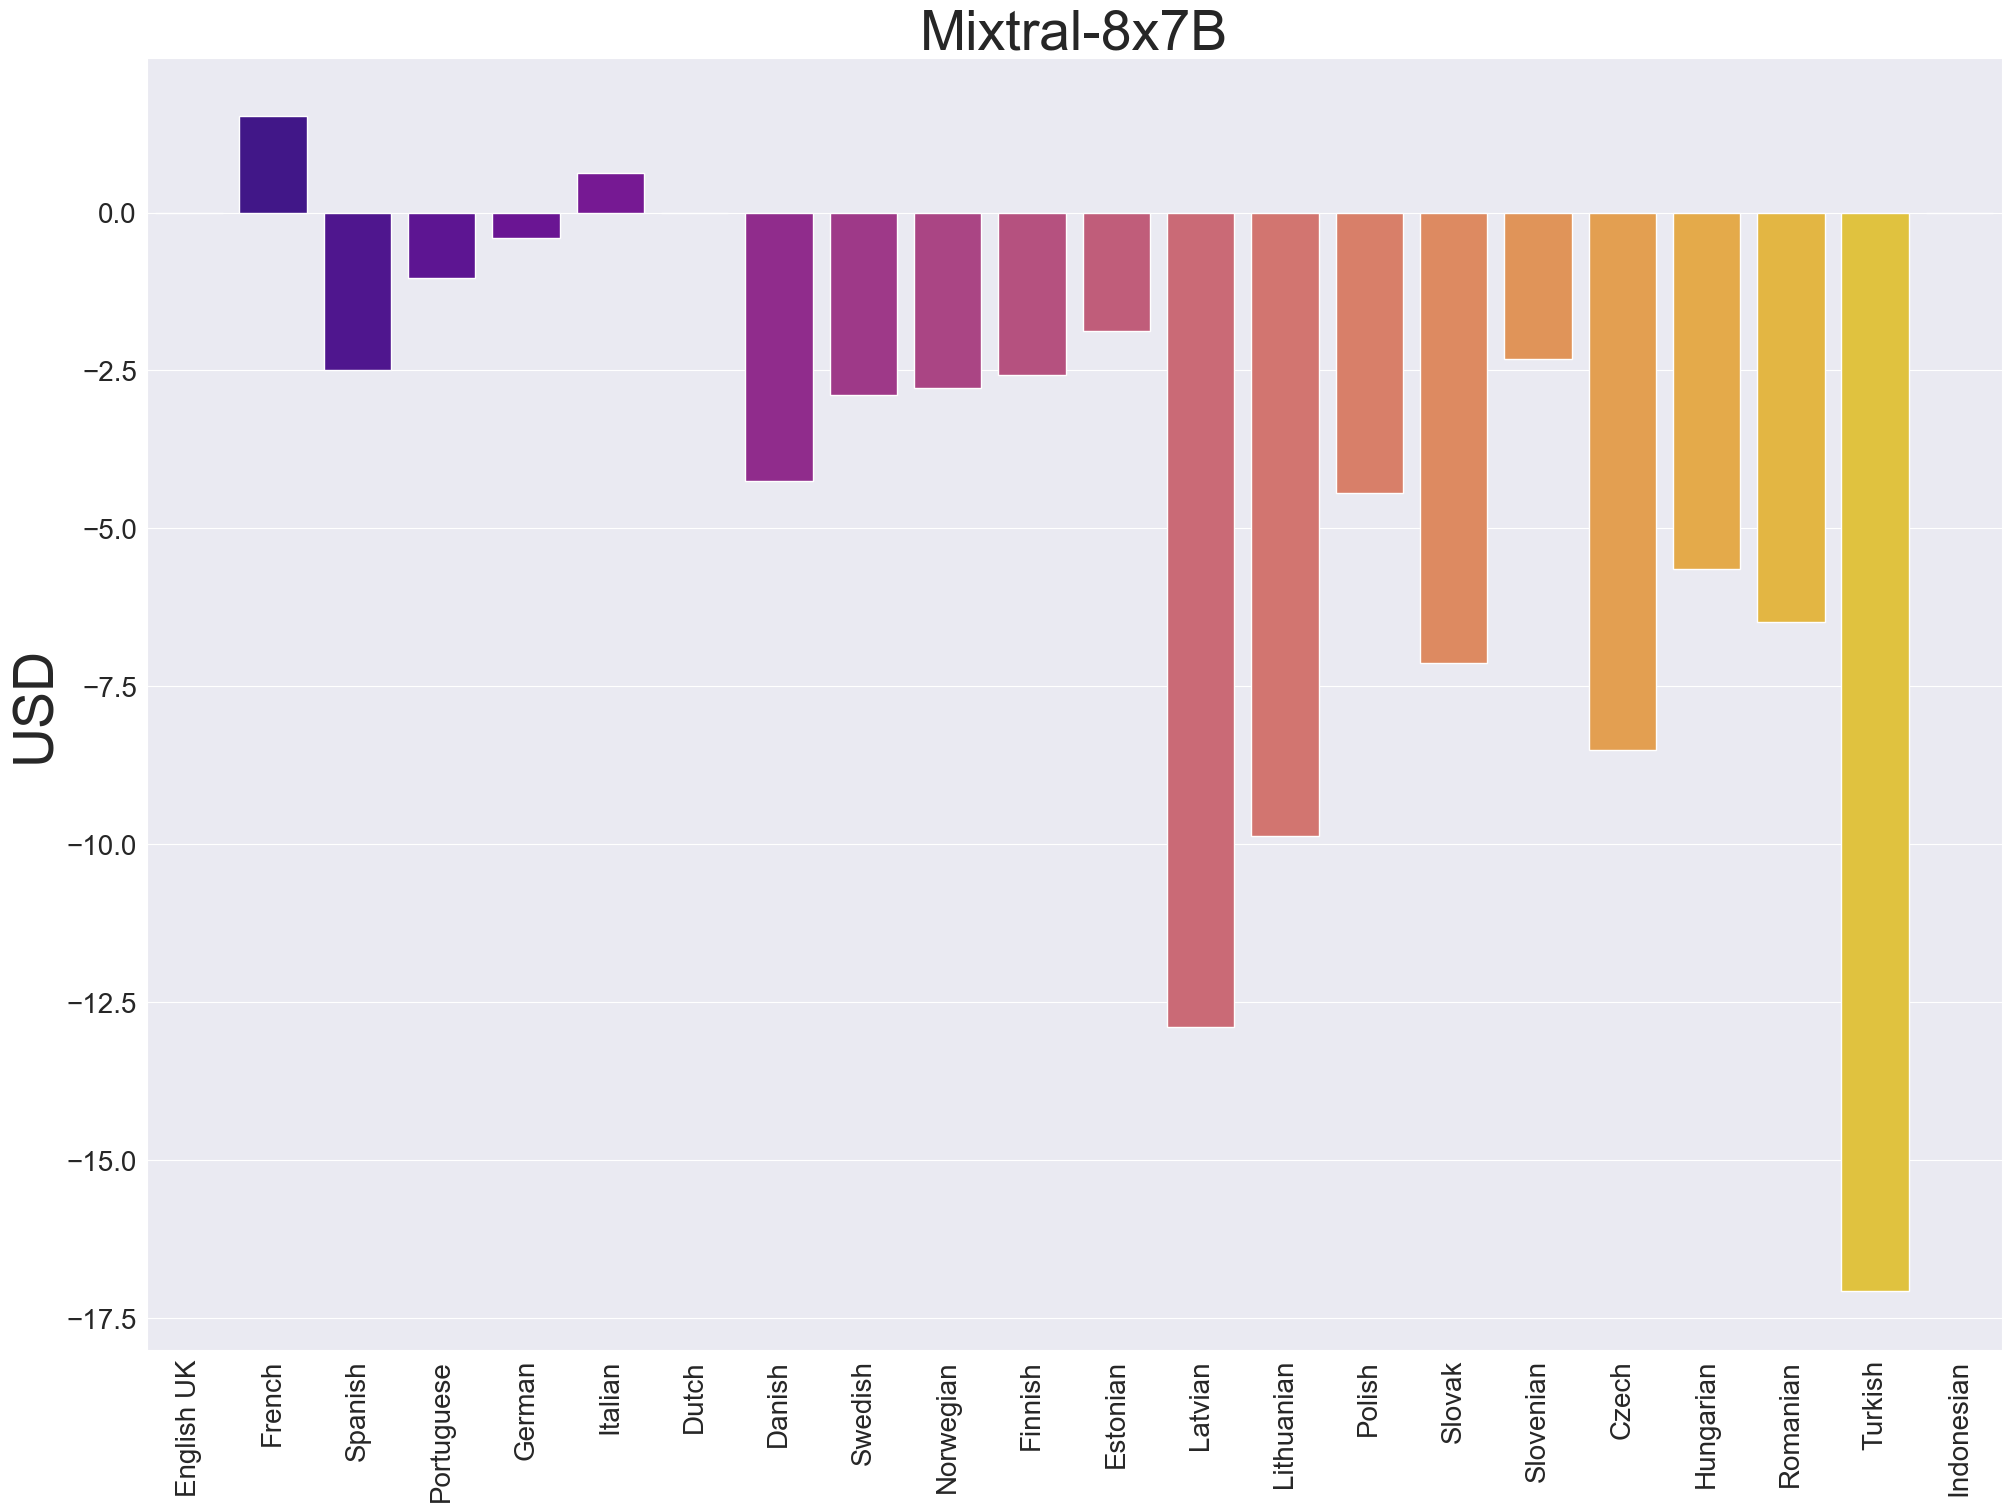

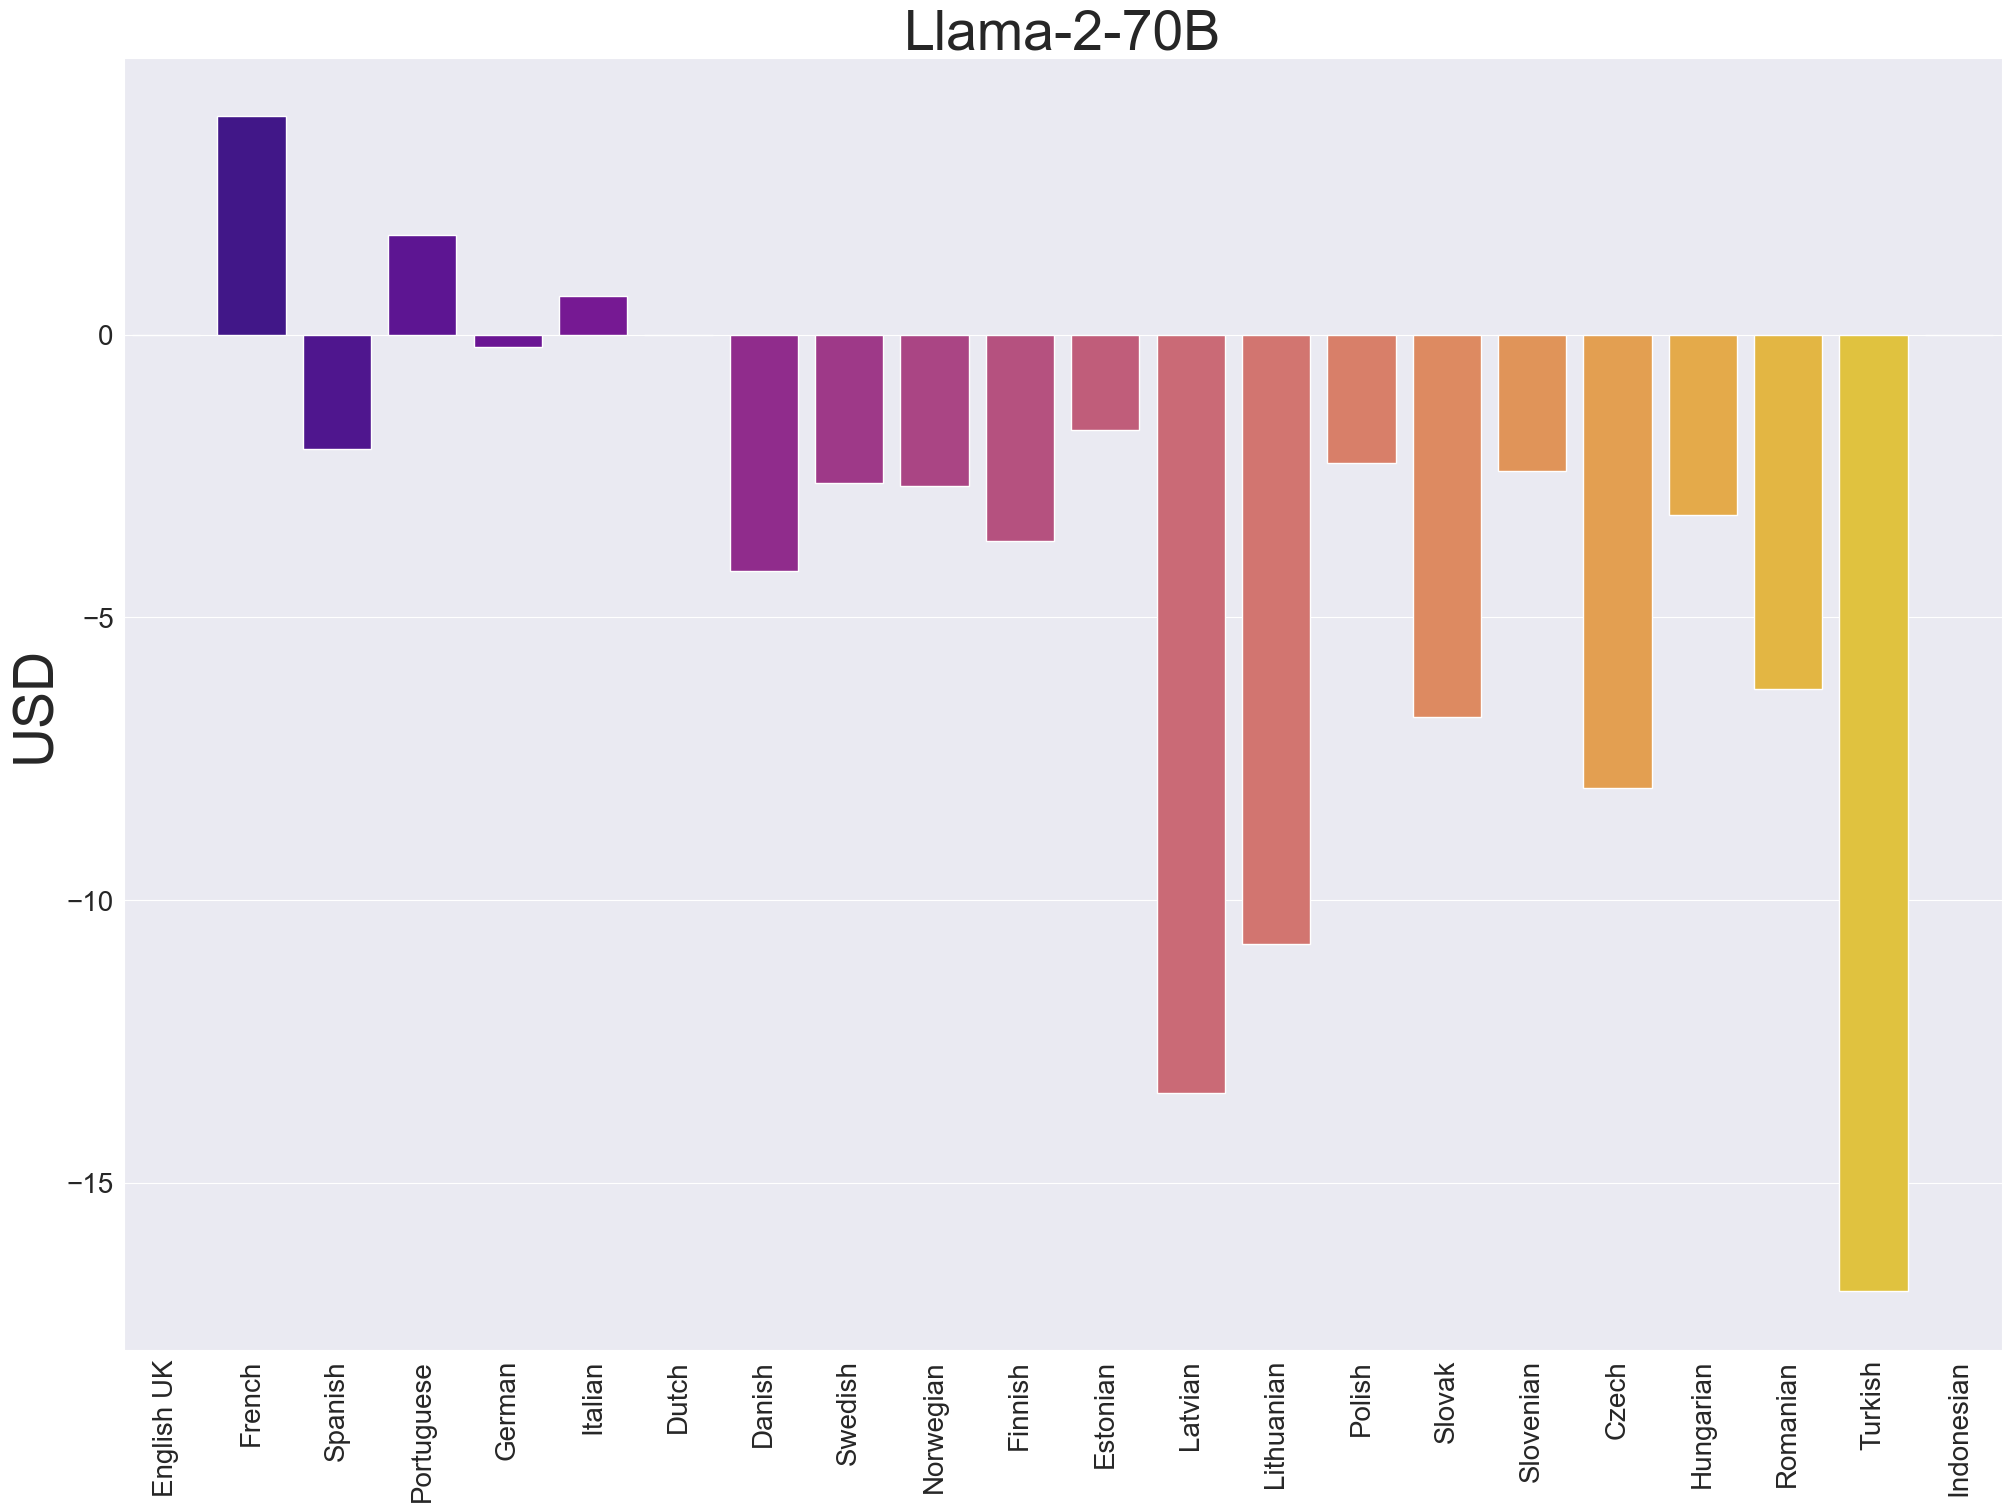

In [15]:
cost_difference_pct_no_special_characters = calculate_percentage_differences(
    num_tokens_original_text, num_tokens_original_text_no_special_characters
)

plot_model_lang_distributions(
    cost_difference_pct_no_special_characters,
    "plots_token/no_special_chars_pct_difference.png",
    "USD"
)

plot_as_separate_charts(
    cost_difference_pct_no_special_characters,
    "plots_token/no_special_chars_pct_difference.png",
    "USD",
)

In [29]:
import time
from tokens import Mixtral8x7BTokenCounter

source_text = Path("saturn.txt").read_text() * 20

token_counter = Mixtral8x7BTokenCounter()

start = time.time()
num_tokens = token_counter.count_tokens(source_text)
stop = time.time()

tokenizer_time = stop - start

print(f"Tokenizer time: {tokenizer_time}s")

print(num_tokens)

Tokenizer time: 0.18727779388427734s
6760


In [22]:
from embedding_models import E5LargeHuggingFaceModel
from tokens import Mixtral8x7BTokenCounter
from langchain_community.utils.math import cosine_similarity


def rephrase_text(text: str):
    client = OpenAI(base_url="http://localhost:1234/v1", api_key="not-needed")

    completion = client.chat.completions.create(
      model="local-model",
      messages=[
        {"role": "system", "content": "Creatively rephrase the following text differently, making it about a random object."},
        {"role": "user", "content": text}
      ],
      temperature=1.0,
    )

    return completion.choices[0].message.content

def _cosine_similarity(embed_a: list[float], embed_b: list[float]) -> float:
    return cosine_similarity([embed_a], [embed_b])[0][0]

token_counter = Mixtral8x7BTokenCounter()
source_text_rephrase = Path("saturn.txt").read_text()
embedding_model = E5LargeHuggingFaceModel()

previous_embedding = embedding_model._compute_embedding(source_text_rephrase)

for i in range(1000):
    tokens = token_counter.get_tokens(source_text_rephrase)
    unique_tokens = set(tokens)
    print(i, len(unique_tokens))
    source_text_rephrase = rephrase_text(source_text_rephrase)

    embedding = embedding_model._compute_embedding(source_text_rephrase)

    if previous_embedding is not None:
        similarity = _cosine_similarity(embedding, previous_embedding)
        print(similarity)
        # print(source_text_rephrase)

    previous_embedding = embedding

print(source_text_rephrase)


KeyboardInterrupt: 